<a href="https://colab.research.google.com/github/Tar-ive/WIC_clustering/blob/main/wic_clustering_analaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Engineering to create required variables

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/content/189_dataset - NUMERIC_HealthIssuesRuralTX_Net.csv')

# Create age groups from Age column
df['age_group'] = pd.cut(pd.to_numeric(df['Age'], errors='coerce'),
                         bins=[0, 44, 64, float('inf')],
                         labels=['18-44', '45-64', '65+'])

# Create health issues count
df['health_issues_count'] = df['poor_phys'] + df['poor_mental'] + df['poor_qol'] + df['chronic_cond_binary']

# Create social determinants of health vulnerability score
df['sdoh_vulnerability_score'] = (df['food_insecure_binary'] + df['house_insecure_binary'] +
                                 df['transport_insecure_binary'] + df['income_insecure_binary'])

# Create healthcare proximity measures
# Count facilities within 30 minutes (assuming 1 and 2 are the codes for "within 30 minutes")
proximity_time_cols = ['Q2.19_1', 'Q2.19_2', 'Q2.19_3', 'Q2.19_4', 'Q2.19_5']
df['facilities_within_30min'] = df[proximity_time_cols].apply(
    lambda x: sum([(1 if pd.notnull(val) and val in [1, 2] else 0) for val in x]), axis=1)

# Count facilities within 10 miles (assuming 1 and 2 are the codes for "within 10 miles")
proximity_distance_cols = ['Q2.20_1', 'Q2.20_2', 'Q2.20_3', 'Q2.20_4', 'Q2.20_5']
df['facilities_within_10miles'] = df[proximity_distance_cols].apply(
    lambda x: sum([(1 if pd.notnull(val) and val in [1, 2] else 0) for val in x]), axis=1)

# Create binary indicators for specific facilities being nearby
df['primary_care_nearby'] = df['Q2.19_1'].apply(lambda x: 1 if pd.notnull(x) and x in [1, 2] else 0)
df['urgent_care_nearby'] = df['Q2.19_2'].apply(lambda x: 1 if pd.notnull(x) and x in [1, 2] else 0)
df['er_nearby'] = df['Q2.19_5'].apply(lambda x: 1 if pd.notnull(x) and x in [1, 2] else 0)

# Create incorrect care binary indicator from Q2.22
df['incorrect_care_binary'] = df['Q2.22'].apply(lambda x: 1 if pd.notnull(x) and x == 1 else 0)

# Create the final dataset for clustering with selected variables
cluster_df = df[['Response ID', 'age_group', 'Gender', 'college_ed_binary', 'employed_binary',
                 'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
                 'health_issues_count', 'food_insecure_binary', 'house_insecure_binary',
                 'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score',
                 'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
                 'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby',
                 'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care',
                 'mean_satisfaction', 'incorrect_care_binary']].copy()

# Convert percentage string to float if needed
if 'pct_times_get_Care' in cluster_df.columns and cluster_df['pct_times_get_Care'].dtype == 'object':
    cluster_df['pct_times_get_Care'] = cluster_df['pct_times_get_Care'].str.rstrip('%').astype('float') / 100

# Handle missing values for branching logic questions without removing records
# For questions where NA means "not applicable" due to branching logic, fill with appropriate values

# For pregnant_binary, NA likely means not applicable (male respondent or didn't answer)
if 'pregnant_binary' in cluster_df.columns:
    cluster_df['pregnant_binary'] = cluster_df['pregnant_binary'].fillna(0)  # Not applicable = 0

# For pct_times_get_Care, if NA, it might mean they never needed care
# Rather than drop these records, we can set to a value that makes sense (e.g., 1.0 for 100% since they never failed)
if 'pct_times_get_Care' in cluster_df.columns:
    cluster_df['pct_times_get_Care'] = cluster_df['pct_times_get_Care'].fillna(1.0)

# For mean_satisfaction, if NA, might mean they never sought care
# Fill with the middle/neutral value of the scale (assuming it's a 1-5 scale)
if 'mean_satisfaction' in cluster_df.columns:
    cluster_df['mean_satisfaction'] = cluster_df['mean_satisfaction'].fillna(3.0)

# For incorrect_care_binary, NA might mean they haven't sought care
if 'incorrect_care_binary' in cluster_df.columns:
    cluster_df['incorrect_care_binary'] = cluster_df['incorrect_care_binary'].fillna(0)

# Check that we have all 159 records
print(f"Number of records in final dataset: {len(cluster_df)}")

# Create a standardized version for clustering
cluster_data_standardized = cluster_df.copy()

# One-hot encode categorical variables
cluster_data_standardized = pd.get_dummies(cluster_data_standardized,
                                          columns=['age_group'],
                                          drop_first=False)

# Standardize continuous variables
scaler = StandardScaler()
continuous_cols_to_scale = ['health_issues_count', 'sdoh_vulnerability_score',
                            'facilities_within_30min', 'facilities_within_10miles',
                            'pct_times_get_Care', 'mean_satisfaction']

# Create standardized versions with suffix
for col in continuous_cols_to_scale:
    if col in cluster_data_standardized.columns:
        new_col_name = f"{col}_scaled"
        cluster_data_standardized[new_col_name] = scaler.fit_transform(
            cluster_data_standardized[[col]])

# Save both versions
cluster_df.to_csv('cluster_data_.csv', index=False)
cluster_data_standardized.to_csv('cluster_data_standardized.csv', index=False)

# Display the first few rows of the prepared dataset
print("\nOriginal cluster data (first 5 rows):")
print(cluster_df.head())

Number of records in final dataset: 159

Original cluster data (first 5 rows):
         Response ID age_group  Gender  college_ed_binary  employed_binary  \
0  R_3JCz3zdTAVO9cfh     18-44       1                  0                1   
1  R_1IGbr1gBEhUZUc0     18-44       1                  1                1   
2  R_Qb7rTnzQz92j0Tn     18-44       1                  1                1   
3  R_1K3hHoVGo8WgR65     45-64       1                  0                1   
4  R_2XaPUcbDh4d3Tck     18-44       1                  0                0   

   chronic_cond_binary  pregnant_binary  poor_phys  poor_mental  poor_qol  \
0                    0                0          0            0         0   
1                    0                1          0            1         0   
2                    0                1          0            0         0   
3                    1                0          0            0         1   
4                    1                1          0            1    

In [ ]:
cluster_data_standardized

Response ID  Gender  college_ed_binary  employed_binary  \
0    R_3JCz3zdTAVO9cfh       1                  0                1   
1    R_1IGbr1gBEhUZUc0       1                  1                1   
2    R_Qb7rTnzQz92j0Tn       1                  1                1   
3    R_1K3hHoVGo8WgR65       1                  0                1   
4    R_2XaPUcbDh4d3Tck       1                  0                0   
..                 ...     ...                ...              ...   
154  R_3qvOzPwd8xvj2wm       1                  1                1   
155  R_3RrRmQAL0atlH5j       1                  0                0   
156  R_23jRYyNCdc1bzzj       1                  0                1   
157  R_6hVtln0xycbXyvL       1                  0                0   
158  R_1F3BKrvbyGfc1hc       1                  1                0   

     chronic_cond_binary  pregnant_binary  poor_phys  poor_mental  poor_qol  \
0                      0                0          0            0         0   
1                      0                1          0            1         0   
2                      0                1          0            0         0   
3                      1                0          0            0         1   
4                      1                1          0            1         1   
..                   ...              ...        ...          ...       ...   
154                    0                1          0            0         0   
155                    1                0          1            0         1   
156                    1                0          0            0         0   
157                    0                0          1            0         0   
158                    0                0          0            0         0   

     health_issues_count  ...  incorrect_care_binary  age_group_18-44  \
0                      0  ...                      0             True   
1                      1  ...                      0             True   
2                      0  ...                      0             True   
3                      2  ...                      0            False   
4                      3  ...                      0             True   
..                   ...  ...                    ...              ...   
154                    0  ...                      1             True   
155                    3  ...                      0            False   
156                    1  ...                      1             True   
157                    1  ...                      1             True   
158                    0  ...                      0             True   

     age_group_45-64  age_group_65+  health_issues_count_scaled  \
0              False          False                   -0.891782   
1              False          False                    0.043351   
2              False          False                   -0.891782   
3               True          False                    0.978483   
4              False          False                    1.913615   
..               ...            ...                         ...   
154            False          False                   -0.891782   
155             True          False                    1.913615   
156            False          False                    0.043351   
157            False          False                    0.043351   
158            False          False                   -0.891782   

     sdoh_vulnerability_score_scaled  facilities_within_30min_scaled  \
0                          -1.095934                       -2.299680   
1                          -0.255903                        0.886115   
2                          -0.255903                        0.248956   
3                          -1.095934                        0.248956   
4                           0.584127                        0.248956   
..                               ...                             ...   
154                         0.58412

In [ ]:
cluster_df_complete

Response ID age_group  Gender  college_ed_binary  employed_binary  \
0    R_3JCz3zdTAVO9cfh     18-44       1                  0                1   
1    R_1IGbr1gBEhUZUc0     18-44       1                  1                1   
2    R_Qb7rTnzQz92j0Tn     18-44       1                  1                1   
3    R_1K3hHoVGo8WgR65     45-64       1                  0                1   
4    R_2XaPUcbDh4d3Tck     18-44       1                  0                0   
..                 ...       ...     ...                ...              ...   
154  R_3qvOzPwd8xvj2wm     18-44       1                  1                1   
155  R_3RrRmQAL0atlH5j     45-64       1                  0                0   
156  R_23jRYyNCdc1bzzj     18-44       1                  0                1   
157  R_6hVtln0xycbXyvL     18-44       1                  0                0   
158  R_1F3BKrvbyGfc1hc     18-44       1                  1                0   

     chronic_cond_binary  pregnant_binary  poor_phys  poor_mental  poor_qol  \
0                      0                0          0            0         0   
1                      0                1          0            1         0   
2                      0                1          0            0         0   
3                      1                0          0            0         1   
4                      1                1          0            1         1   
..                   ...              ...        ...          ...       ...   
154                    0                1          0            0         0   
155                    1                0          1            0         1   
156                    1                0          0            0         0   
157                    0                0          1            0         0   
158                    0                0          0            0         0   

     ...  facilities_within_30min  facilities_within_10miles  \
0    ...                        0                          2   
1    ...                        5                          2   
2    ...                        4                          3   
3    ...                        4                          4   
4    ...                        4                          1   
..   ...                      ...                        ...   
154  ...                        5                          0   
155  ...                        4                          4   
156  ...                        3                          1   
157  ...                        5                          0   
158  ...                        3                          0   

     primary_care_nearby  urgent_care_nearby  er_nearby  \
0                      0                   0          0   
1                      1                   1          1   
2                      1                   0          1   
3                      1                   0          1   
4                      0                   1          1   
..                   ...                 ...        ...   
154                    1                   1          1   
155                    1                   0          1   
156                    0                   1          1   
157                    1                   1          1   
158                    1                   1          0   

     difficulty_coping_binary  sought_care_recently  pct_times_get_Care  \
0                           0                     0               1.000   
1                           0                     1               1.000   
2                           0                     1               1.000   
3                           0                     1               0.857   
4                           0                     1               0.556   
..                        ...                   ...                 ...   
154                         0                     1               1.000   
155                    

In [ ]:
cluster_data.shape

(159, 18)

# Testing for 3 approaches, and K-means clustering and evaluation

Loading and preparing the dataset...
Dataset shape: (159, 28)
Dataset columns: ['Response ID', 'age_group', 'Gender', 'college_ed_binary', 'employed_binary', 'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count', 'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score', 'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min', 'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby', 'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction', 'incorrect_care_binary']
Standardizing continuous variables...
One-hot encoding categorical variables...
Creating different feature sets for clustering...

Running clustering with individual variables...

Clustering with individual...
Finding optimal number of clusters from 2 to 9...
For n_clusters = 2, the silhouette score is 0.2296
For n_clus

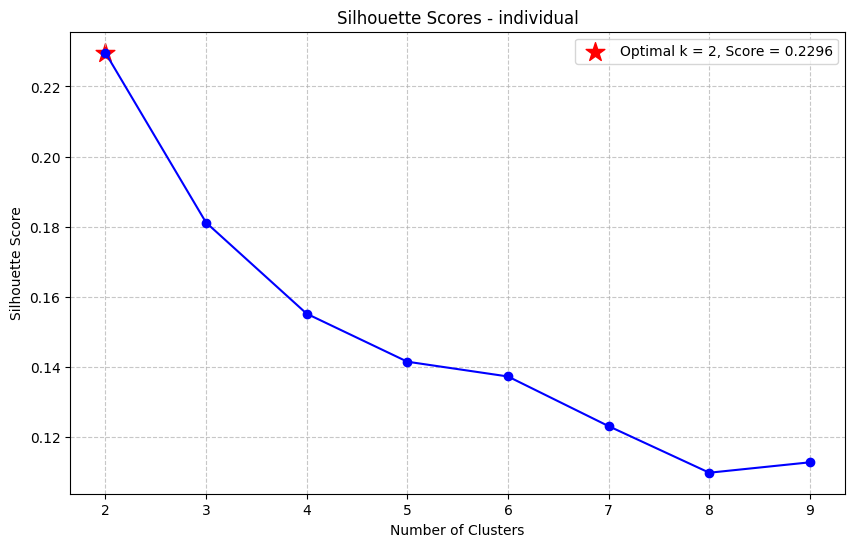

Applying K-means with 2 clusters...
Cluster sizes:
cluster_individual
0     45
1    114
dtype: int64
Generating cluster profiles based on original values...

Cluster Profiles:
                   age_group  Gender  college_ed_binary  employed_binary  \
cluster_individual                                                         
0                      18-44     1.0           0.311111         0.644444   
1                      18-44     1.0           0.333333         0.543860   

                    chronic_cond_binary  pregnant_binary  poor_phys  \
cluster_individual                                                    
0                              0.177778         0.311111   0.133333   
1                              0.254386         0.394737   0.131579   

                    poor_mental  poor_qol  health_issues_count  ...  \
cluster_individual                                              ...   
0                      0.222222  0.355556             0.888889  ...   
1                    

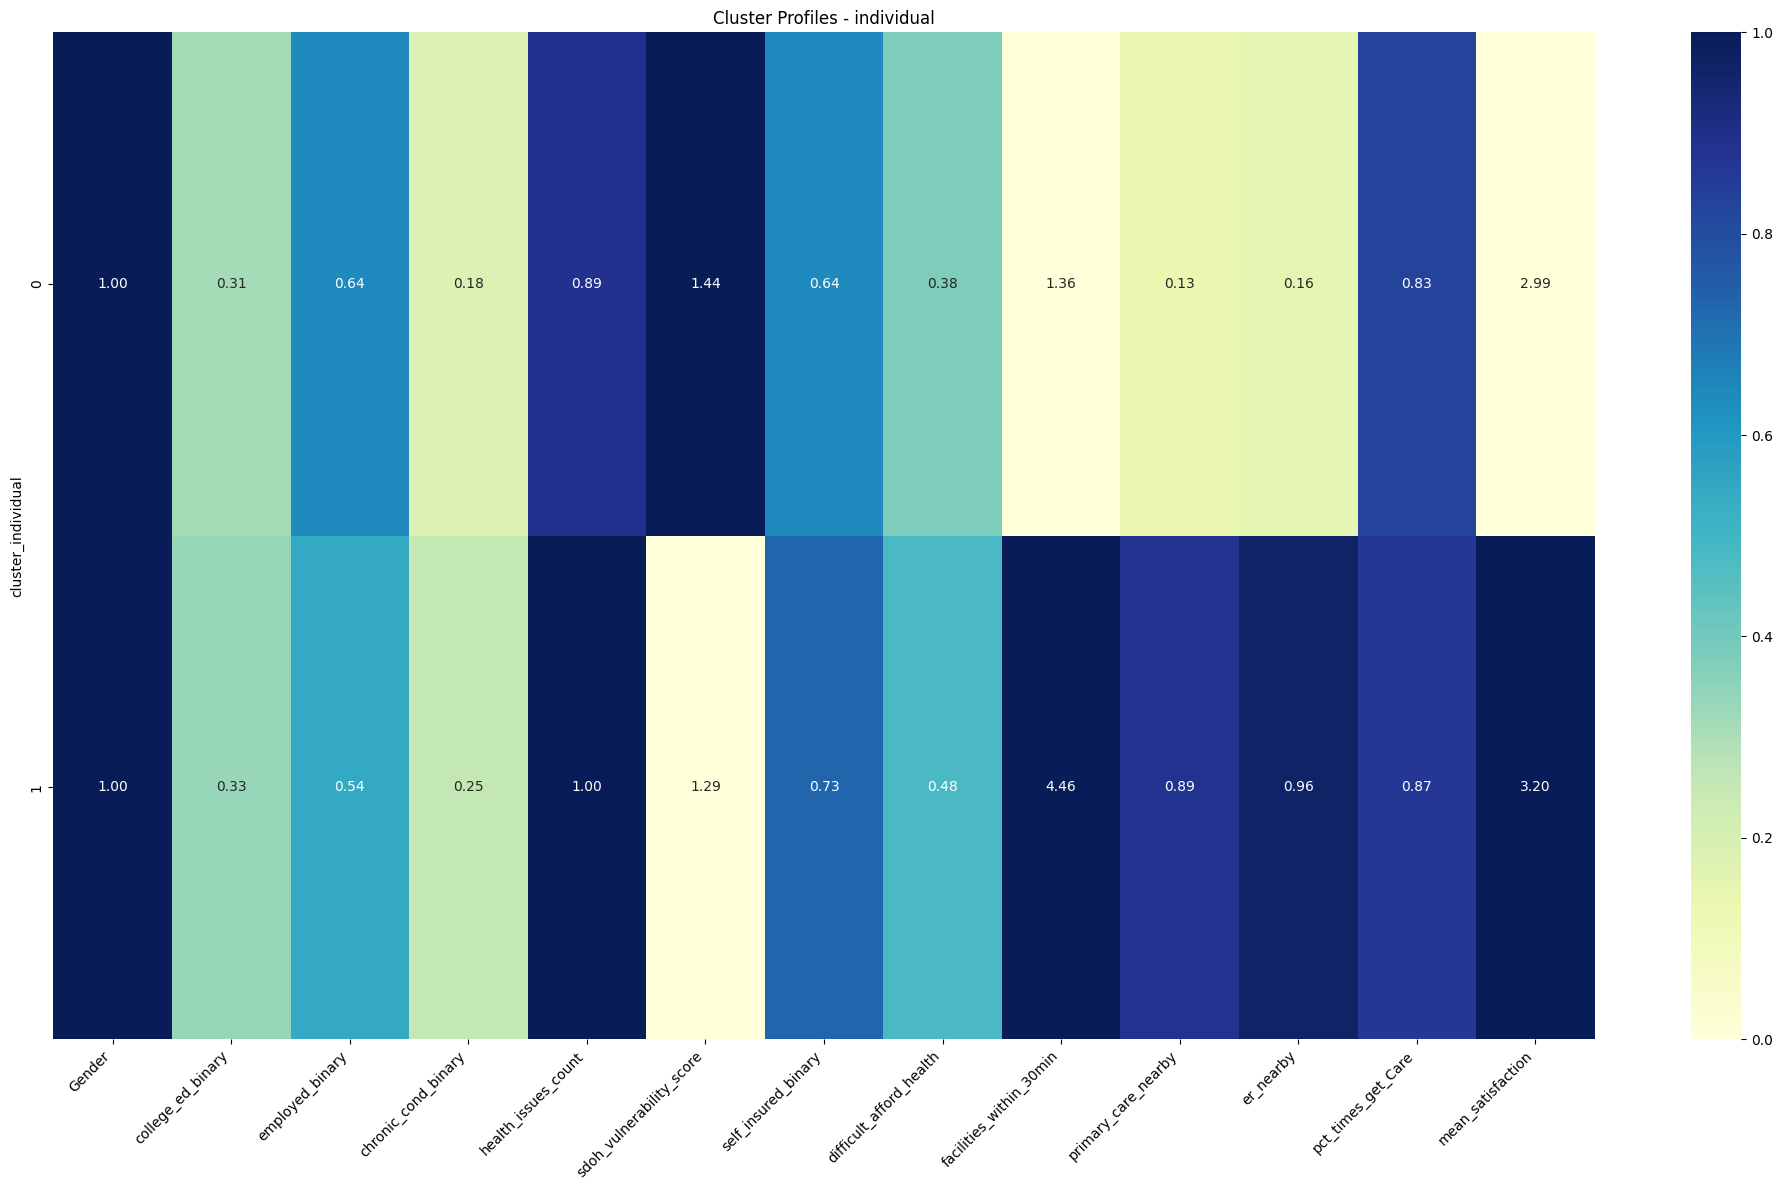

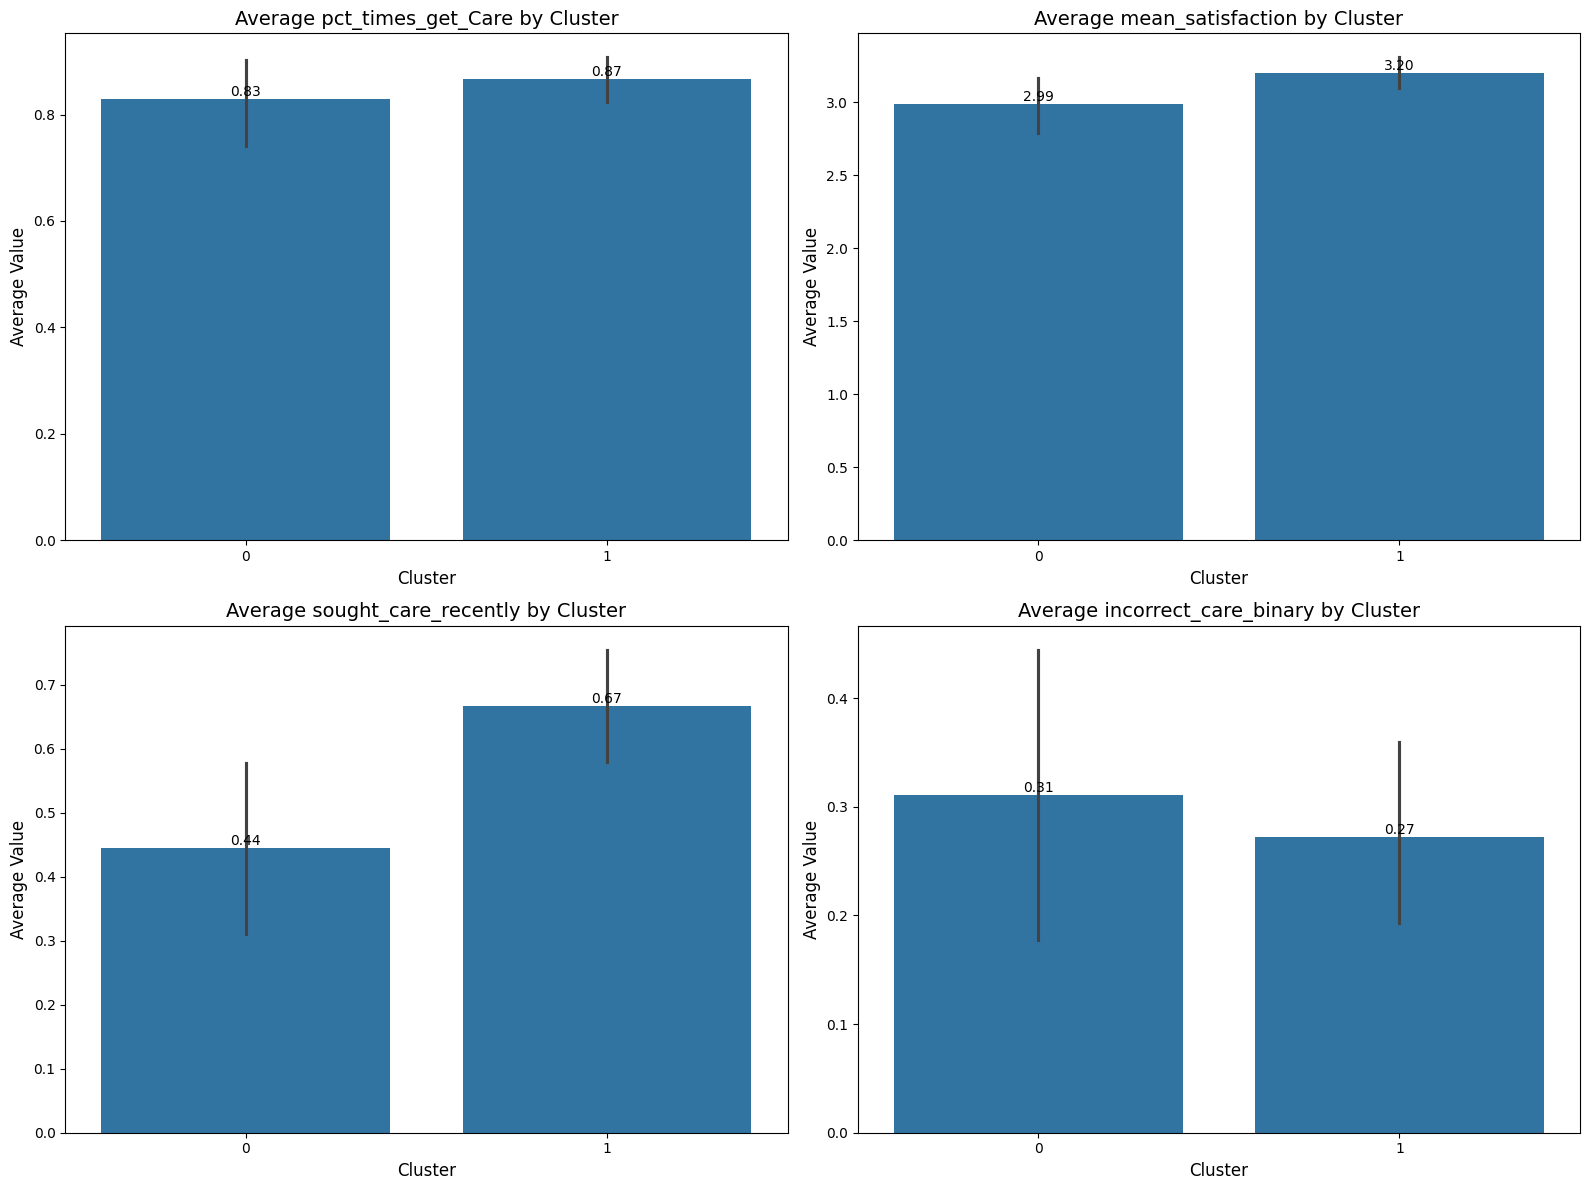


Sample profiles from each cluster:

Cluster 0 samples:
          Response ID age_group  Gender  chronic_cond_binary  \
60  R_1i83LGrBrAqYb7j     18-44       1                    0   
28  R_1mIVYUqDE1nN5Gz     18-44       1                    0   

    health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
60                    0                         1                    0   
28                    0                         0                    1   

    facilities_within_30min  pct_times_get_Care  mean_satisfaction  
60                        2                 1.0               4.00  
28                        0                 1.0               3.38  

Cluster 1 samples:
          Response ID age_group  Gender  chronic_cond_binary  \
44  R_232mcvBijIhwsjw     18-44       1                    0   
32  R_1rq87TnbWR1iLsK     18-44       1                    0   

    health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
44                    0           

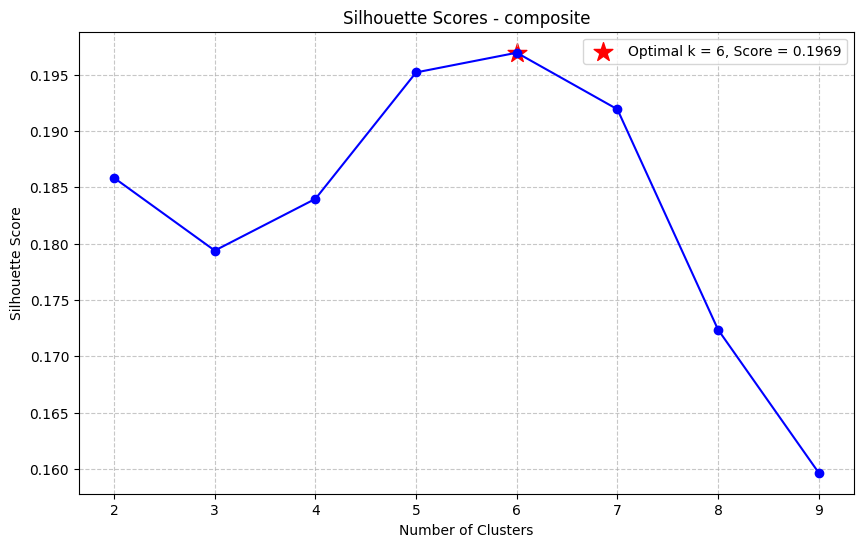

Applying K-means with 6 clusters...
Cluster sizes:
cluster_composite
0    36
1    26
2    22
3    33
4    18
5    24
dtype: int64
Generating cluster profiles based on original values...

Cluster Profiles:
                  age_group  Gender  college_ed_binary  employed_binary  \
cluster_composite                                                         
0                     18-44     1.0           0.416667         0.694444   
1                     18-44     1.0           0.384615         0.692308   
2                     18-44     1.0           0.272727         0.454545   
3                     18-44     1.0           0.363636         0.424242   
4                     18-44     1.0           0.111111         0.611111   
5                     18-44     1.0           0.291667         0.541667   

                   chronic_cond_binary  pregnant_binary  poor_phys  \
cluster_composite                                                    
0                             0.111111         0.30555

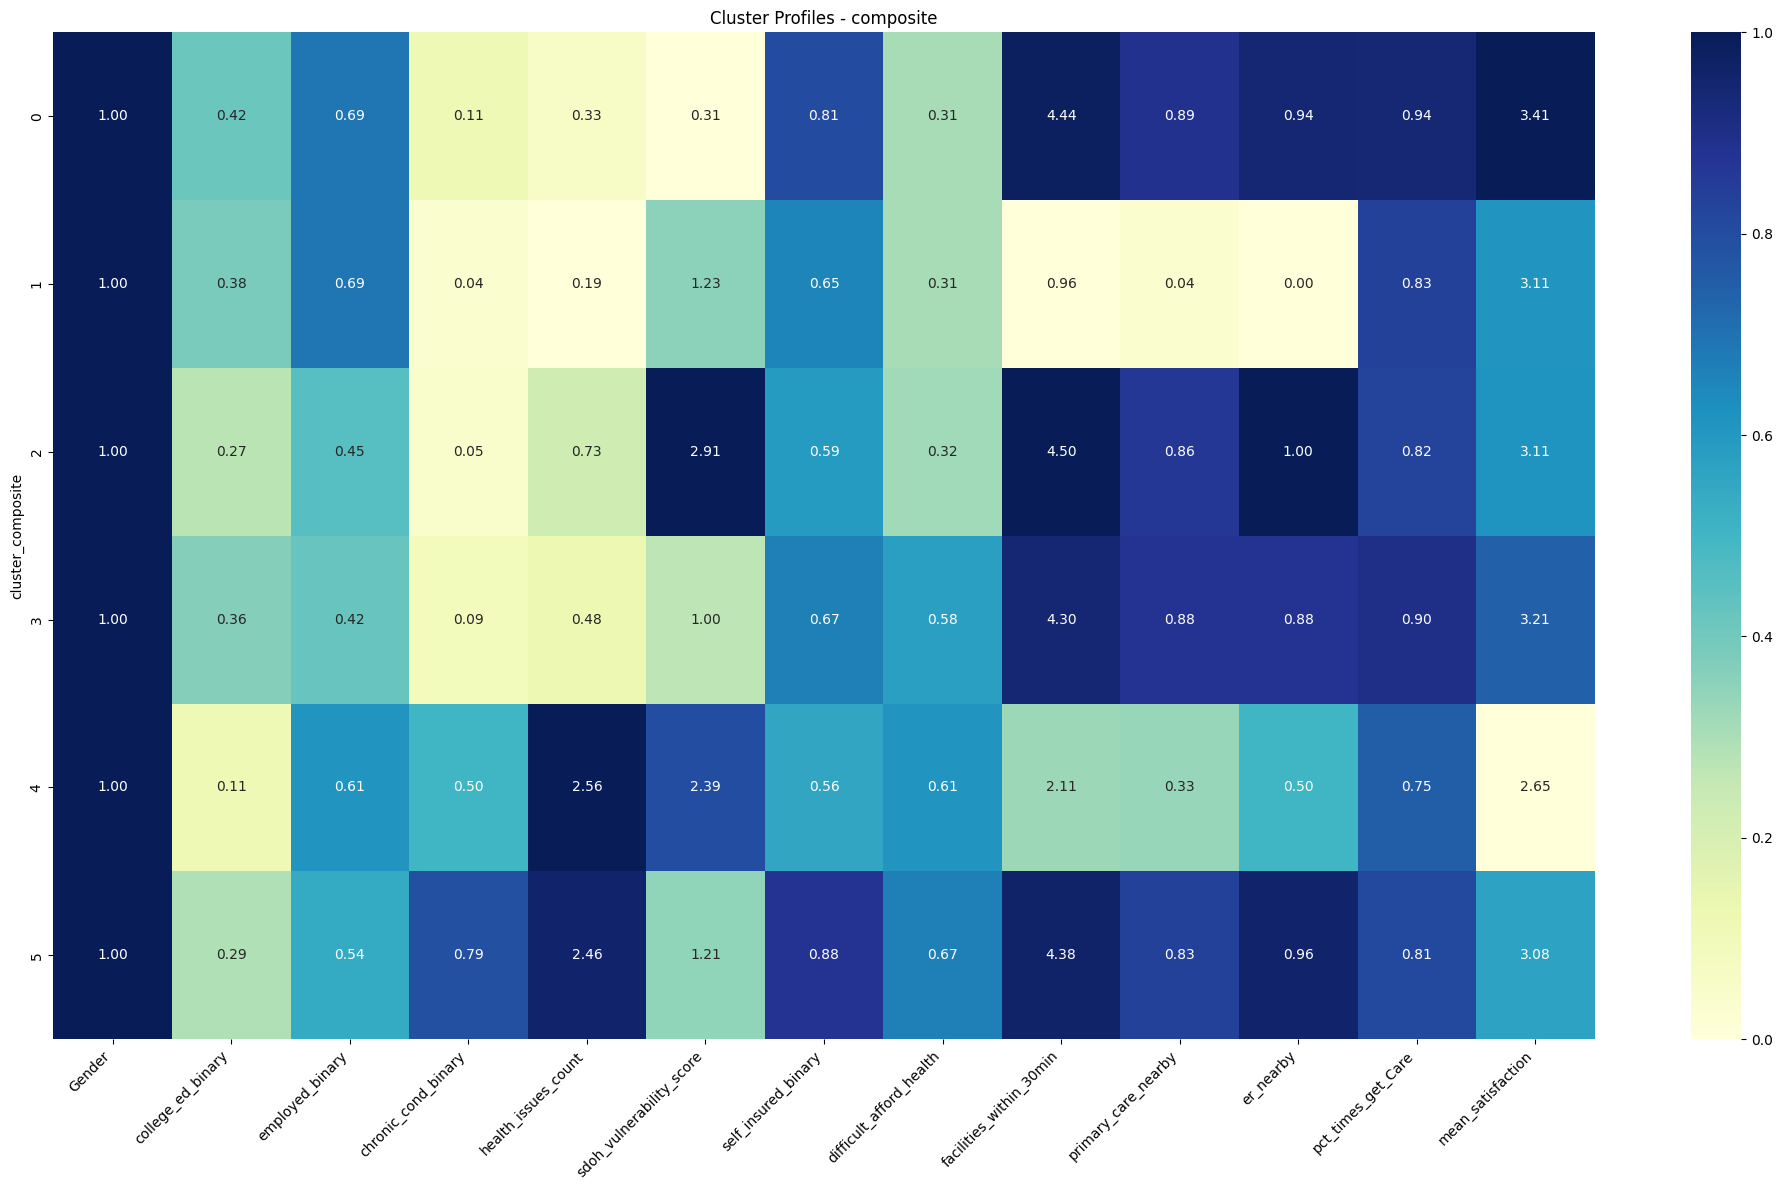

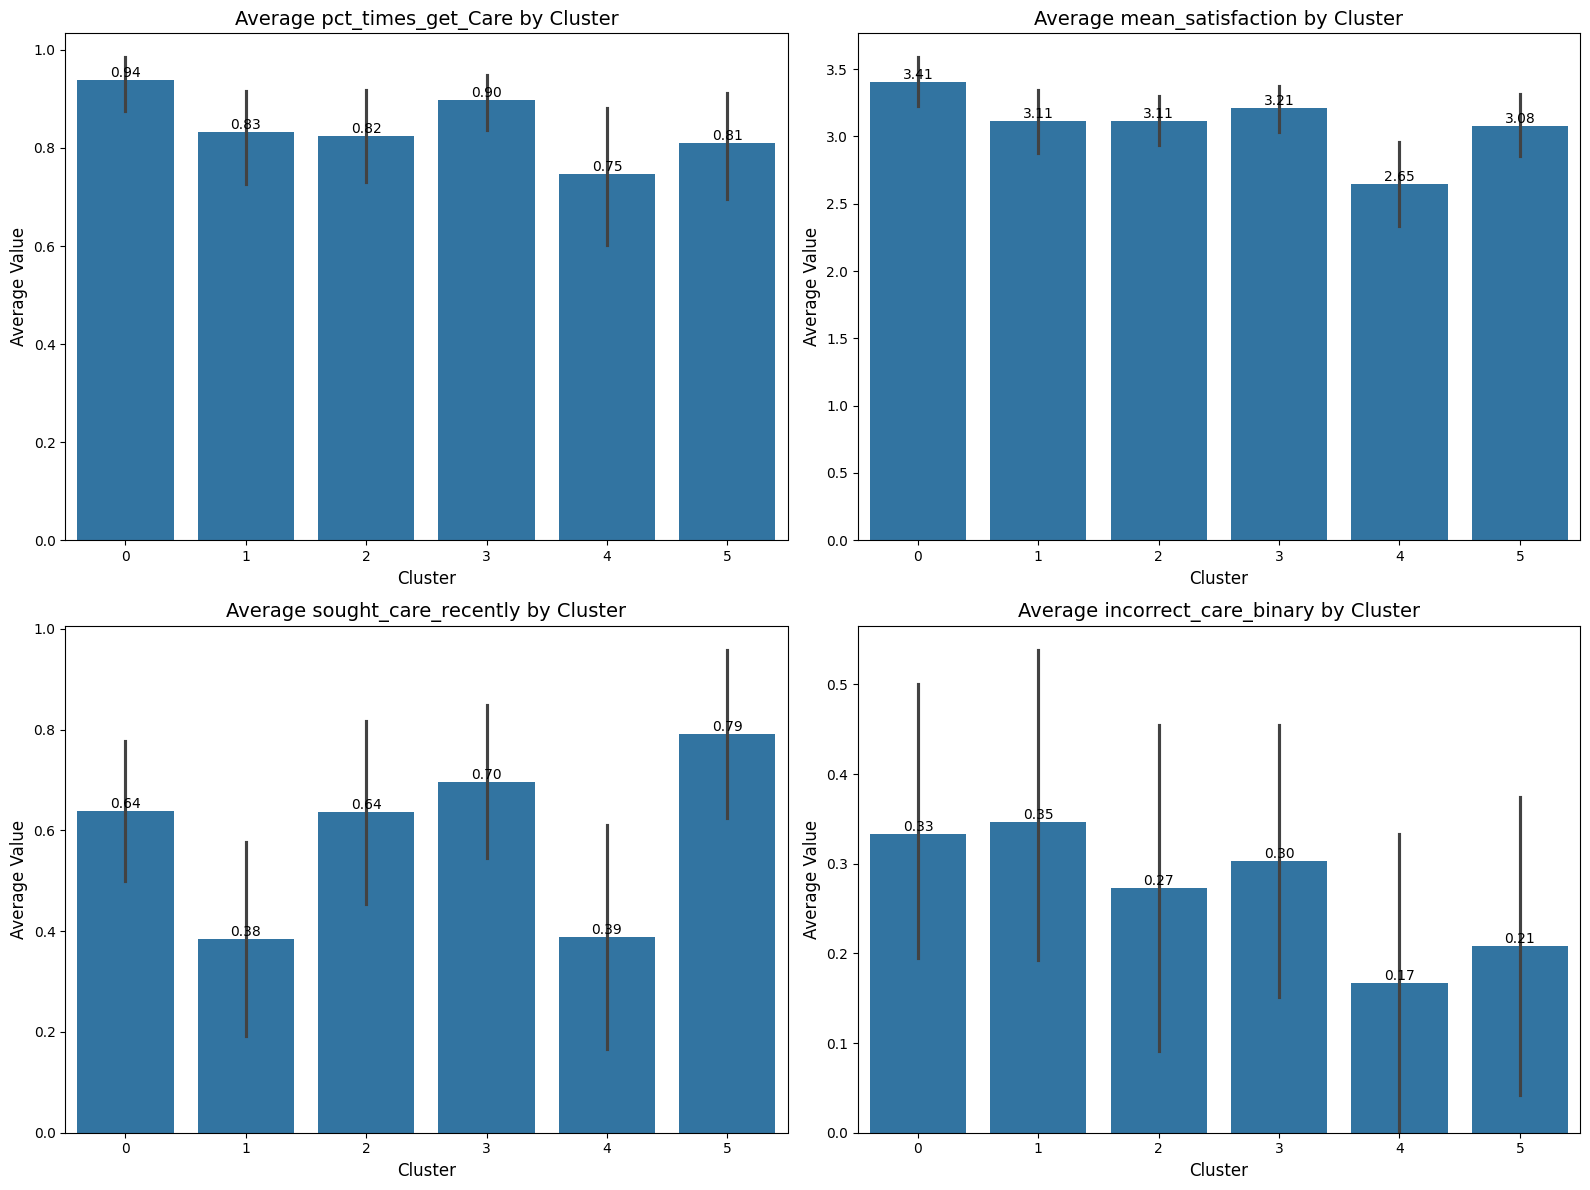


Sample profiles from each cluster:

Cluster 0 samples:
           Response ID age_group  Gender  chronic_cond_binary  \
73   R_3kKX84Or2zoM5VN     18-44       1                    0   
124  R_Rs00EYyJsNRp1nj     18-44       1                    0   

     health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
73                     1                         0                    1   
124                    0                         0                    1   

     facilities_within_30min  pct_times_get_Care  mean_satisfaction  
73                         5                 1.0                4.0  
124                        4                 1.0                4.0  

Cluster 1 samples:
          Response ID age_group  Gender  chronic_cond_binary  \
60  R_1i83LGrBrAqYb7j     18-44       1                    0   
96  R_0xmnIeEYa9N1Ydj     18-44       1                    0   

    health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
60                    0  

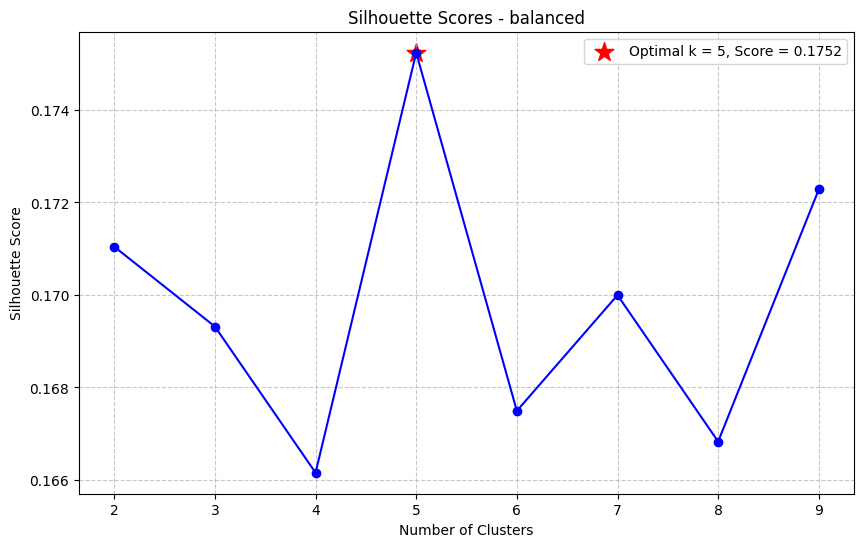

Applying K-means with 5 clusters...
Cluster sizes:
cluster_balanced
0    29
1    30
2    29
3    48
4    23
dtype: int64
Generating cluster profiles based on original values...

Cluster Profiles:
                 age_group  Gender  college_ed_binary  employed_binary  \
cluster_balanced                                                         
0                    18-44     1.0           0.344828         0.379310   
1                    18-44     1.0           0.366667         0.666667   
2                    18-44     1.0           0.172414         0.551724   
3                    18-44     1.0           0.416667         0.687500   
4                    18-44     1.0           0.260870         0.478261   

                  chronic_cond_binary  pregnant_binary  poor_phys  \
cluster_balanced                                                    
0                            0.034483         0.586207   0.103448   
1                            0.033333         0.400000   0.000000   
2        

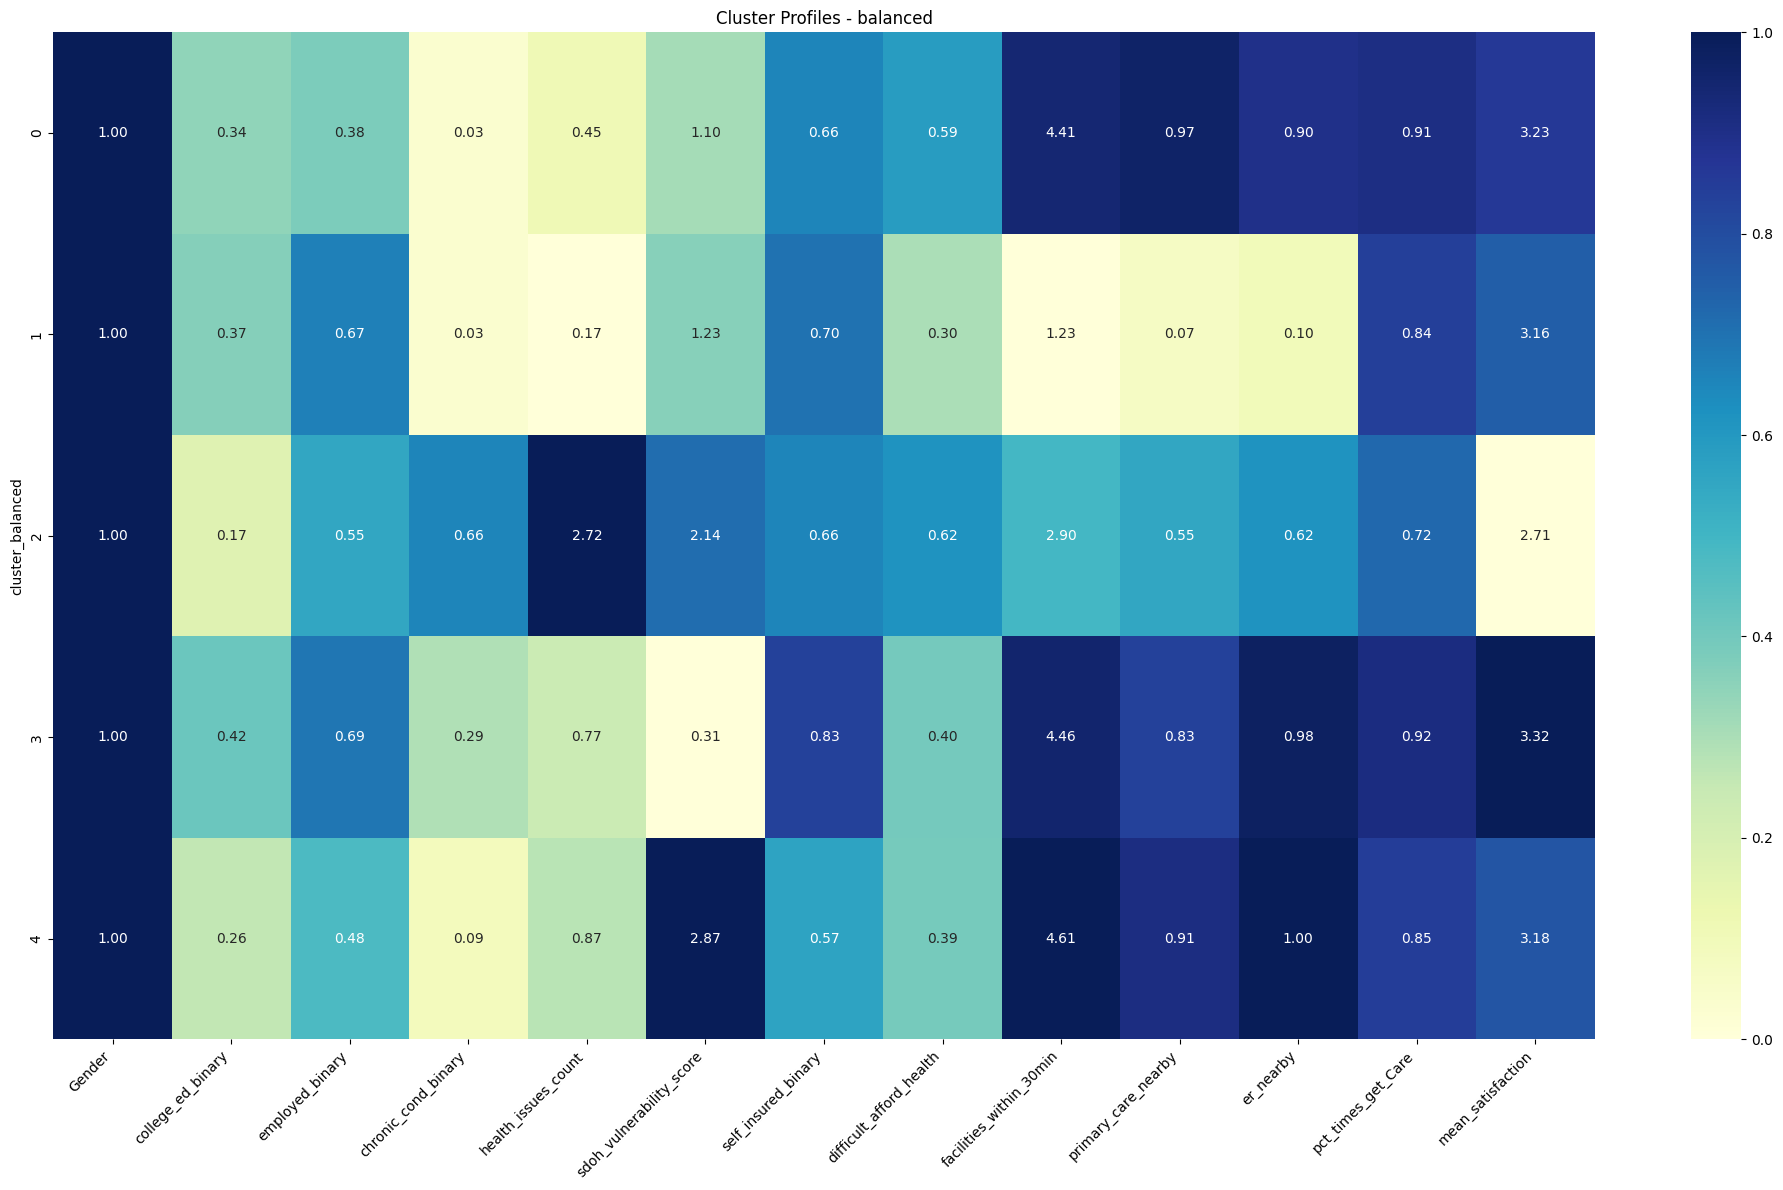

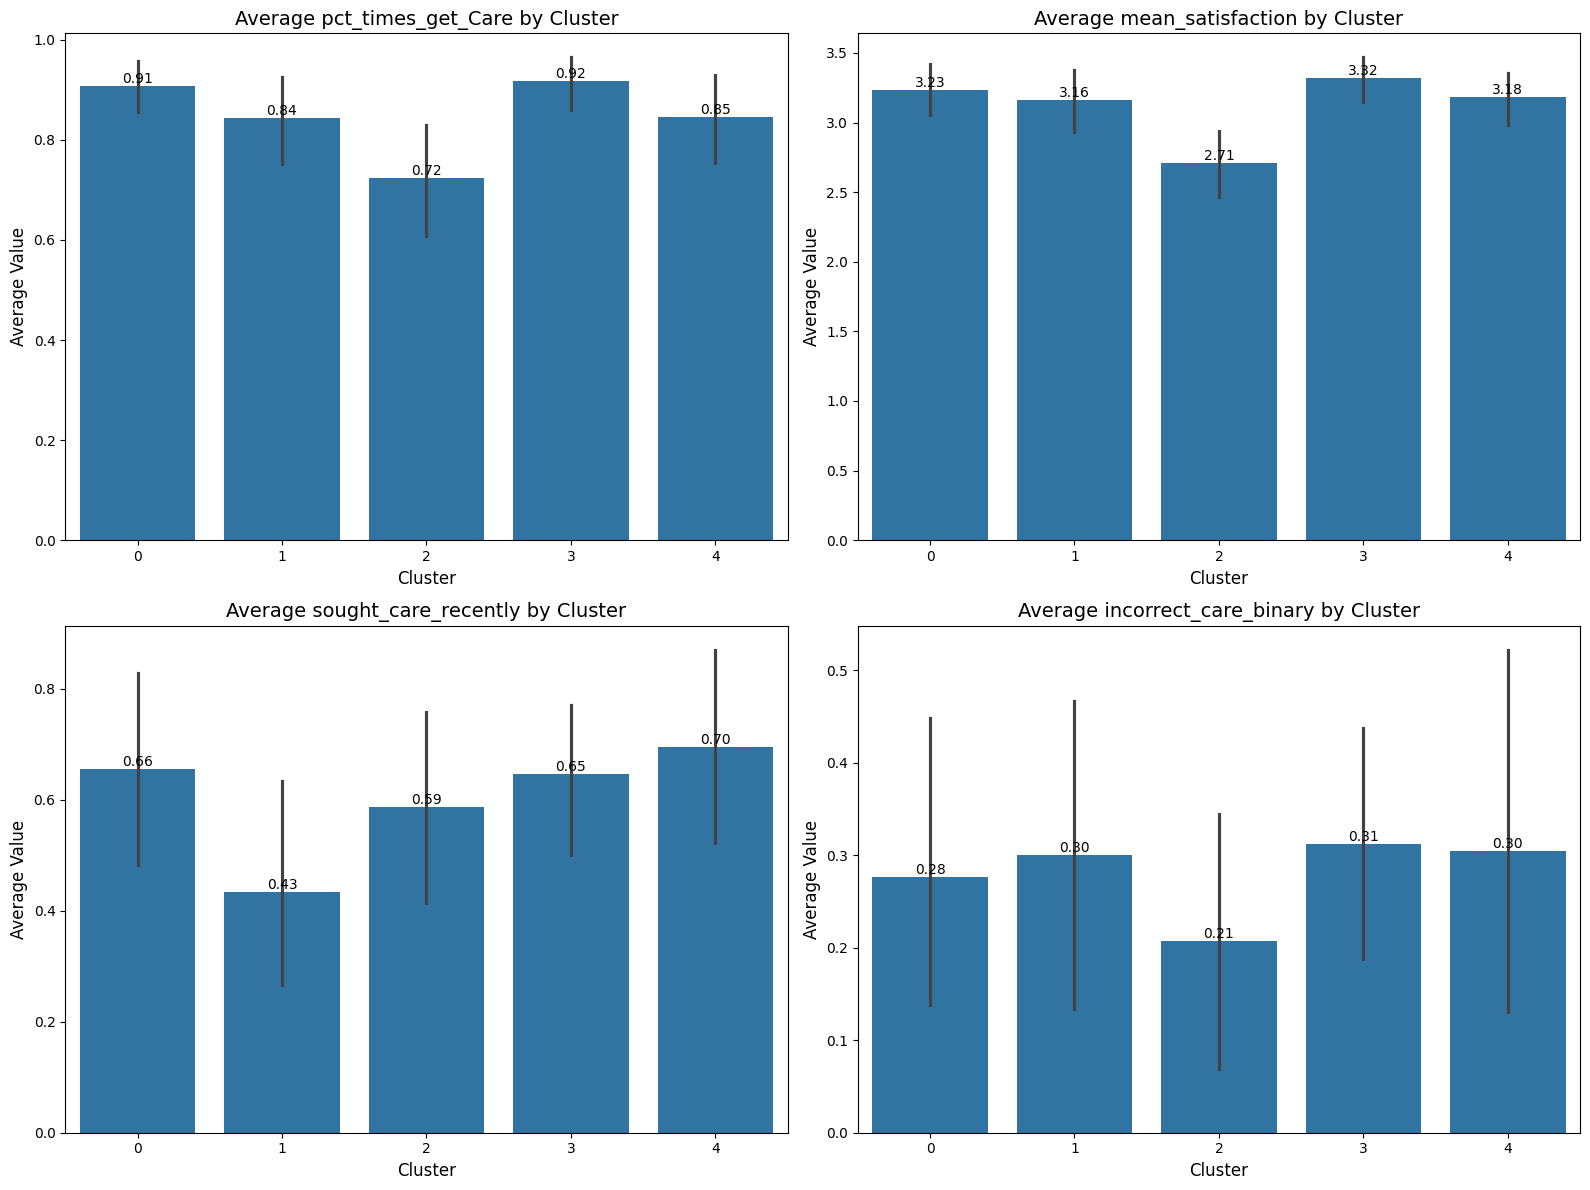


Sample profiles from each cluster:

Cluster 0 samples:
           Response ID age_group  Gender  chronic_cond_binary  \
110  R_2YllVtPGz46SU2d     45-64       1                    0   
50   R_2Qmm1hWV9bxReB8     18-44       1                    0   

     health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
110                    0                         2                    1   
50                     1                         2                    0   

     facilities_within_30min  pct_times_get_Care  mean_satisfaction  
110                        5                 0.7               2.55  
50                         5                 1.0               3.91  

Cluster 1 samples:
          Response ID age_group  Gender  chronic_cond_binary  \
79  R_11iIxaoWMKUKmAG     18-44       1                    0   
65  R_2Cxm1RWntqTPfXw     45-64       1                    0   

    health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
79                    0  

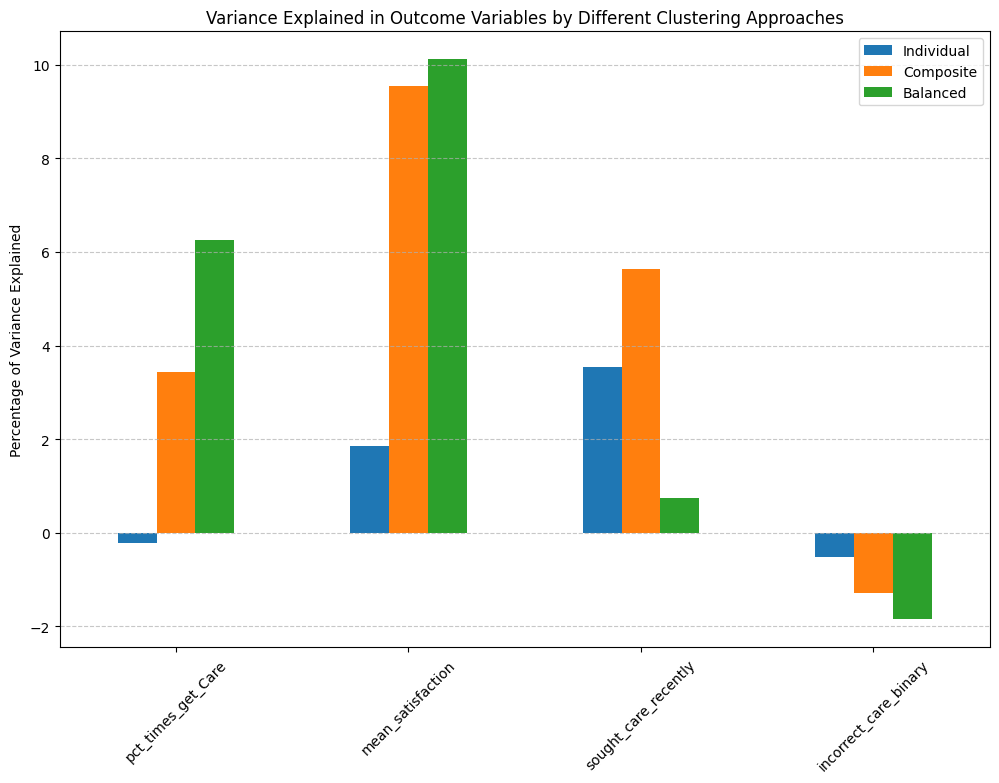


Based on the evaluation, the balanced approach appears to be the best for interpretation.

Final clustered data saved to 'final_clustered_data.csv'

Clustering analysis complete!

Narrative description of each cluster in the best approach:

Cluster 0 (29 individuals, 18.2% of sample):
Demographic Profile: Predominantly 18-44 age group, 100.0% female, 34.5% college educated, 37.9% employed.
Health Status: 3.4% have chronic conditions with an average of 0.4 health issues per person.
Social Vulnerabilities: Average vulnerability score of 1.1 out of 4, with 37.9% food insecure, 10.3% housing insecure, 10.3% transportation insecure, and 51.7% income insecure.
Healthcare Access: 65.5% self-insured, 58.6% report difficulty affording healthcare, average of 4.4 healthcare facilities within 30 minutes, 96.6% have nearby primary care, and 89.7% have nearby emergency care.
Healthcare Outcomes: Receive needed care 90.8% of the time, with average satisfaction rating of 3.2/5.

Cluster 1 (30 individ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm

# Load the dataset
print("Loading and preparing the dataset...")
df = pd.read_csv('cluster_data_.csv')

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

# Create a standardized version of continuous variables
print("Standardizing continuous variables...")
scaler = StandardScaler()
continuous_vars = ['health_issues_count', 'sdoh_vulnerability_score',
                  'facilities_within_30min', 'facilities_within_10miles',
                  'pct_times_get_Care', 'mean_satisfaction']

# Create a copy for standardization
df_scaled = df.copy()

# Standardize continuous variables
for var in continuous_vars:
    df_scaled[f'{var}_scaled'] = scaler.fit_transform(df[[var]])

# One-hot encode categorical variables
print("One-hot encoding categorical variables...")
df_scaled = pd.get_dummies(df_scaled, columns=['age_group'], drop_first=False)

# Create different feature sets for different clustering approaches
print("Creating different feature sets for clustering...")

# Feature set 1: Using individual variables (no composites)
individual_vars = [
    'Gender', 'college_ed_binary', 'employed_binary',
    'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
    'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary',
    'self_insured_binary', 'difficult_afford_health',
    'primary_care_nearby', 'urgent_care_nearby', 'er_nearby',
    'difficulty_coping_binary', 'facilities_within_30min_scaled', 'facilities_within_10miles_scaled',
    'age_group_18-44', 'age_group_45-64', 'age_group_65+'
]

# Feature set 2: Using composite variables
composite_vars = [
    'Gender', 'college_ed_binary', 'employed_binary',
    'health_issues_count_scaled', 'pregnant_binary',
    'sdoh_vulnerability_score_scaled',
    'self_insured_binary', 'difficult_afford_health',
    'facilities_within_30min_scaled', 'facilities_within_10miles_scaled',
    'difficulty_coping_binary',
    'age_group_18-44', 'age_group_45-64', 'age_group_65+'
]

# Feature set 3: Balanced approach - both individual and composite variables
balanced_vars = [
    'Gender', 'college_ed_binary', 'employed_binary',
    'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count_scaled',
    'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score_scaled',
    'self_insured_binary', 'difficult_afford_health',
    'primary_care_nearby', 'urgent_care_nearby', 'er_nearby', 'facilities_within_30min_scaled', 'facilities_within_10miles_scaled',
    'difficulty_coping_binary',
    'age_group_18-44', 'age_group_45-64', 'age_group_65+'
]

# Define a function to determine optimal number of clusters using silhouette scores
def find_optimal_clusters(X, max_k=10, min_k=2):
    """
    Find optimal number of clusters using silhouette scores.

    Parameters:
    X (array): Feature matrix for clustering
    max_k (int): Maximum number of clusters to try
    min_k (int): Minimum number of clusters to try

    Returns:
    tuple: (k_range, silhouette_scores)
    """
    print(f"Finding optimal number of clusters from {min_k} to {max_k}...")
    k_range = range(min_k, max_k+1)
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}")

    return k_range, silhouette_scores

# Plot silhouette scores for visualization
def plot_silhouette_scores(k_range, silhouette_scores, title="Silhouette Scores by Number of Clusters"):
    """
    Plot silhouette scores for different numbers of clusters.

    Parameters:
    k_range (array): Range of k values
    silhouette_scores (array): Corresponding silhouette scores
    title (str): Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Mark the optimal number of clusters
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    plt.scatter(optimal_k, max(silhouette_scores), s=200, c='red', marker='*',
                label=f'Optimal k = {optimal_k}, Score = {max(silhouette_scores):.4f}')
    plt.legend()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

    return optimal_k

# Run clustering with different feature sets
def perform_clustering(feature_set, feature_set_name, df, df_scaled):
    """
    Perform K-means clustering with a given feature set and analyze results.

    Parameters:
    feature_set (list): List of feature names to use
    feature_set_name (str): Name of the feature set for output labeling
    df (DataFrame): Original dataframe with non-standardized values
    df_scaled (DataFrame): Dataframe with standardized values

    Returns:
    tuple: (df with clusters, optimal k, cluster centers)
    """
    print(f"\n{'='*80}")
    print(f"Clustering with {feature_set_name}...")
    print(f"{'='*80}")

    # Extract features for clustering
    X = df_scaled[feature_set].values

    # Find optimal number of clusters
    k_range, silhouette_scores = find_optimal_clusters(X, max_k=9, min_k=2)

    # Plot silhouette scores
    optimal_k = plot_silhouette_scores(k_range, silhouette_scores,
                                      title=f"Silhouette Scores - {feature_set_name}")

    # Apply K-means with optimal number of clusters
    print(f"Applying K-means with {optimal_k} clusters...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)

    # Add cluster labels to both dataframes
    df[f'cluster_{feature_set_name}'] = clusters
    df_scaled[f'cluster_{feature_set_name}'] = clusters

    # Display cluster sizes
    cluster_sizes = df.groupby(f'cluster_{feature_set_name}').size()
    print(f"Cluster sizes:\n{cluster_sizes}")

    # Generate cluster profiles based on original values
    print("Generating cluster profiles based on original values...")
    profile_vars = [
        'age_group', 'Gender', 'college_ed_binary', 'employed_binary',
        'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
        'health_issues_count', 'food_insecure_binary', 'house_insecure_binary',
        'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score',
        'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
        'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby',
        'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care',
        'mean_satisfaction', 'incorrect_care_binary'
    ]

    # Get profiles for categorical variables (mode)
    categorical_vars = ['age_group']
    cat_profiles = df.groupby(f'cluster_{feature_set_name}')[categorical_vars].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    # Get profiles for numerical variables (mean)
    numerical_vars = [var for var in profile_vars if var not in categorical_vars]
    num_profiles = df.groupby(f'cluster_{feature_set_name}')[numerical_vars].mean()

    # Combine profiles
    cluster_profiles = pd.concat([cat_profiles, num_profiles], axis=1)

    # Print cluster profiles
    print("\nCluster Profiles:")
    print(cluster_profiles)

    # Save cluster profiles
    cluster_profiles.to_csv(f'cluster_profiles_{feature_set_name}.csv')

    # Create a heatmap of cluster profiles
    plt.figure(figsize=(20, 12))
    # Select key variables for the heatmap to keep it readable
    key_vars = [
        'Gender', 'college_ed_binary', 'employed_binary',
        'chronic_cond_binary', 'health_issues_count', 'sdoh_vulnerability_score',
        'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
        'primary_care_nearby', 'er_nearby', 'pct_times_get_Care', 'mean_satisfaction'
    ]

    # Normalize data for heatmap
    heatmap_data = cluster_profiles[key_vars].copy()
    for col in heatmap_data.columns:
        if heatmap_data[col].max() > 1 or heatmap_data[col].min() < 0:
            heatmap_data[col] = (heatmap_data[col] - heatmap_data[col].min()) / (heatmap_data[col].max() - heatmap_data[col].min())

    sns.heatmap(heatmap_data, annot=cluster_profiles[key_vars], fmt='.2f', cmap='YlGnBu')
    plt.title(f'Cluster Profiles - {feature_set_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'cluster_profiles_heatmap_{feature_set_name}.png')
    plt.show()

    # Plot key outcome variables by cluster
    outcome_vars = ['pct_times_get_Care', 'mean_satisfaction', 'sought_care_recently', 'incorrect_care_binary']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, var in enumerate(outcome_vars):
        sns.barplot(x=f'cluster_{feature_set_name}', y=var, data=df, ax=axes[i])
        axes[i].set_title(f'Average {var} by Cluster', fontsize=14)
        axes[i].set_xlabel('Cluster', fontsize=12)
        axes[i].set_ylabel('Average Value', fontsize=12)
        axes[i].tick_params(labelsize=10)

        # Add value labels on top of bars
        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height():.2f}',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha = 'center', va = 'bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f'outcome_variables_by_cluster_{feature_set_name}.png')
    plt.show()

    # Display sample profiles from each cluster
    print("\nSample profiles from each cluster:")
    for i in range(optimal_k):
        cluster_samples = df[df[f'cluster_{feature_set_name}'] == i].sample(min(2, (df[f'cluster_{feature_set_name}'] == i).sum()))
        print(f"\nCluster {i} samples:")
        print(cluster_samples[['Response ID', 'age_group', 'Gender', 'chronic_cond_binary',
                             'health_issues_count', 'sdoh_vulnerability_score',
                             'self_insured_binary', 'facilities_within_30min',
                             'pct_times_get_Care', 'mean_satisfaction']])

    return df, optimal_k, kmeans.cluster_centers_

# Execute clustering with all feature sets
print("\nRunning clustering with individual variables...")
df, k_individual, centers_individual = perform_clustering(individual_vars, "individual", df, df_scaled)

print("\nRunning clustering with composite variables...")
df, k_composite, centers_composite = perform_clustering(composite_vars, "composite", df, df_scaled)

print("\nRunning clustering with balanced approach...")
df, k_balanced, centers_balanced = perform_clustering(balanced_vars, "balanced", df, df_scaled)

# Compare the clustering results
print("\nComparing clustering results...")
cluster_comparison = pd.DataFrame({
    'cluster_individual': df['cluster_individual'],
    'cluster_composite': df['cluster_composite'],
    'cluster_balanced': df['cluster_balanced']
})

# Calculate agreement between different clustering approaches
def calculate_agreement(col1, col2, df):
    """Calculate percentage of records with matching cluster assignments"""
    # Create contingency table
    contingency = pd.crosstab(df[col1], df[col2])

    # Find best matching clusters
    total_matches = 0
    used_cols = set()

    # For each row, find the column with maximum overlap
    for idx in contingency.index:
        best_col = contingency.loc[idx].idxmax()
        if best_col not in used_cols:
            total_matches += contingency.loc[idx, best_col]
            used_cols.add(best_col)

    return total_matches / len(df) * 100

agreement_ind_comp = calculate_agreement('cluster_individual', 'cluster_composite', df)
agreement_ind_bal = calculate_agreement('cluster_individual', 'cluster_balanced', df)
agreement_comp_bal = calculate_agreement('cluster_composite', 'cluster_balanced', df)

print(f"Agreement between individual and composite clustering: {agreement_ind_comp:.2f}%")
print(f"Agreement between individual and balanced clustering: {agreement_ind_bal:.2f}%")
print(f"Agreement between composite and balanced clustering: {agreement_comp_bal:.2f}%")

# Cross-tabulation between different clustering methods
print("\nCross-tabulation between individual and composite clustering:")
ind_comp_crosstab = pd.crosstab(df['cluster_individual'], df['cluster_composite'], normalize=True) * 100
print(ind_comp_crosstab)

# Evaluate clusters based on outcome variables
# We want to see which clustering approach best separates the outcome variables
outcome_vars = ['pct_times_get_Care', 'mean_satisfaction', 'sought_care_recently', 'incorrect_care_binary']

def evaluate_clustering(df, cluster_col, outcome_vars):
    """
    Evaluate clustering approach based on how well it separates outcome variables

    Parameters:
    df (DataFrame): Dataframe with cluster assignments
    cluster_col (str): Name of the cluster column
    outcome_vars (list): List of outcome variable names

    Returns:
    dict: Variance explained for each outcome variable
    """
    results = {}

    for var in outcome_vars:
        # Calculate total variance
        total_variance = df[var].var()

        # Calculate weighted within-cluster variance
        cluster_variances = df.groupby(cluster_col)[var].var()
        cluster_sizes = df.groupby(cluster_col).size()
        within_variance = sum(cluster_variances * cluster_sizes) / len(df)

        # Calculate variance explained
        variance_explained = (total_variance - within_variance) / total_variance * 100
        results[var] = variance_explained

    return results

individual_eval = evaluate_clustering(df, 'cluster_individual', outcome_vars)
composite_eval = evaluate_clustering(df, 'cluster_composite', outcome_vars)
balanced_eval = evaluate_clustering(df, 'cluster_balanced', outcome_vars)

print("\nVariance explained in outcome variables (%):")
eval_df = pd.DataFrame({
    'Individual': individual_eval,
    'Composite': composite_eval,
    'Balanced': balanced_eval
})
print(eval_df)

# Plot the variance explained for each approach
eval_df.plot(kind='bar', figsize=(12, 8))
plt.title('Variance Explained in Outcome Variables by Different Clustering Approaches')
plt.ylabel('Percentage of Variance Explained')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('variance_explained_comparison.png')
plt.show()

# Based on evaluation, choose the best clustering approach
# Let's say balanced approach is best (you can change this based on the results)
best_approach = 'balanced'
print(f"\nBased on the evaluation, the {best_approach} approach appears to be the best for interpretation.")

# Generate detailed profiles for the best clustering approach
best_cluster_col = f'cluster_{best_approach}'

# Save final clustered dataset
df.to_csv('final_clustered_data.csv', index=False)

print("\nFinal clustered data saved to 'final_clustered_data.csv'")
print("\nClustering analysis complete!")

# Generate narrative descriptions of each cluster
print("\nNarrative description of each cluster in the best approach:")
for i in range(df[best_cluster_col].max() + 1):
    cluster_df = df[df[best_cluster_col] == i]

    # Calculate key statistics
    n = len(cluster_df)
    pct = n / len(df) * 100

    # Demographics
    age_mode = cluster_df['age_group'].mode()[0]
    gender_pct = cluster_df['Gender'].mean() * 100  # 1=Female, 0=Male
    edu_pct = cluster_df['college_ed_binary'].mean() * 100
    emp_pct = cluster_df['employed_binary'].mean() * 100

    # Health status
    chronic_pct = cluster_df['chronic_cond_binary'].mean() * 100
    health_issues = cluster_df['health_issues_count'].mean()

    # Social determinants
    sdoh_score = cluster_df['sdoh_vulnerability_score'].mean()
    food_pct = cluster_df['food_insecure_binary'].mean() * 100
    housing_pct = cluster_df['house_insecure_binary'].mean() * 100
    transport_pct = cluster_df['transport_insecure_binary'].mean() * 100
    income_pct = cluster_df['income_insecure_binary'].mean() * 100

    # Healthcare access
    insured_pct = cluster_df['self_insured_binary'].mean() * 100
    afford_pct = cluster_df['difficult_afford_health'].mean() * 100
    facilities_30min = cluster_df['facilities_within_30min'].mean()
    primary_nearby_pct = cluster_df['primary_care_nearby'].mean() * 100
    er_nearby_pct = cluster_df['er_nearby'].mean() * 100

    # Outcomes
    care_pct = cluster_df['pct_times_get_Care'].mean() * 100
    satisfaction = cluster_df['mean_satisfaction'].mean()

    print(f"\nCluster {i} ({n} individuals, {pct:.1f}% of sample):")
    print(f"Demographic Profile: Predominantly {age_mode} age group, {gender_pct:.1f}% female, "
          f"{edu_pct:.1f}% college educated, {emp_pct:.1f}% employed.")

    print(f"Health Status: {chronic_pct:.1f}% have chronic conditions with an average of "
          f"{health_issues:.1f} health issues per person.")

    print(f"Social Vulnerabilities: Average vulnerability score of {sdoh_score:.1f} out of 4, "
          f"with {food_pct:.1f}% food insecure, {housing_pct:.1f}% housing insecure, "
          f"{transport_pct:.1f}% transportation insecure, and {income_pct:.1f}% income insecure.")

    print(f"Healthcare Access: {insured_pct:.1f}% self-insured, {afford_pct:.1f}% report difficulty affording healthcare, "
          f"average of {facilities_30min:.1f} healthcare facilities within 30 minutes, "
          f"{primary_nearby_pct:.1f}% have nearby primary care, and {er_nearby_pct:.1f}% have nearby emergency care.")

    print(f"Healthcare Outcomes: Receive needed care {care_pct:.1f}% of the time, "
          f"with average satisfaction rating of {satisfaction:.1f}/5.")

# Going deeper into Profiling each cluster to see its features

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

# Load the final clustered data
df = pd.read_csv('final_clustered_data.csv')

# Check available columns to make sure we use the right ones
available_columns = df.columns.tolist()
print("Available columns:", available_columns)

# Adjust features list to use only available columns
features = [
    'Gender', 'college_ed_binary', 'employed_binary',
    'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
    'health_issues_count', 'food_insecure_binary', 'house_insecure_binary',
    'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score',
    'self_insured_binary', 'difficult_afford_health', 'primary_care_nearby',
    'urgent_care_nearby', 'er_nearby', 'facilities_within_30min',
    'facilities_within_10miles', 'difficulty_coping_binary'
]

# Double check that all features are in the available columns
features = [f for f in features if f in available_columns]
print("Features used for profiling:", features)

def print_detailed_profile(individual):
    """Print a detailed profile of an individual case"""
    print(f"\nRespondent ID: {individual['Response ID']}")
    print(f"Demographics: {individual['age_group']} age group, {'Female' if individual['Gender']==1 else 'Male'}, "
         f"{'College educated' if individual['college_ed_binary']==1 else 'Not college educated'}, "
         f"{'Employed' if individual['employed_binary']==1 else 'Not employed'}")

    print("Health Status:")
    print(f"  - Chronic condition: {'Yes' if individual['chronic_cond_binary']==1 else 'No'}")
    print(f"  - Poor physical health: {'Yes' if individual['poor_phys']==1 else 'No'}")
    print(f"  - Poor mental health: {'Yes' if individual['poor_mental']==1 else 'No'}")
    print(f"  - Poor quality of life: {'Yes' if individual['poor_qol']==1 else 'No'}")
    print(f"  - Health issues count: {individual['health_issues_count']}")

    print("Social Determinants:")
    print(f"  - Food insecurity: {'Yes' if individual['food_insecure_binary']==1 else 'No'}")
    print(f"  - Housing insecurity: {'Yes' if individual['house_insecure_binary']==1 else 'No'}")
    print(f"  - Transportation insecurity: {'Yes' if individual['transport_insecure_binary']==1 else 'No'}")
    print(f"  - Income insecurity: {'Yes' if individual['income_insecure_binary']==1 else 'No'}")
    print(f"  - Social vulnerability score: {individual['sdoh_vulnerability_score']}/4")

    print("Healthcare Access:")
    print(f"  - Self-insured: {'Yes' if individual['self_insured_binary']==1 else 'No'}")
    print(f"  - Difficulty affording healthcare: {'Yes' if individual['difficult_afford_health']==1 else 'No'}")
    print(f"  - Facilities within 30 min: {individual['facilities_within_30min']}")
    print(f"  - Facilities within 10 miles: {individual['facilities_within_10miles']}")
    print(f"  - Primary care nearby: {'Yes' if individual['primary_care_nearby']==1 else 'No'}")
    print(f"  - Urgent care nearby: {'Yes' if individual['urgent_care_nearby']==1 else 'No'}")
    print(f"  - ER nearby: {'Yes' if individual['er_nearby']==1 else 'No'}")

    print("Outcomes:")
    print(f"  - Difficulty coping: {'Yes' if individual['difficulty_coping_binary']==1 else 'No'}")
    print(f"  - Recently sought care: {'Yes' if individual['sought_care_recently']==1 else 'No'}")
    print(f"  - Percentage of times got care when needed: {individual['pct_times_get_Care']*100:.1f}%")
    print(f"  - Satisfaction with care: {individual['mean_satisfaction']}/5")
    print(f"  - Used incorrect level of care: {'Yes' if individual['incorrect_care_binary']==1 else 'No'}")

# For each cluster
for cluster_num in range(5):  # Assuming we have 5 clusters as shown in the output
    print(f"\n===== DETAILED PROFILES FOR CLUSTER {cluster_num} =====")

    # Get members of this cluster
    cluster_members = df[df['cluster_balanced'] == cluster_num]

    if len(cluster_members) == 0:
        print(f"No members found in cluster {cluster_num}. Check that 'cluster_balanced' is in the dataset.")
        continue

    # Calculate cluster centroid
    cluster_centroid = cluster_members[features].mean().values.reshape(1, -1)

    # Calculate distance of each point to centroid
    distances = pairwise_distances(cluster_members[features].values, cluster_centroid, metric='euclidean')

    # Add distance to dataframe
    cluster_members_with_dist = cluster_members.copy()
    cluster_members_with_dist['distance_to_centroid'] = distances

    # Sort by distance to get central and boundary cases
    cluster_members_sorted = cluster_members_with_dist.sort_values('distance_to_centroid')

    # Central cases (closest to cluster centroid)
    print("\nCENTRAL CASES (Most representative of the cluster):")
    central_cases = cluster_members_sorted.head(3)
    for idx, case in central_cases.iterrows():
        print_detailed_profile(case)

    # Boundary cases (furthest from cluster centroid)
    print("\nBOUNDARY CASES (At the edge of the cluster):")
    boundary_cases = cluster_members_sorted.tail(2)
    for idx, case in boundary_cases.iterrows():
        print_detailed_profile(case)

    # Cases with extreme values on key outcomes
    print("\nEXTREME CASES ON KEY OUTCOMES:")

    # Lowest pct_times_get_Care
    if 'pct_times_get_Care' in cluster_members.columns:
        lowest_care = cluster_members.loc[cluster_members['pct_times_get_Care'].idxmin()]
        print("LOWEST CARE ACCESS:")
        print_detailed_profile(lowest_care)

    # Highest health_issues_count
    if 'health_issues_count' in cluster_members.columns:
        highest_health_issues = cluster_members.loc[cluster_members['health_issues_count'].idxmax()]
        print("HIGHEST HEALTH BURDEN:")
        print_detailed_profile(highest_health_issues)

    # Highest sdoh_vulnerability_score
    if 'sdoh_vulnerability_score' in cluster_members.columns:
        highest_vulnerability = cluster_members.loc[cluster_members['sdoh_vulnerability_score'].idxmax()]
        print("HIGHEST SOCIAL VULNERABILITY:")
        print_detailed_profile(highest_vulnerability)

Available columns: ['Response ID', 'age_group', 'Gender', 'college_ed_binary', 'employed_binary', 'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count', 'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score', 'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min', 'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby', 'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction', 'incorrect_care_binary', 'cluster_individual', 'cluster_composite', 'cluster_balanced']
Features used for profiling: ['Gender', 'college_ed_binary', 'employed_binary', 'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count', 'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score', '

In [ ]:
import pandas as pd

# Create a summary dataframe
cluster_summary = pd.DataFrame({
    'Cluster': [0, 1, 2, 3, 4],
    'Label': [
        "Good Geographic Access But Economic Challenges",
        "Geographically Isolated With Limited Options",
        "High Health Needs With Multiple Barriers",
        "Privileged With Few Barriers",
        "High Social Vulnerability Despite Good Geographic Access"
    ],
    'Size': [29, 30, 29, 48, 23],
    'Health_Issues': ["Low (0-1)", "Low (0-1)", "High (2-4)", "Low (0-1)", "Moderate (1-2)"],
    'Geographic_Access': ["Excellent", "Very Poor", "Moderate", "Excellent", "Excellent"],
    'Social_Vulnerability': ["Moderate", "Moderate", "High", "Very Low", "Very High"],
    'Care_Access_Rate': ["90.8%", "84.3%", "72.4%", "91.7%", "84.6%"],
    'Satisfaction': ["3.2/5", "3.2/5", "2.7/5", "3.3/5", "3.2/5"],
    'Key_Characteristics': [
        "Economic challenges but good facilities access",
        "Geographic isolation is primary barrier",
        "Multiple health issues and social barriers",
        "Few barriers, good outcomes",
        "High social vulnerability offset by good geographic access"
    ]
})

# Save to CSV
cluster_summary.to_csv('cluster_summary.csv', index=False)
print("Cluster summary saved to 'cluster_summary.csv'")

Cluster summary saved to 'cluster_summary.csv'


# More profiling and individual representatives

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances

# Load the original clustered data
df = pd.read_csv('final_clustered_data.csv')

# Define features to use for calculating distances
features = [
    'Gender', 'college_ed_binary', 'employed_binary', 'chronic_cond_binary',
    'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count',
    'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary',
    'income_insecure_binary', 'sdoh_vulnerability_score', 'self_insured_binary',
    'difficult_afford_health', 'primary_care_nearby', 'urgent_care_nearby',
    'er_nearby', 'facilities_within_30min', 'facilities_within_10miles',
    'difficulty_coping_binary'
]

# Define cluster labels for each approach
individual_labels = {
    0: "Limited Geographic Access",
    1: "Good Geographic Access"
}

composite_labels = {
    0: "Healthy with Good Access",
    1: "Isolated but Healthy",
    2: "Socially Vulnerable with Good Access",
    3: "Limited Social Vulnerability with Good Access",
    4: "High Health Needs with Moderate Access",
    5: "Chronic Conditions with Good Access"
}

balanced_labels = {
    0: "Good Geographic Access But Economic Challenges",
    1: "Geographically Isolated With Limited Options",
    2: "High Health Needs With Multiple Barriers",
    3: "Privileged With Few Barriers",
    4: "High Social Vulnerability Despite Good Access"
}

# Function to identify representative cases for each cluster
def identify_representative_cases(df, cluster_column, num_representatives=3):
    """Identify representative cases for each cluster based on distance to centroid"""
    cluster_representatives = {}

    for cluster_num in df[cluster_column].unique():
        # Get members of this cluster
        cluster_members = df[df[cluster_column] == cluster_num]

        # Calculate cluster centroid
        cluster_centroid = cluster_members[features].mean().values.reshape(1, -1)

        # Calculate distance of each point to centroid
        distances = pairwise_distances(cluster_members[features].values, cluster_centroid, metric='euclidean')

        # Add distance to dataframe
        cluster_members_with_dist = cluster_members.copy()
        cluster_members_with_dist['distance_to_centroid'] = distances

        # Sort by distance to get central cases
        cluster_members_sorted = cluster_members_with_dist.sort_values('distance_to_centroid')

        # Get the top N representative cases
        representative_cases = cluster_members_sorted.head(num_representatives)['Response ID'].tolist()
        cluster_representatives[cluster_num] = representative_cases

    return cluster_representatives

# Identify representative cases for each clustering approach
individual_representatives = identify_representative_cases(df, 'cluster_individual')
composite_representatives = identify_representative_cases(df, 'cluster_composite')
balanced_representatives = identify_representative_cases(df, 'cluster_balanced')

# Create enhanced datasets for each approach
for approach, cluster_column, labels, representatives in [
    ('individual', 'cluster_individual', individual_labels, individual_representatives),
    ('composite', 'cluster_composite', composite_labels, composite_representatives),
    ('balanced', 'cluster_balanced', balanced_labels, balanced_representatives)
]:
    # Create a copy of the original dataframe
    df_enhanced = df.copy()

    # Add cluster label
    df_enhanced[f'{approach}_cluster_name'] = df_enhanced[cluster_column].map(labels)

    # Flatten representatives list and flag representative cases
    all_representatives = [id for cluster_reps in representatives.values() for id in cluster_reps]
    df_enhanced[f'is_{approach}_representative'] = df_enhanced['Response ID'].isin(all_representatives)

    # Add health status category
    df_enhanced['health_status_category'] = df_enhanced['health_issues_count'].apply(
        lambda x: "High Health Needs" if x >= 3 else
                 ("Moderate Health Needs" if x >= 1 else "Low Health Needs")
    )

    # Add social vulnerability category
    df_enhanced['social_vulnerability_category'] = df_enhanced['sdoh_vulnerability_score'].apply(
        lambda x: "High Social Vulnerability" if x >= 3 else
                 ("Moderate Social Vulnerability" if x >= 1 else "Low Social Vulnerability")
    )

    # Add geographic access category
    df_enhanced['geographic_access_category'] = df_enhanced['facilities_within_30min'].apply(
        lambda x: "Excellent Geographic Access" if x >= 4 else
                 ("Moderate Geographic Access" if x >= 2 else "Poor Geographic Access")
    )

    # Add care outcome category
    df_enhanced['care_outcome_category'] = df_enhanced['pct_times_get_Care'].apply(
        lambda x: "High Care Access" if x >= 0.8 else
                 ("Moderate Care Access" if x >= 0.5 else "Low Care Access")
    )

    # Add insurance & affordability combined measure
    df_enhanced['insurance_affordability_category'] = df_enhanced.apply(
        lambda row: "Insured without Affordability Issues" if row['self_insured_binary'] == 1 and row['difficult_afford_health'] == 0 else
                   "Insured with Affordability Issues" if row['self_insured_binary'] == 1 and row['difficult_afford_health'] == 1 else
                   "Uninsured without Affordability Issues" if row['self_insured_binary'] == 0 and row['difficult_afford_health'] == 0 else
                   "Uninsured with Affordability Issues",
        axis=1
    )

    # Add overall healthcare barriers count (0-3 scale)
    df_enhanced['healthcare_barriers_count'] = (
        (df_enhanced['geographic_access_category'] == "Poor Geographic Access").astype(int) +
        (df_enhanced['social_vulnerability_category'] == "High Social Vulnerability").astype(int) +
        (df_enhanced['insurance_affordability_category'].isin(
            ["Uninsured with Affordability Issues", "Insured with Affordability Issues"]
        )).astype(int)
    )

    # Save the enhanced dataset
    df_enhanced.to_csv(f'clustered_profiles_{approach}.csv', index=False)
    print(f"Enhanced clustered profiles for {approach} approach saved to 'clustered_profiles_{approach}.csv'")

print("All three enhanced datasets have been created.")

Enhanced clustered profiles for individual approach saved to 'clustered_profiles_individual.csv'
Enhanced clustered profiles for composite approach saved to 'clustered_profiles_composite.csv'
Enhanced clustered profiles for balanced approach saved to 'clustered_profiles_balanced.csv'
All three enhanced datasets have been created.


# Exploring the Balanced approach

Also solving double counting problem

Loading the dataset...
Dataset shape: (159, 28)
Column names: ['Response ID', 'age_group', 'Gender', 'college_ed_binary', 'employed_binary', 'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count', 'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score', 'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min', 'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby', 'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction', 'incorrect_care_binary']
Standardizing variables...
One-hot encoding categorical variables...

INDIVIDUAL VARIABLES APPROACH (No double counting)
Finding optimal number of clusters from 2 to 10...
For k=2: Silhouette=0.1638, CH-Score=28.95, DB-Score=2.1405
For k=3: Silhouette=0.1470, CH-Score=23.84, DB-Score=2.2446
For k=4: Silhouette=0.1350, CH-Score=19.82, DB

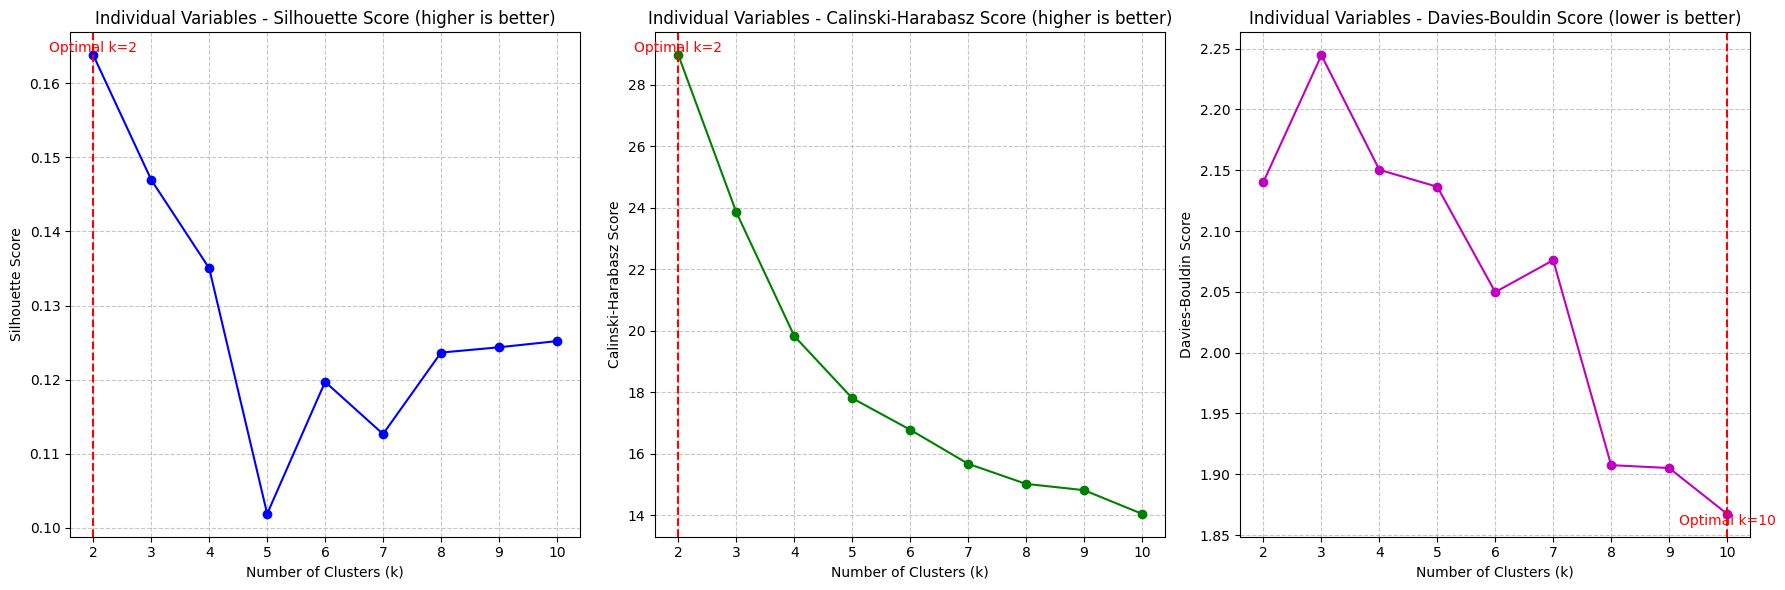


Performing clustering with individual approach (k=5)...
Cluster sizes:
cluster_individual
0    43
1    26
2    36
3    25
4    29
dtype: int64

Top 5 most important features for each cluster:

Cluster 0:
  facilities_within_30min_scaled: -1.3873
  primary_care_nearby_scaled: -1.2858
  er_nearby_scaled: -1.1943
  Gender: 1.0000
  urgent_care_nearby_scaled: -0.9519

Cluster 1:
  facilities_within_10miles_scaled: -1.0652
  Gender: 1.0000
  age_group_18-44: 0.8846
  urgent_care_nearby_scaled: 0.6489
  facilities_within_30min_scaled: 0.6211

Cluster 2:
  Gender: 1.0000
  facilities_within_10miles_scaled: 0.9474
  age_group_18-44: 0.9167
  employed_binary: 0.6667
  food_insecure_binary_scaled: -0.6620

Cluster 3:
  chronic_cond_binary_scaled: 1.8158
  Gender: 1.0000
  poor_qol_scaled: 0.7587
  age_group_18-44: 0.6000
  employed_binary: 0.6000

Cluster 4:
  house_insecure_binary_scaled: 1.5137
  food_insecure_binary_scaled: 1.2026
  Gender: 1.0000
  age_group_18-44: 0.8276
  facilities_withi

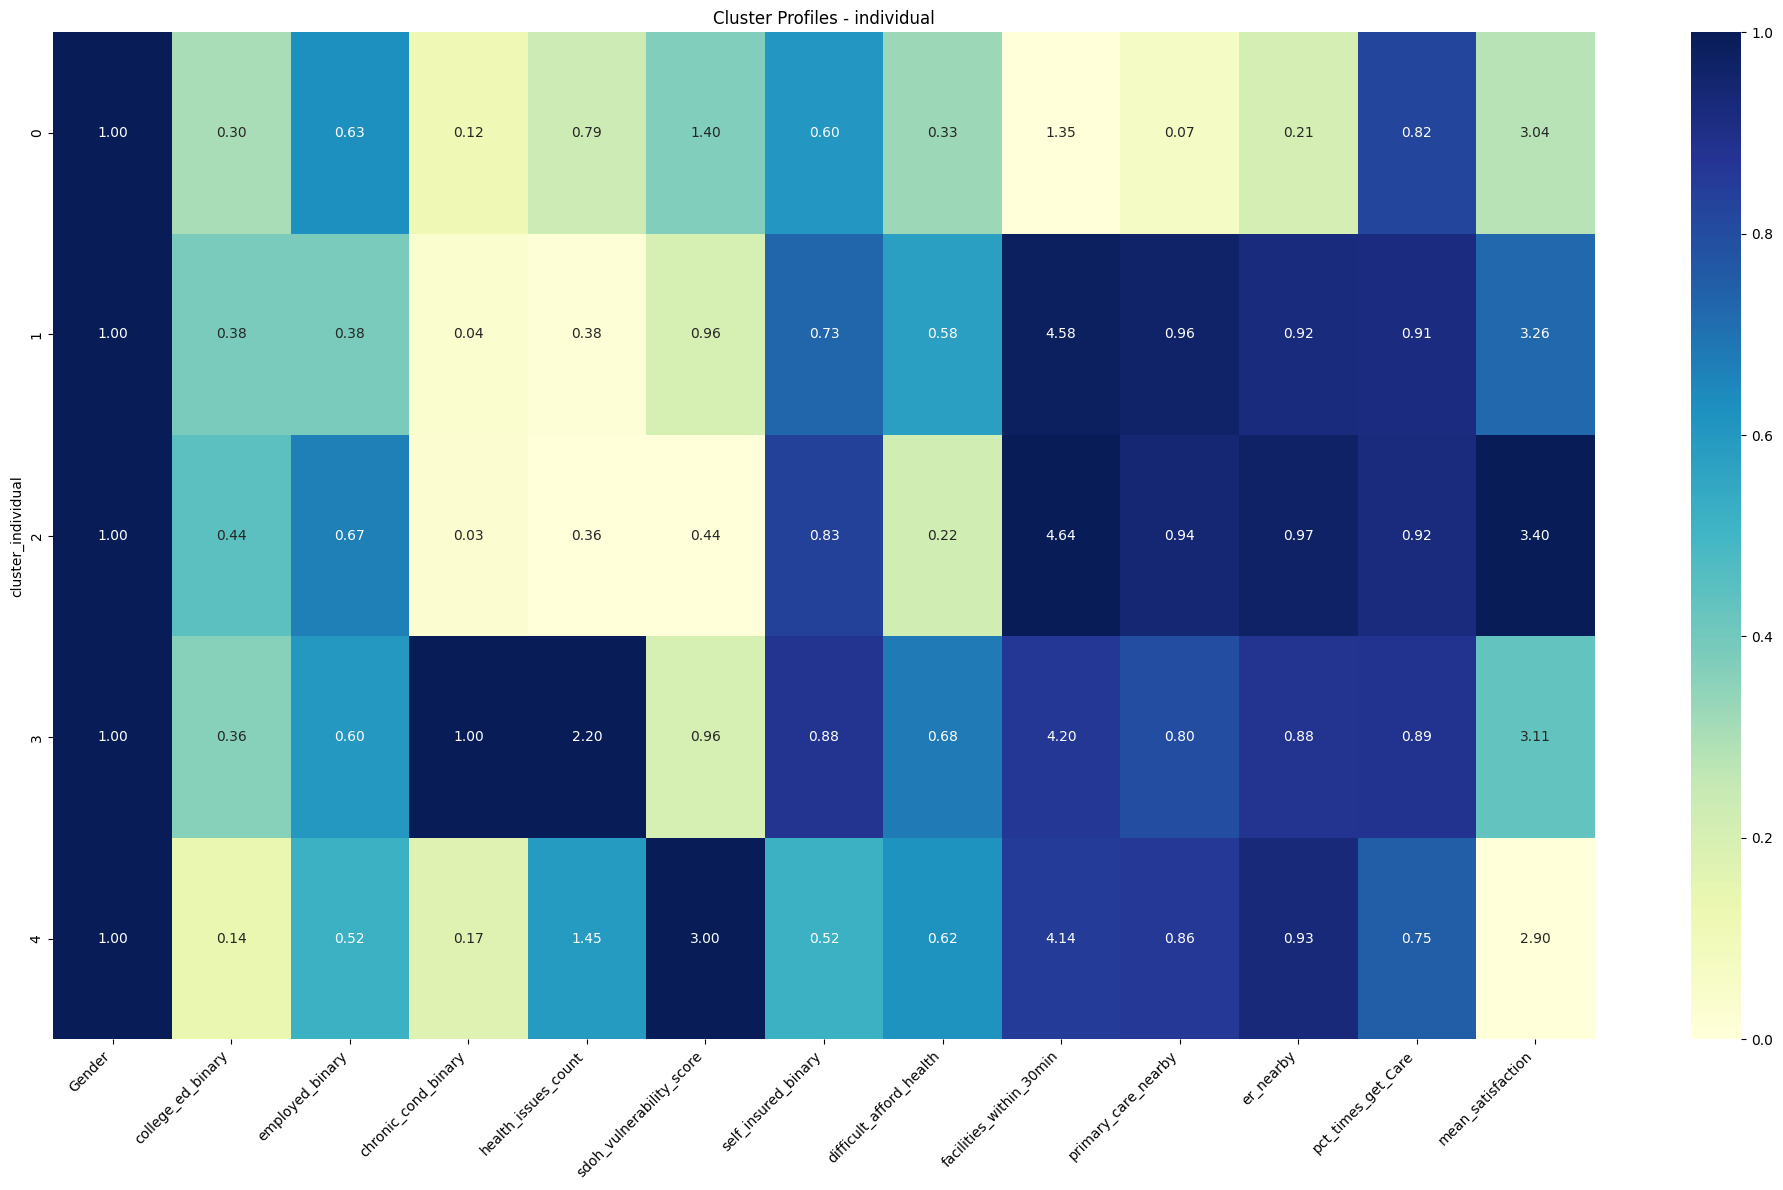

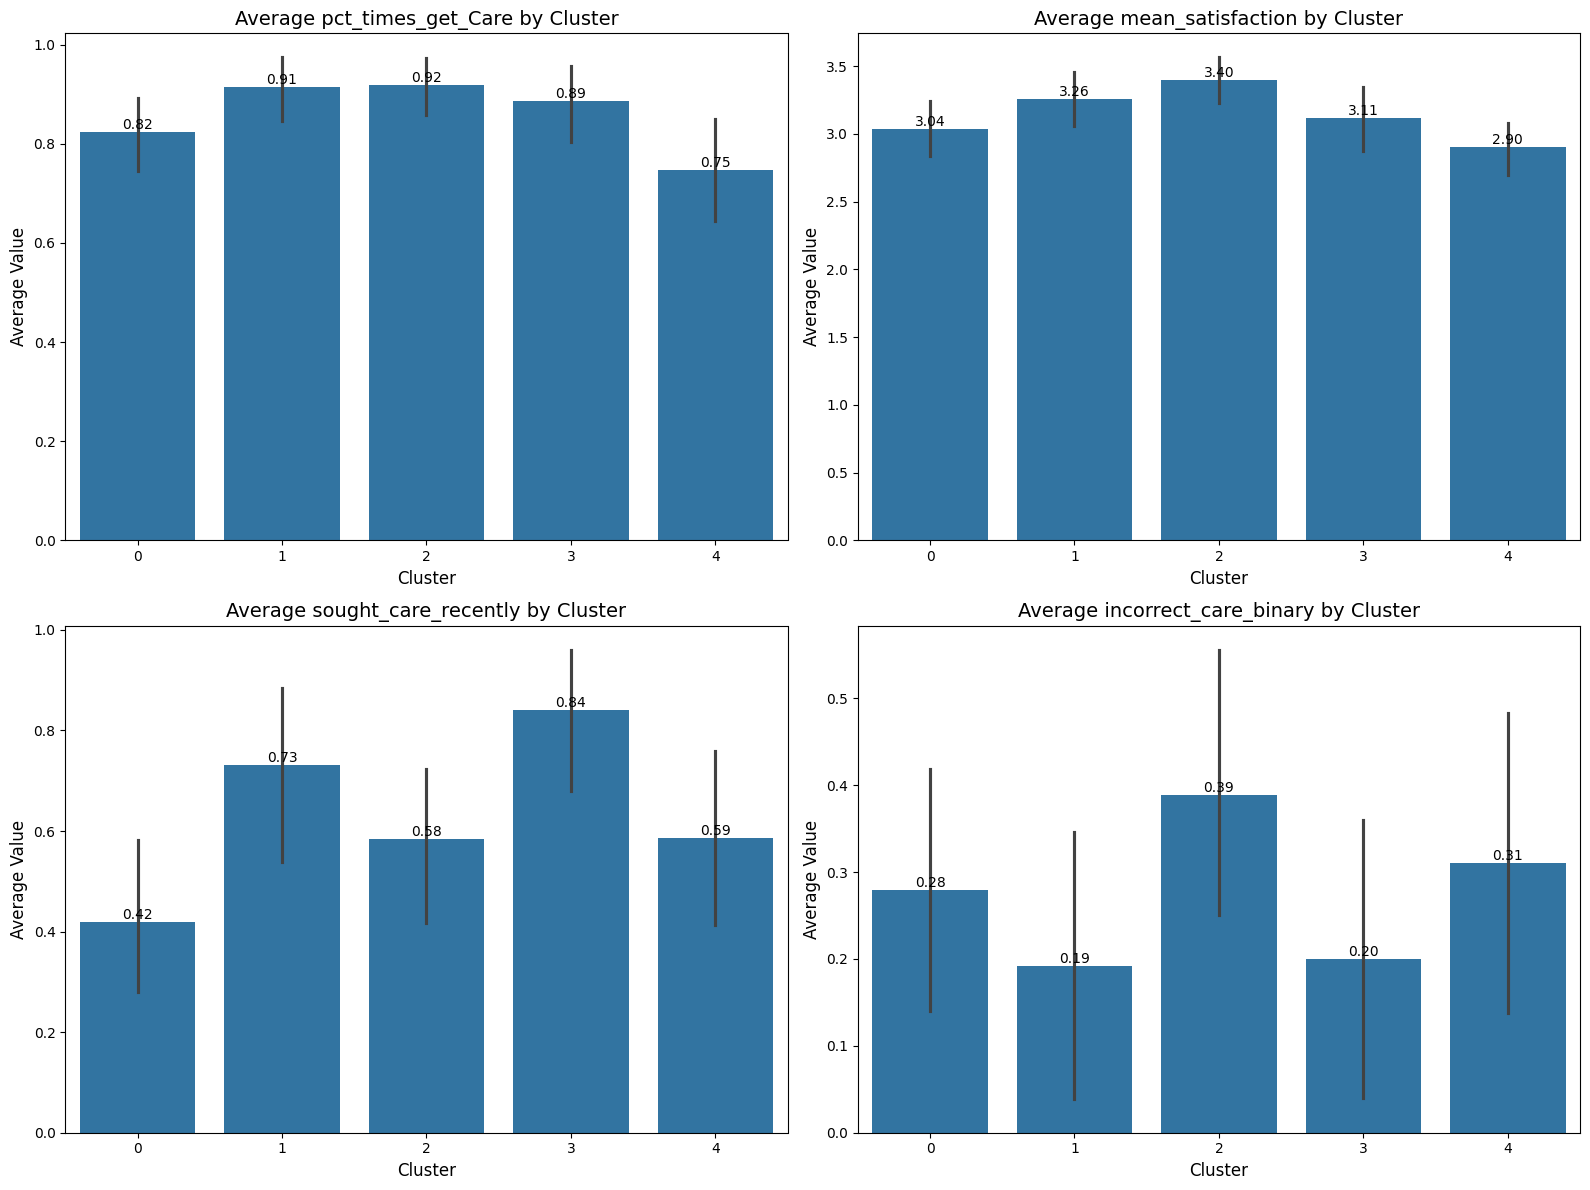


Finding representative individuals for each cluster...

Cluster 0 representative individuals:
           Response ID age_group  Gender  chronic_cond_binary  \
29   R_1dtsPVEW2k1EILM     18-44       1                    0   
34   R_2AKfoJ2aeNjtwke     18-44       1                    0   
141  R_2f9vLYipDXOhlWG     18-44       1                    0   
89   R_UELp1WUB9ECddHX     18-44       1                    0   
28   R_1mIVYUqDE1nN5Gz     18-44       1                    0   

     health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
29                     0                         1                    1   
34                     0                         2                    1   
141                    0                         2                    1   
89                     0                         0                    1   
28                     0                         0                    1   

     facilities_within_30min  pct_times_get_Care  mean_satisfac

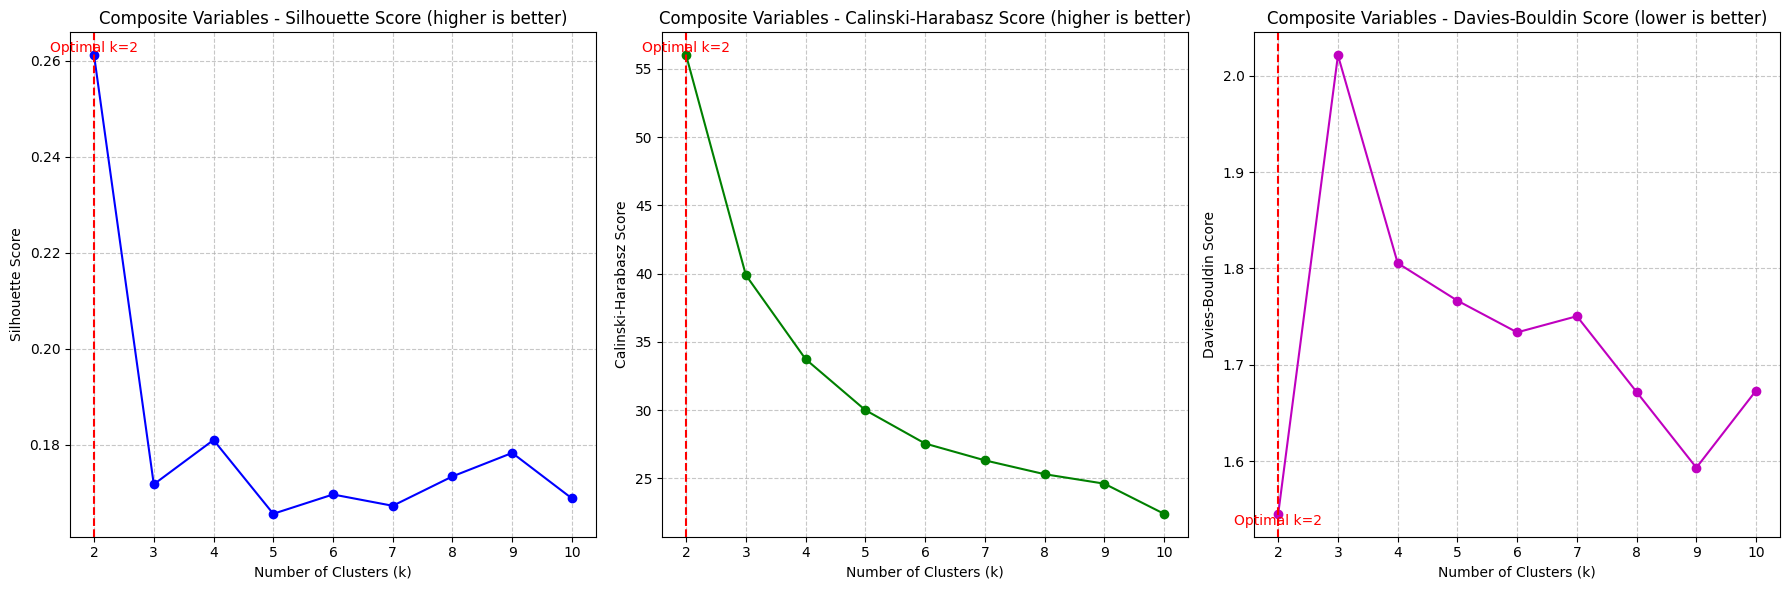


Performing clustering with composite approach (k=5)...
Cluster sizes:
cluster_composite
0    21
1    37
2    50
3    29
4    22
dtype: int64

Top 5 most important features for each cluster:

Cluster 0:
  self_insured_binary_scaled: -1.5437
  Gender: 1.0000
  facilities_within_10miles_scaled: -0.8155
  age_group_18-44: 0.8095
  difficult_afford_health_scaled: 0.7166

Cluster 1:
  facilities_within_30min_scaled: -1.5202
  er_nearby_scaled: -1.4851
  primary_care_nearby_scaled: -1.3192
  Gender: 1.0000
  urgent_care_nearby_scaled: -0.8827

Cluster 2:
  Gender: 1.0000
  age_group_18-44: 0.8800
  sdoh_vulnerability_score_scaled: -0.7137
  employed_binary: 0.6600
  facilities_within_30min_scaled: 0.5857

Cluster 3:
  health_issues_count_scaled: 1.1303
  Gender: 1.0000
  self_insured_binary_scaled: 0.6478
  age_group_18-44: 0.6207
  difficult_afford_health_scaled: 0.6143

Cluster 4:
  facilities_within_10miles_scaled: 1.2367
  Gender: 1.0000
  age_group_18-44: 1.0000
  urgent_care_nearby_sca

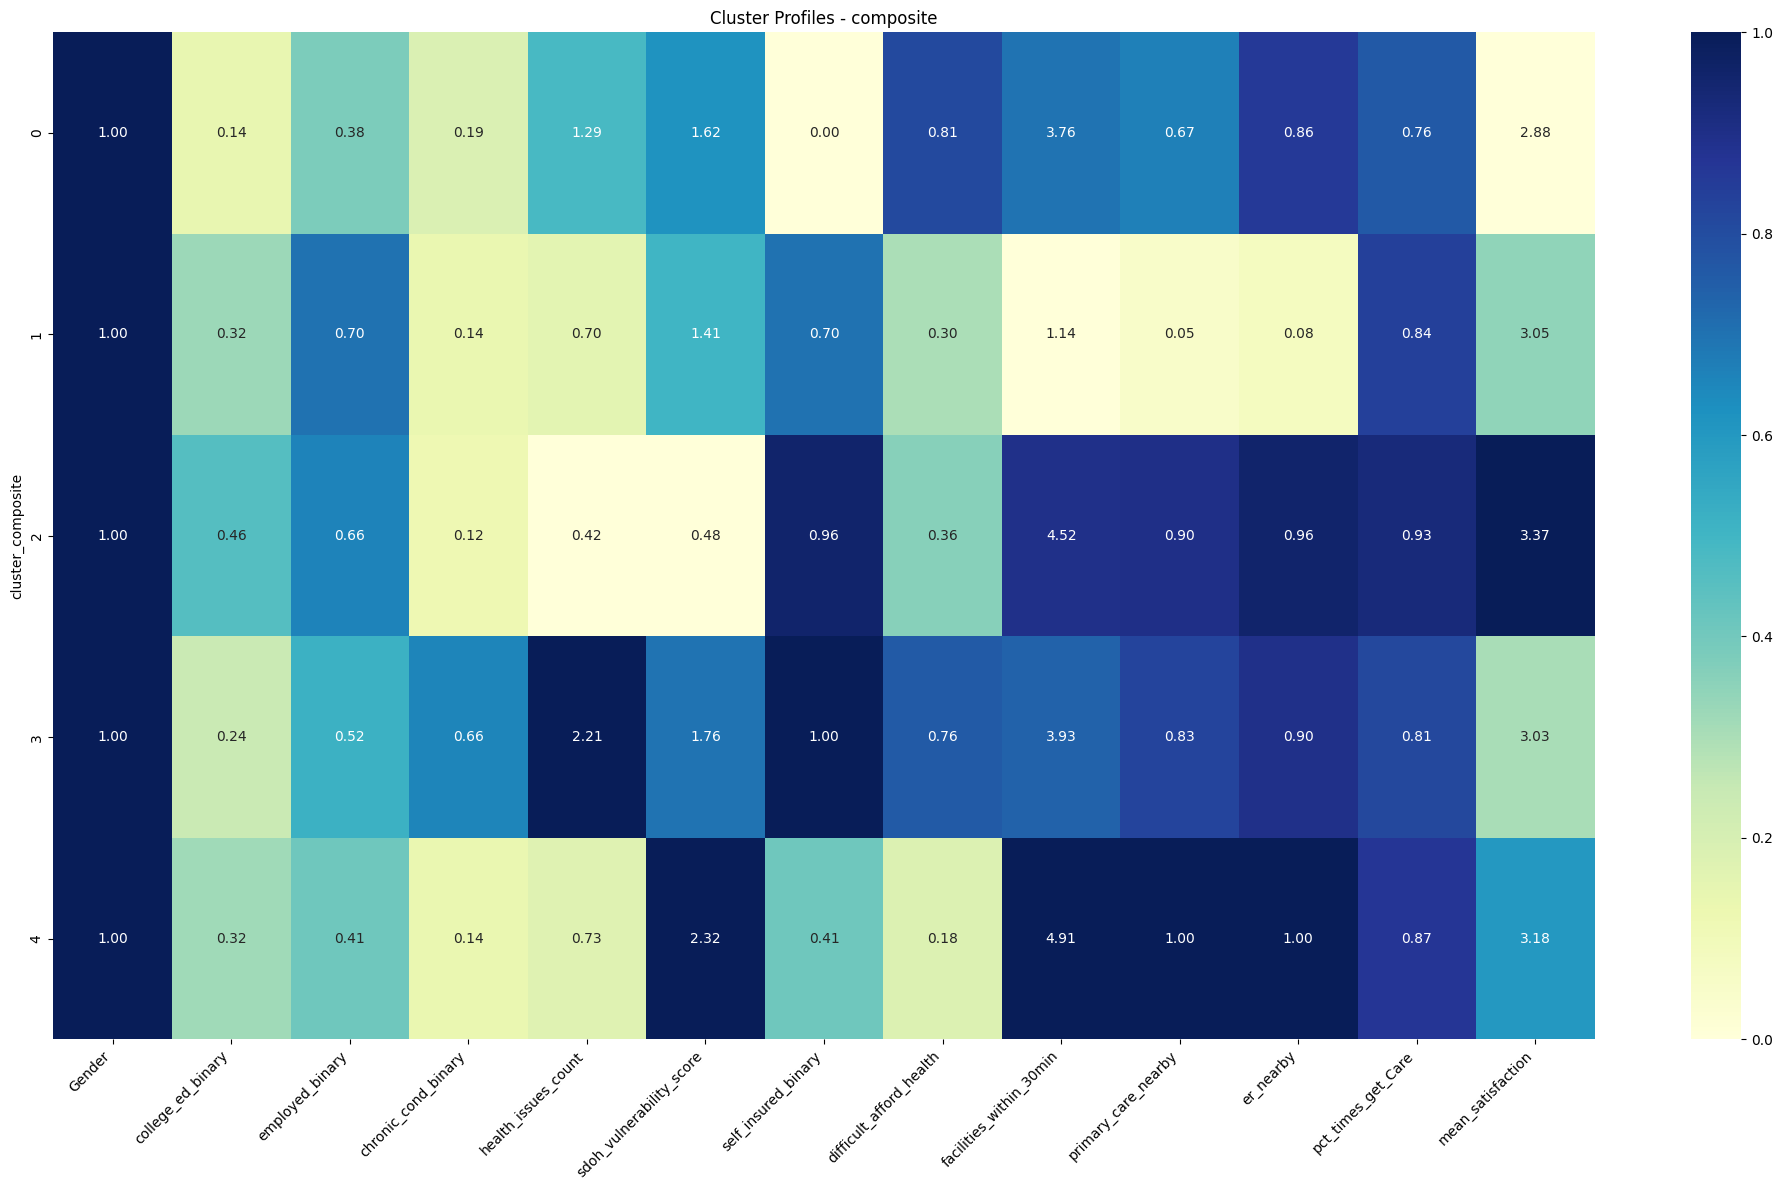

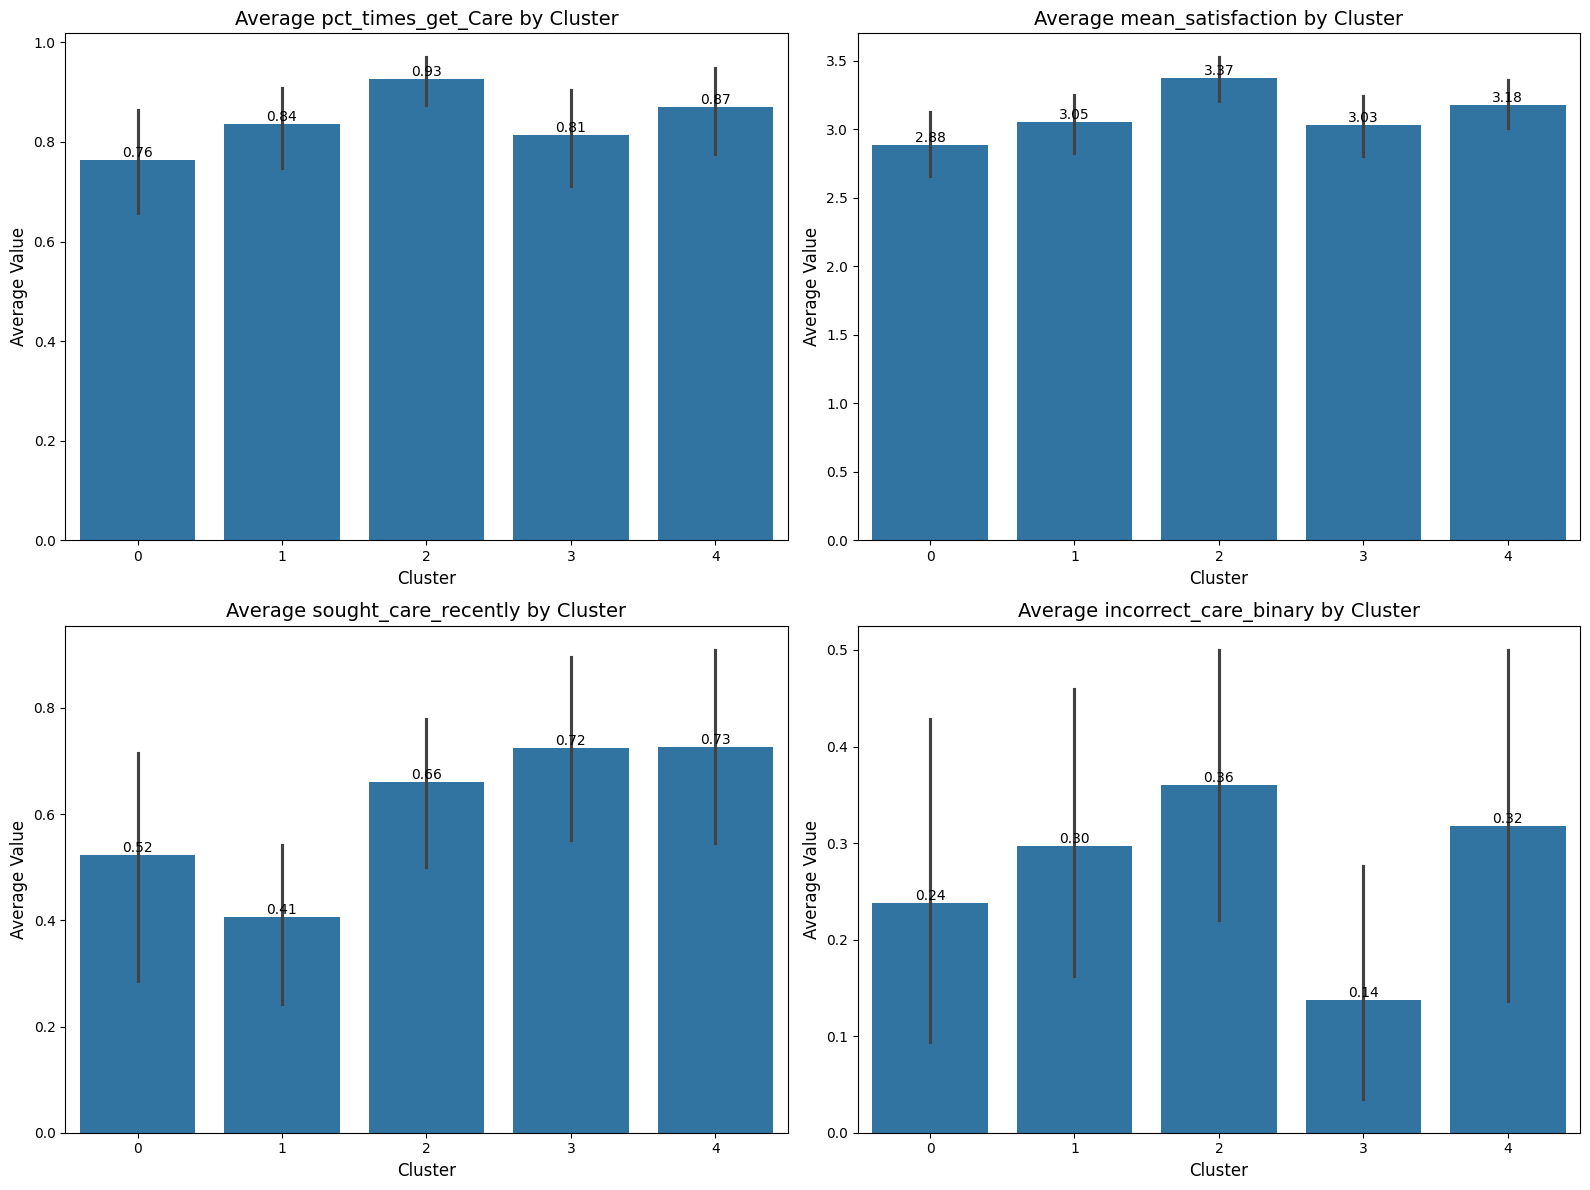


Finding representative individuals for each cluster...

Cluster 0 representative individuals:
           Response ID age_group  Gender  chronic_cond_binary  \
113  R_3FQdXF4s1Q9j8rQ     18-44       1                    0   
99   R_DqwGZbTWQAt0NuV     18-44       1                    0   
50   R_2Qmm1hWV9bxReB8     18-44       1                    0   
23   R_3J4bCk0d2JDQgO6     18-44       1                    0   
45   R_3EjopXbRykF7Gtb     18-44       1                    0   

     health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
113                    1                         2                    0   
99                     1                         2                    0   
50                     1                         2                    0   
23                     1                         1                    0   
45                     2                         3                    0   

     facilities_within_30min  pct_times_get_Care  mean_satisfac

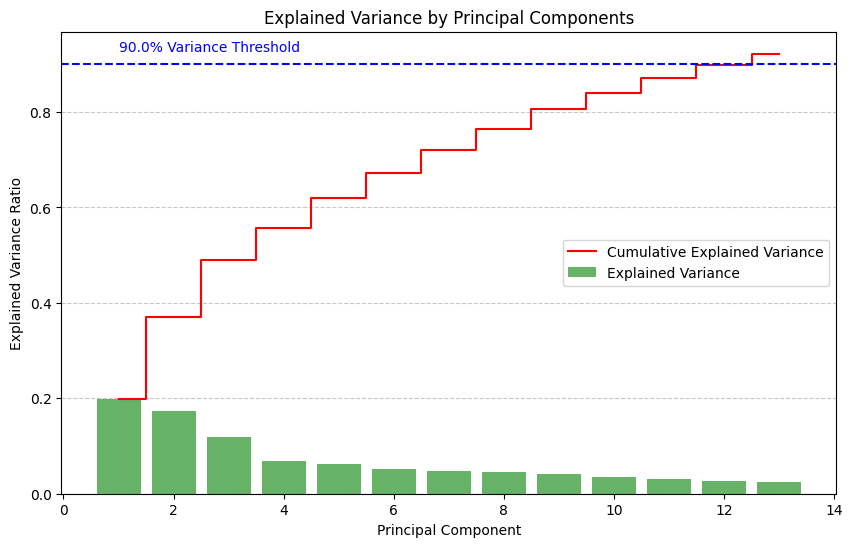

<Figure size 1200x1000 with 0 Axes>

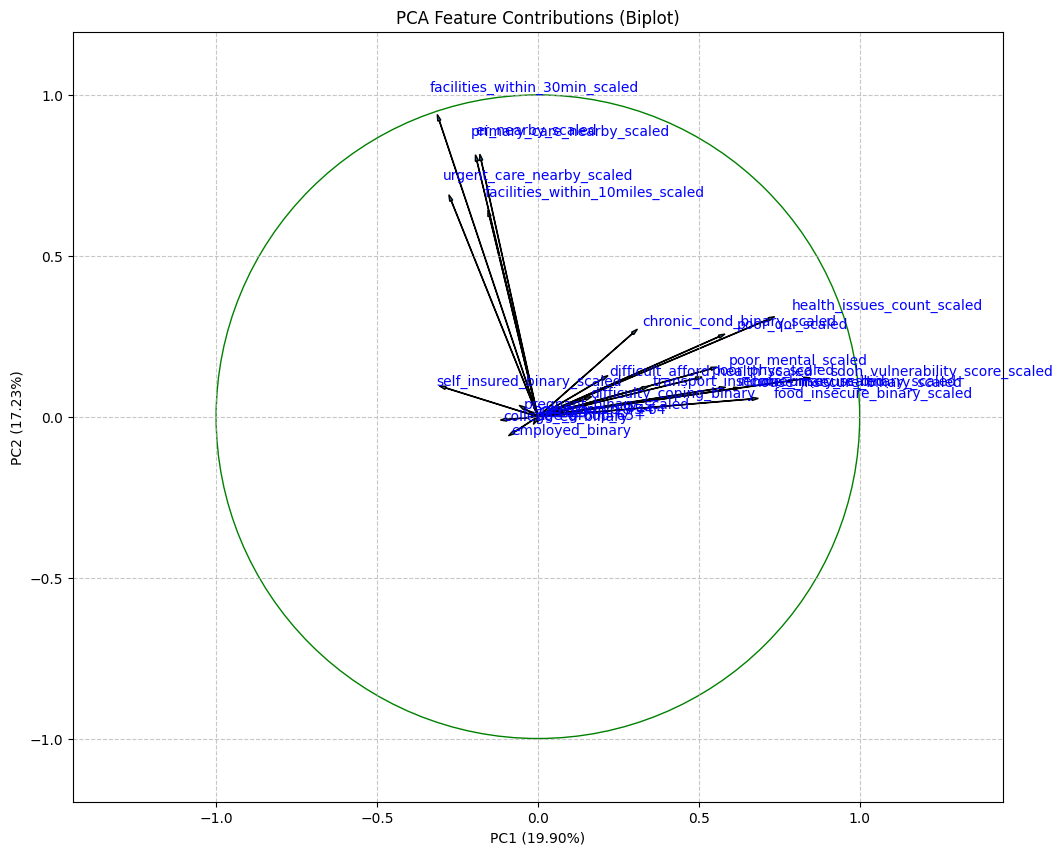

Finding optimal number of clusters from 2 to 10...
For k=2: Silhouette=0.1749, CH-Score=30.04, DB-Score=2.2451
For k=3: Silhouette=0.1674, CH-Score=28.51, DB-Score=1.9499
For k=4: Silhouette=0.1548, CH-Score=25.68, DB-Score=1.8831
For k=5: Silhouette=0.1540, CH-Score=23.41, DB-Score=1.8221
For k=6: Silhouette=0.1505, CH-Score=21.72, DB-Score=1.7681
For k=7: Silhouette=0.1369, CH-Score=19.70, DB-Score=1.8405
For k=8: Silhouette=0.1479, CH-Score=19.31, DB-Score=1.7727
For k=9: Silhouette=0.1396, CH-Score=18.18, DB-Score=1.8139
For k=10: Silhouette=0.1457, CH-Score=17.52, DB-Score=1.7255


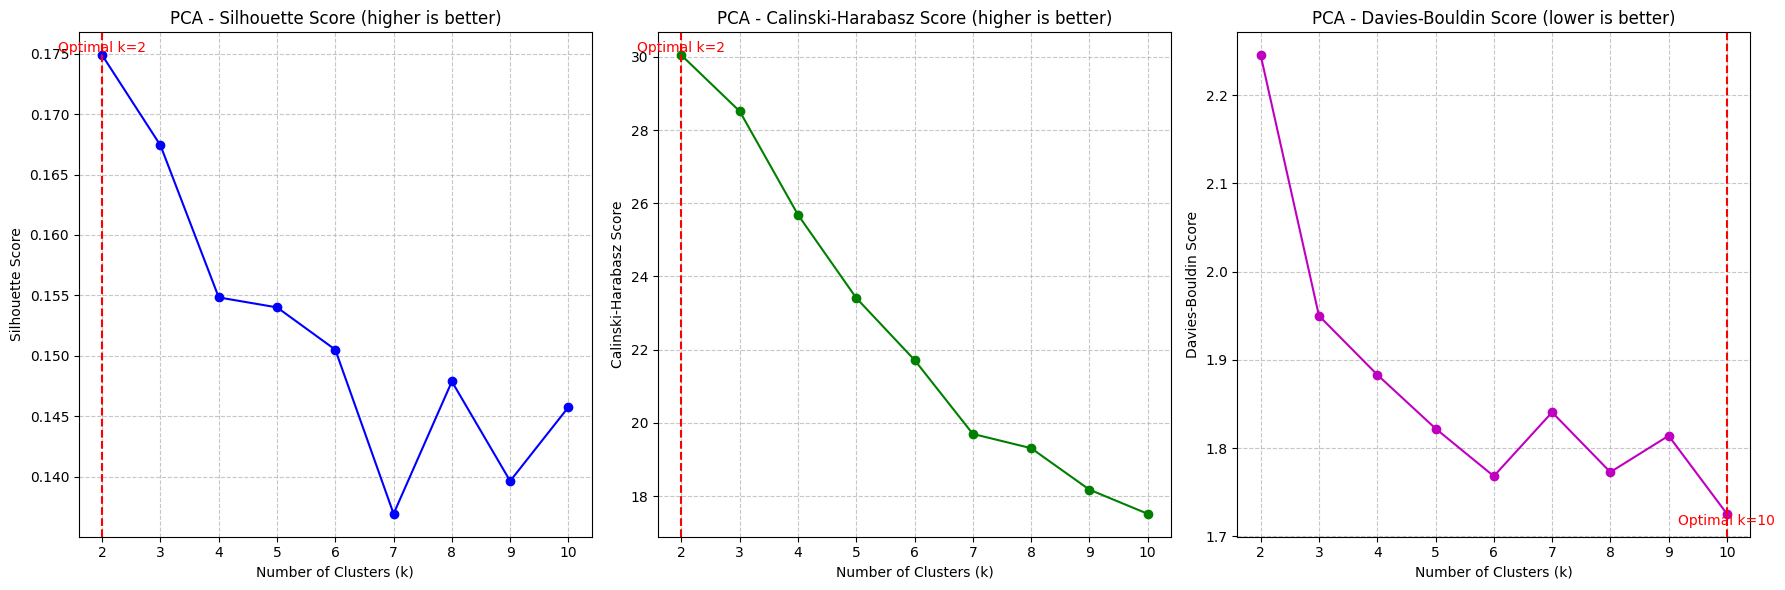


Performing clustering with pca approach (k=5)...
Cluster sizes:
cluster_pca
0    23
1    34
2    30
3    16
4    56
dtype: int64

Top 5 most important features for each cluster:

Cluster 0:
  PC3: 1.7082
  PC2: 1.2147
  PC9: -0.8283
  PC5: -0.5299
  PC10: 0.4081

Cluster 1:
  PC2: -2.7593
  PC3: -0.2809
  PC9: -0.2774
  PC4: -0.2362
  PC12: 0.1998

Cluster 2:
  PC1: 1.7158
  PC3: -1.4074
  PC2: 0.8912
  PC4: 0.7294
  PC6: -0.4240

Cluster 3:
  PC1: 3.0699
  PC3: 1.6890
  PC9: 1.1063
  PC4: -0.8346
  PC6: 0.7422

Cluster 4:
  PC1: -1.7744
  PC2: 0.5874
  PC9: 0.2679
  PC3: -0.2596
  PC5: 0.1169

Generating cluster profiles based on original values...

Cluster Profiles:
            age_group  Gender  college_ed_binary  employed_binary  \
cluster_pca                                                         
0               18-44     1.0           0.434783         0.521739   
1               18-44     1.0           0.323529         0.617647   
2               18-44     1.0           0.1666

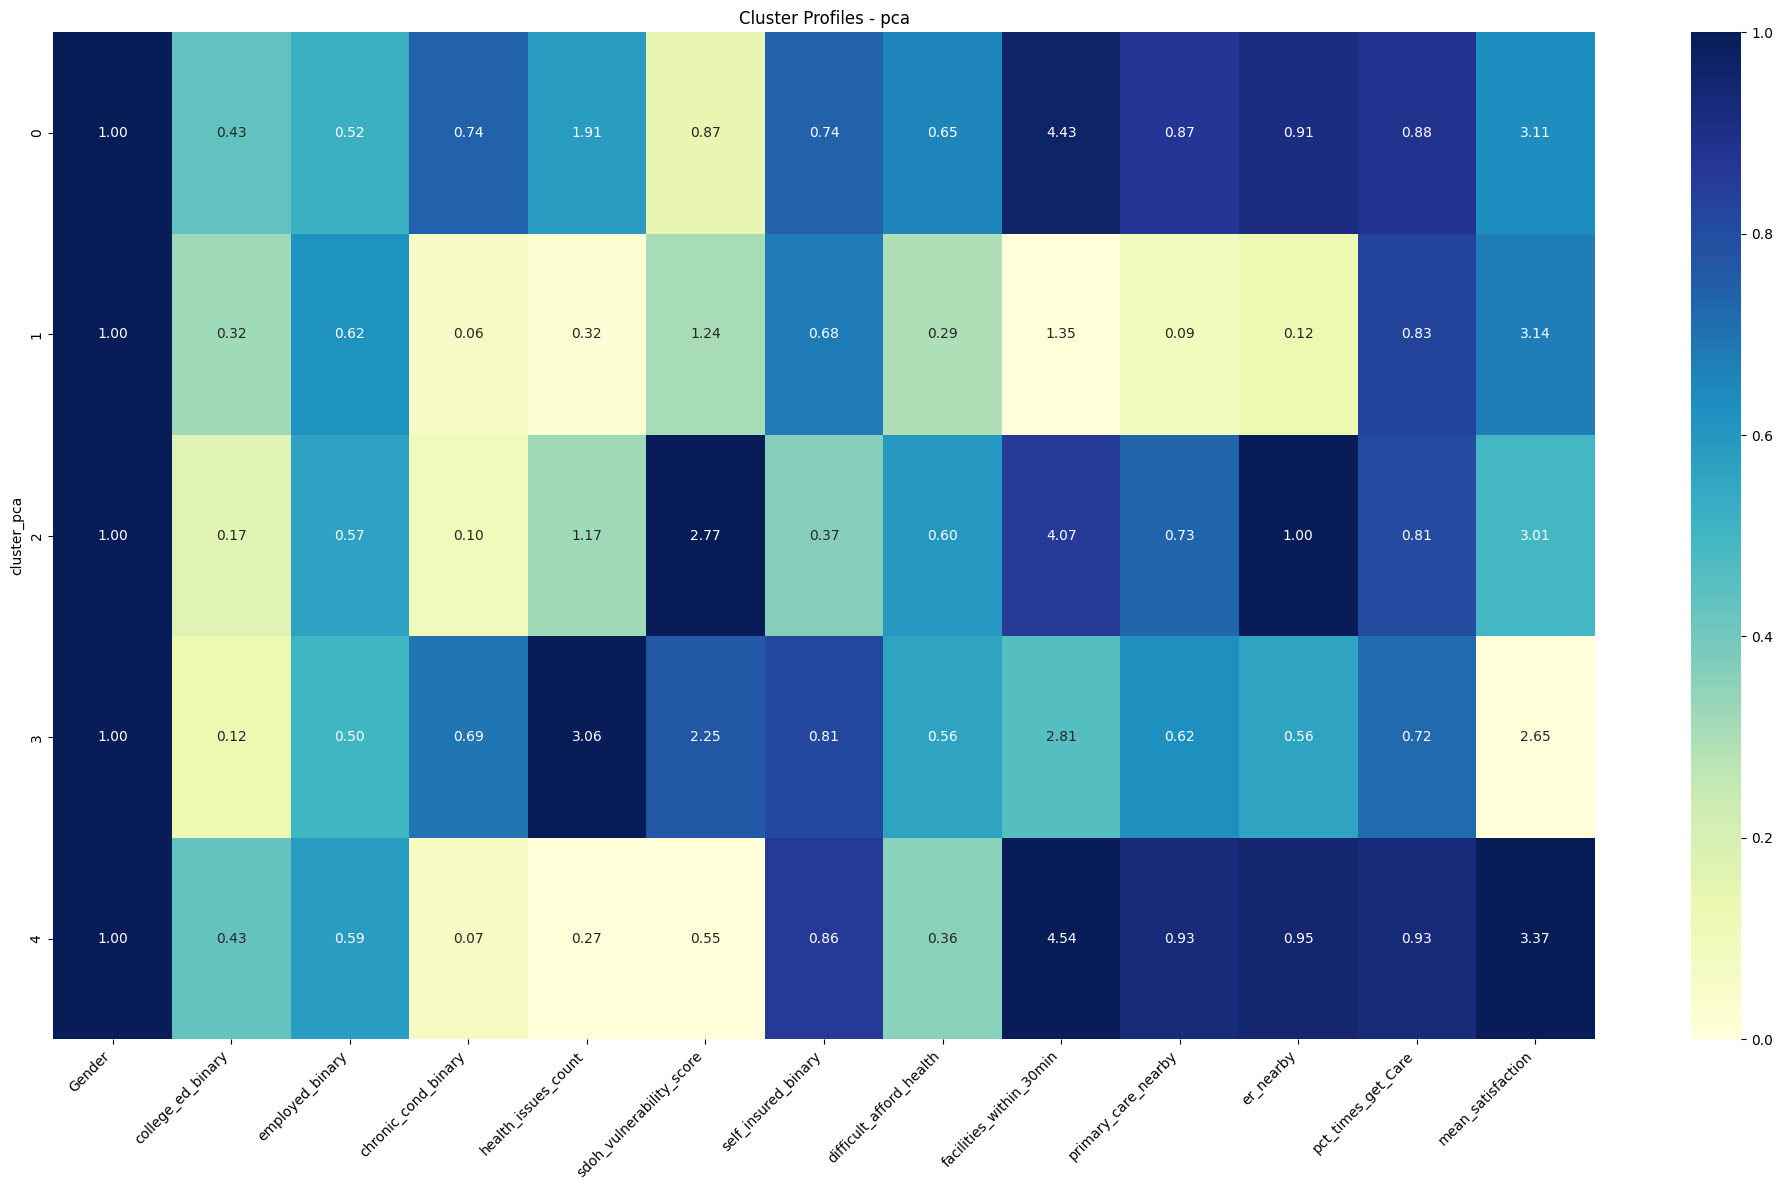

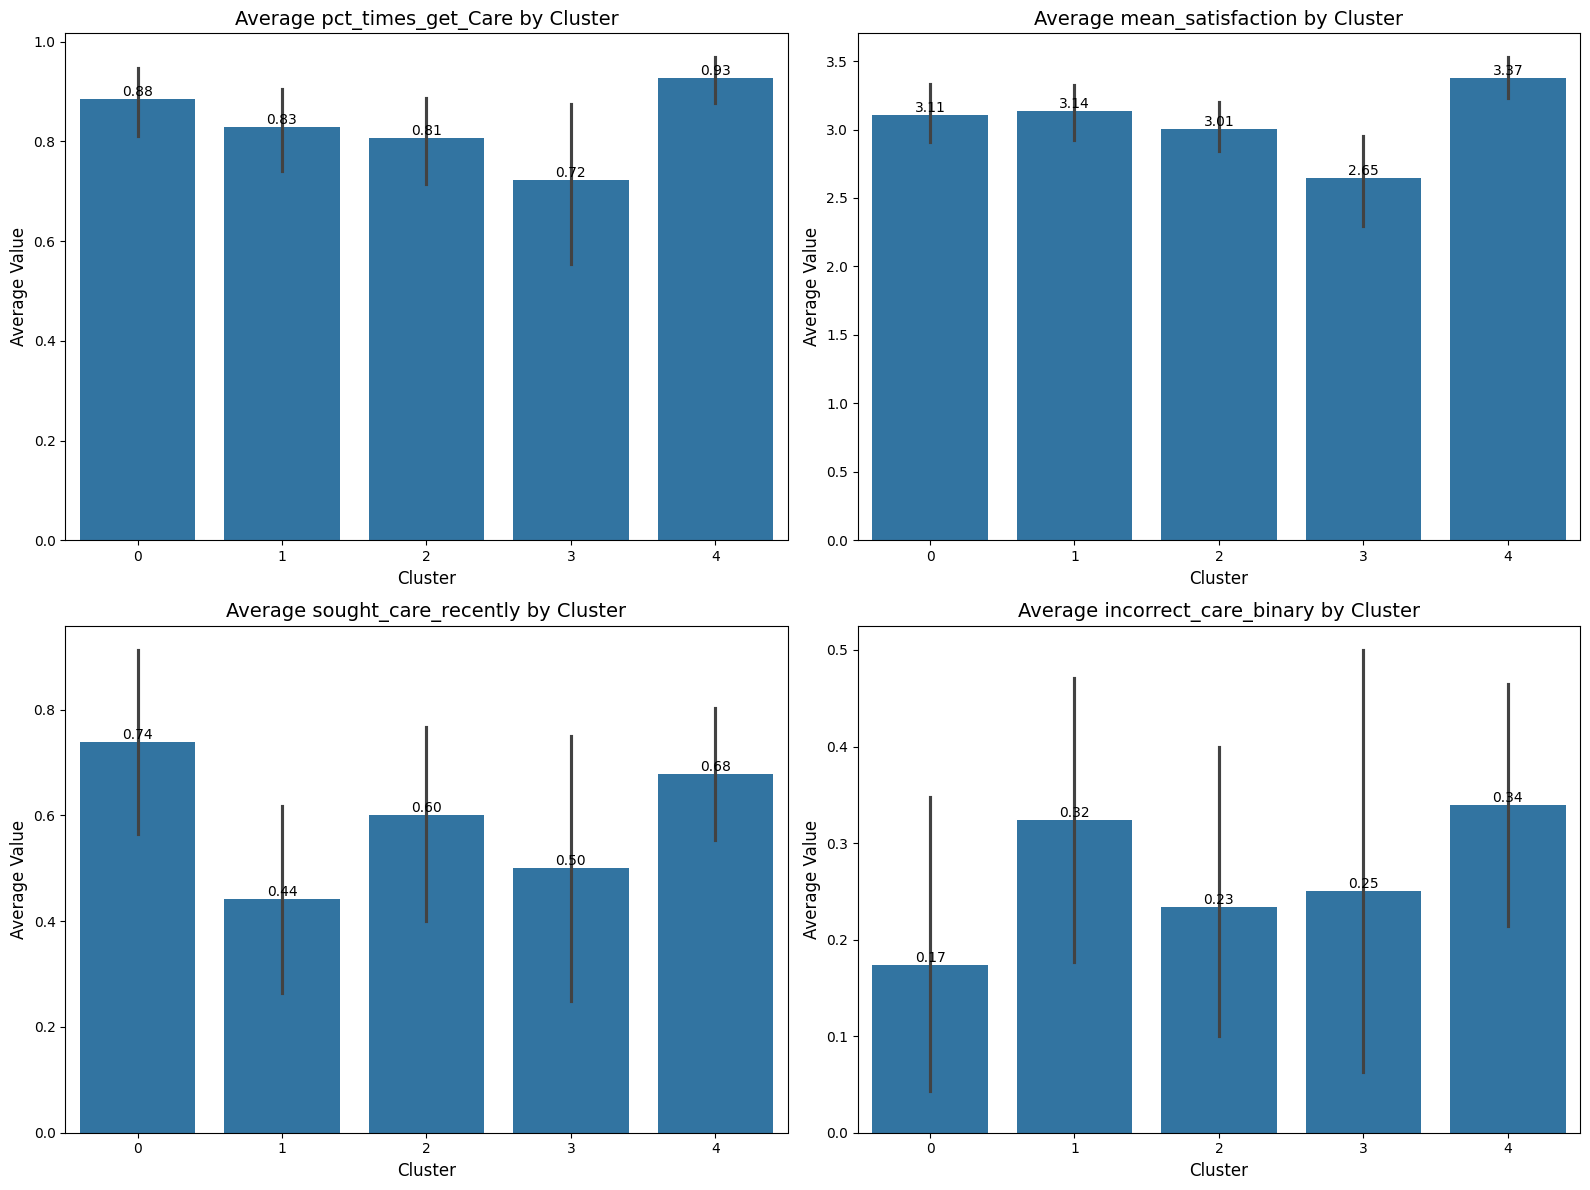


Finding representative individuals for each cluster...

Cluster 0 representative individuals:
           Response ID age_group  Gender  chronic_cond_binary  \
90   R_1NsOHqSjbUjR1OK     45-64       1                    1   
115  R_2uDMvRTtibmanCB     18-44       1                    1   
36   R_3FUOfvh4EauTEzB     18-44       1                    1   
150  R_CfRoqWtidjWXvCV     18-44       1                    1   
112  R_20M7PPc4QVIa7eO     45-64       1                    1   

     health_issues_count  sdoh_vulnerability_score  self_insured_binary  \
90                     2                         1                    1   
115                    2                         1                    1   
36                     2                         0                    1   
150                    2                         1                    1   
112                    2                         0                    1   

     facilities_within_30min  pct_times_get_Care  mean_satisfac

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Load the dataset
print("Loading the dataset...")
df = pd.read_csv('cluster_data_.csv')

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")

# Define variable categories to avoid double counting
demographic_vars = ['Gender', 'college_ed_binary', 'employed_binary']
health_individual_vars = ['chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol']
health_composite_vars = ['health_issues_count']
sdoh_individual_vars = ['food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary']
sdoh_composite_vars = ['sdoh_vulnerability_score']
access_vars = ['self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
               'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby']
coping_vars = ['difficulty_coping_binary']
outcome_vars = ['sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction', 'incorrect_care_binary']

# Create two separate sets of variables to avoid double counting
# Approach 1: Use individual variables for health and social determinants
individual_vars = demographic_vars + health_individual_vars + sdoh_individual_vars + access_vars + coping_vars

# Approach 2: Use composite variables for health and social determinants
composite_vars = demographic_vars + health_composite_vars + sdoh_composite_vars + access_vars + coping_vars

# Standardize all numerical variables
print("Standardizing variables...")
scaler = StandardScaler()
df_scaled = df.copy()

# One-hot encode age_group
print("One-hot encoding categorical variables...")
df_scaled = pd.get_dummies(df_scaled, columns=['age_group'], drop_first=False)
age_vars = [col for col in df_scaled.columns if col.startswith('age_group_')]

# Add age variables to both approaches
individual_vars = individual_vars + age_vars
composite_vars = composite_vars + age_vars

# Scale numerical variables
all_numeric_vars = (health_individual_vars + health_composite_vars + sdoh_individual_vars +
                    sdoh_composite_vars + access_vars + outcome_vars)
all_numeric_vars = [var for var in all_numeric_vars if var in df.columns]

for var in all_numeric_vars:
    df_scaled[f'{var}_scaled'] = scaler.fit_transform(df[[var]])

# Update variable lists to use scaled versions
individual_vars_scaled = [var + '_scaled' if var in all_numeric_vars else var for var in individual_vars]
composite_vars_scaled = [var + '_scaled' if var in all_numeric_vars else var for var in composite_vars]

# Define a function to evaluate clustering performance with multiple metrics
def evaluate_clusters(X, labels):
    """
    Evaluate clustering performance using multiple metrics

    Parameters:
    X (array): Feature matrix
    labels (array): Cluster labels

    Returns:
    dict: Dictionary of evaluation metrics
    """
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    db_score = davies_bouldin_score(X, labels)

    return {
        'silhouette': silhouette,
        'calinski_harabasz': ch_score,
        'davies_bouldin': db_score
    }

# Function to find optimal number of clusters using multiple metrics
def find_optimal_clusters(X, max_k=10, min_k=2):
    """
    Find optimal number of clusters using multiple metrics

    Parameters:
    X (array): Feature matrix
    max_k (int): Maximum number of clusters to try
    min_k (int): Minimum number of clusters to try

    Returns:
    dict: Dictionary with evaluation results for each k
    """
    print(f"Finding optimal number of clusters from {min_k} to {max_k}...")
    results = {}

    for k in range(min_k, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        # Evaluate clustering
        eval_metrics = evaluate_clusters(X, labels)
        results[k] = eval_metrics

        print(f"For k={k}: Silhouette={eval_metrics['silhouette']:.4f}, "
              f"CH-Score={eval_metrics['calinski_harabasz']:.2f}, "
              f"DB-Score={eval_metrics['davies_bouldin']:.4f}")

    return results

# Function to plot evaluation metrics
def plot_cluster_evaluation(results, title_prefix=""):
    """
    Plot evaluation metrics for different numbers of clusters

    Parameters:
    results (dict): Dictionary with evaluation results
    title_prefix (str): Prefix for plot titles
    """
    k_values = list(results.keys())

    # Prepare data for plotting
    silhouette_scores = [results[k]['silhouette'] for k in k_values]
    ch_scores = [results[k]['calinski_harabasz'] for k in k_values]
    db_scores = [results[k]['davies_bouldin'] for k in k_values]

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Silhouette scores
    axes[0].plot(k_values, silhouette_scores, 'bo-')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title(f'{title_prefix}Silhouette Score (higher is better)')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Mark optimal k for Silhouette
    optimal_k_silhouette = k_values[silhouette_scores.index(max(silhouette_scores))]
    axes[0].axvline(x=optimal_k_silhouette, color='r', linestyle='--')
    axes[0].text(optimal_k_silhouette, max(silhouette_scores),
                f'Optimal k={optimal_k_silhouette}',
                color='r', ha='center', va='bottom')

    # Plot Calinski-Harabasz scores
    axes[1].plot(k_values, ch_scores, 'go-')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Calinski-Harabasz Score')
    axes[1].set_title(f'{title_prefix}Calinski-Harabasz Score (higher is better)')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Mark optimal k for CH
    optimal_k_ch = k_values[ch_scores.index(max(ch_scores))]
    axes[1].axvline(x=optimal_k_ch, color='r', linestyle='--')
    axes[1].text(optimal_k_ch, max(ch_scores),
                f'Optimal k={optimal_k_ch}',
                color='r', ha='center', va='bottom')

    # Plot Davies-Bouldin scores
    axes[2].plot(k_values, db_scores, 'mo-')
    axes[2].set_xlabel('Number of Clusters (k)')
    axes[2].set_ylabel('Davies-Bouldin Score')
    axes[2].set_title(f'{title_prefix}Davies-Bouldin Score (lower is better)')
    axes[2].grid(True, linestyle='--', alpha=0.7)

    # Mark optimal k for DB
    optimal_k_db = k_values[db_scores.index(min(db_scores))]
    axes[2].axvline(x=optimal_k_db, color='r', linestyle='--')
    axes[2].text(optimal_k_db, min(db_scores),
                f'Optimal k={optimal_k_db}',
                color='r', ha='center', va='top')

    plt.tight_layout()
    plt.savefig(f'{title_prefix.strip()}_cluster_evaluation.png')
    plt.show()

    return {'silhouette': optimal_k_silhouette, 'ch': optimal_k_ch, 'db': optimal_k_db}

# Function to perform clustering and analyze results
def perform_clustering(X, optimal_k, feature_names, approach_name, df_original):
    """
    Perform K-means clustering and analyze results

    Parameters:
    X (array): Feature matrix
    optimal_k (int): Number of clusters
    feature_names (list): Names of features used
    approach_name (str): Name of clustering approach
    df_original (DataFrame): Original dataframe for profiles

    Returns:
    tuple: (df with clusters, kmeans model)
    """
    print(f"\nPerforming clustering with {approach_name} approach (k={optimal_k})...")

    # Apply K-means with optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    # Add cluster labels to the original dataframe
    df_original[f'cluster_{approach_name}'] = cluster_labels

    # Display cluster sizes
    cluster_sizes = df_original.groupby(f'cluster_{approach_name}').size()
    print(f"Cluster sizes:\n{cluster_sizes}")

    # Calculate feature importance for each cluster
    feature_importance = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=feature_names
    )

    # Print top 5 most important features for each cluster
    print("\nTop 5 most important features for each cluster:")
    for cluster in range(optimal_k):
        # For each cluster, get the features with the highest absolute values
        cluster_features = feature_importance.iloc[cluster].abs().sort_values(ascending=False).head(5)
        print(f"\nCluster {cluster}:")
        for feature, value in cluster_features.items():
            # Show the actual direction (+ or -) of the feature
            actual_value = feature_importance.iloc[cluster][feature]
            print(f"  {feature}: {actual_value:.4f}")

    # Generate cluster profiles based on original values
    print("\nGenerating cluster profiles based on original values...")
    profile_vars = ['age_group', 'Gender', 'college_ed_binary', 'employed_binary',
                    'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
                    'health_issues_count', 'food_insecure_binary', 'house_insecure_binary',
                    'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score',
                    'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
                    'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby',
                    'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care',
                    'mean_satisfaction', 'incorrect_care_binary']

    # Get profiles for categorical variables (mode)
    categorical_vars = ['age_group']
    cat_profiles = df_original.groupby(f'cluster_{approach_name}')[categorical_vars].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else None
    )

    # Get profiles for numerical variables (mean)
    numerical_vars = [var for var in profile_vars if var not in categorical_vars]
    num_profiles = df_original.groupby(f'cluster_{approach_name}')[numerical_vars].mean()

    # Combine profiles
    cluster_profiles = pd.concat([cat_profiles, num_profiles], axis=1)

    # Print cluster profiles
    print("\nCluster Profiles:")
    print(cluster_profiles)

    # Save cluster profiles
    cluster_profiles.to_csv(f'cluster_profiles_{approach_name}.csv')

    # Create a heatmap of cluster profiles for key variables
    plt.figure(figsize=(20, 12))
    key_vars = ['Gender', 'college_ed_binary', 'employed_binary',
                'chronic_cond_binary', 'health_issues_count', 'sdoh_vulnerability_score',
                'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
                'primary_care_nearby', 'er_nearby', 'pct_times_get_Care', 'mean_satisfaction']

    # Normalize data for heatmap
    heatmap_data = cluster_profiles[key_vars].copy()
    for col in heatmap_data.columns:
        if heatmap_data[col].max() > 1 or heatmap_data[col].min() < 0:
            heatmap_data[col] = (heatmap_data[col] - heatmap_data[col].min()) / (
                heatmap_data[col].max() - heatmap_data[col].min()
            )

    sns.heatmap(heatmap_data, annot=cluster_profiles[key_vars], fmt='.2f', cmap='YlGnBu')
    plt.title(f'Cluster Profiles - {approach_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'cluster_profiles_heatmap_{approach_name}.png')
    plt.show()

    # Plot outcome variables by cluster
    outcome_variables = ['pct_times_get_Care', 'mean_satisfaction',
                        'sought_care_recently', 'incorrect_care_binary']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, var in enumerate(outcome_variables):
        sns.barplot(x=f'cluster_{approach_name}', y=var, data=df_original, ax=axes[i])
        axes[i].set_title(f'Average {var} by Cluster', fontsize=14)
        axes[i].set_xlabel('Cluster', fontsize=12)
        axes[i].set_ylabel('Average Value', fontsize=12)

        # Add value labels on top of bars
        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height():.2f}',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha = 'center', va = 'bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f'outcome_variables_by_cluster_{approach_name}.png')
    plt.show()

    # Find representative individuals for each cluster (5 closest to centroid)
    print("\nFinding representative individuals for each cluster...")

    # Calculate distance of each point to its cluster centroid
    distances = np.zeros((X.shape[0], optimal_k))
    for i in range(optimal_k):
        # Calculate Euclidean distance to cluster centroid
        distances[:, i] = np.sqrt(((X - kmeans.cluster_centers_[i]) ** 2).sum(axis=1))

    # For each cluster, find the 5 closest points to the centroid
    for i in range(optimal_k):
        cluster_indices = np.where(cluster_labels == i)[0]
        # Sort indices by distance to centroid
        sorted_indices = cluster_indices[np.argsort(distances[cluster_indices, i])]
        # Get the 5 closest points
        closest_indices = sorted_indices[:5]

        print(f"\nCluster {i} representative individuals:")
        representative_samples = df_original.iloc[closest_indices]
        print(representative_samples[['Response ID', 'age_group', 'Gender', 'chronic_cond_binary',
                                     'health_issues_count', 'sdoh_vulnerability_score',
                                     'self_insured_binary', 'facilities_within_30min',
                                     'pct_times_get_Care', 'mean_satisfaction']])

    # Generate narrative descriptions of each cluster
    print("\nNarrative description of each cluster:")
    for i in range(optimal_k):
        cluster_df = df_original[df_original[f'cluster_{approach_name}'] == i]

        # Calculate key statistics
        n = len(cluster_df)
        pct = n / len(df_original) * 100

        # Demographics
        age_mode = cluster_df['age_group'].mode()[0] if not cluster_df['age_group'].mode().empty else "Unknown"
        gender_pct = cluster_df['Gender'].mean() * 100  # 1=Female, 0=Male
        edu_pct = cluster_df['college_ed_binary'].mean() * 100
        emp_pct = cluster_df['employed_binary'].mean() * 100

        # Health status
        chronic_pct = cluster_df['chronic_cond_binary'].mean() * 100
        health_issues = cluster_df['health_issues_count'].mean()

        # Social determinants
        sdoh_score = cluster_df['sdoh_vulnerability_score'].mean()
        food_pct = cluster_df['food_insecure_binary'].mean() * 100
        housing_pct = cluster_df['house_insecure_binary'].mean() * 100
        transport_pct = cluster_df['transport_insecure_binary'].mean() * 100
        income_pct = cluster_df['income_insecure_binary'].mean() * 100

        # Healthcare access
        insured_pct = cluster_df['self_insured_binary'].mean() * 100
        afford_pct = cluster_df['difficult_afford_health'].mean() * 100
        facilities_30min = cluster_df['facilities_within_30min'].mean()
        primary_nearby_pct = cluster_df['primary_care_nearby'].mean() * 100
        er_nearby_pct = cluster_df['er_nearby'].mean() * 100

        # Outcomes
        care_pct = cluster_df['pct_times_get_Care'].mean() * 100
        satisfaction = cluster_df['mean_satisfaction'].mean()

        print(f"\nCluster {i} ({n} individuals, {pct:.1f}% of sample):")
        print(f"Demographic Profile: Predominantly {age_mode} age group, {gender_pct:.1f}% female, "
              f"{edu_pct:.1f}% college educated, {emp_pct:.1f}% employed.")

        print(f"Health Status: {chronic_pct:.1f}% have chronic conditions with an average of "
              f"{health_issues:.1f} health issues per person.")

        print(f"Social Vulnerabilities: Average vulnerability score of {sdoh_score:.1f} out of 4, "
              f"with {food_pct:.1f}% food insecure, {housing_pct:.1f}% housing insecure, "
              f"{transport_pct:.1f}% transportation insecure, and {income_pct:.1f}% income insecure.")

        print(f"Healthcare Access: {insured_pct:.1f}% self-insured, {afford_pct:.1f}% report difficulty affording healthcare, "
              f"average of {facilities_30min:.1f} healthcare facilities within 30 minutes, "
              f"{primary_nearby_pct:.1f}% have nearby primary care, and {er_nearby_pct:.1f}% have nearby emergency care.")

        print(f"Healthcare Outcomes: Receive needed care {care_pct:.1f}% of the time, "
              f"with average satisfaction rating of {satisfaction:.1f}/5.")

    return df_original, kmeans

# Apply PCA to reduce dimensionality and address multicollinearity
def apply_pca(X, n_components=None, variance_threshold=0.9):
    """
    Apply PCA to reduce dimensionality

    Parameters:
    X (array): Feature matrix
    n_components (int): Number of components to retain (if None, use variance_threshold)
    variance_threshold (float): Minimum cumulative explained variance to retain

    Returns:
    tuple: (transformed X, PCA model, original feature names)
    """
    print("\nApplying PCA for dimensionality reduction...")

    # Initialize PCA
    if n_components is None:
        # Initialize with max components
        pca = PCA()
        pca.fit(X)

        # Determine number of components based on variance threshold
        explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(explained_variance_ratio_cumsum >= variance_threshold) + 1

        print(f"Selected {n_components} components to explain {variance_threshold*100:.1f}% of variance")

        # Reinitialize with selected number of components
        pca = PCA(n_components=n_components)
    else:
        pca = PCA(n_components=n_components)

    # Apply transformation
    X_pca = pca.fit_transform(X)

    # Plot explained variance
    plt.figure(figsize=(10, 6))

    # Plot explained variance ratio
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
            pca.explained_variance_ratio_, alpha=0.6, color='g')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), where='mid', color='r')

    # Add labels and title
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')

    # Add legend
    plt.legend(['Cumulative Explained Variance', 'Explained Variance'])

    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add horizontal line at variance threshold
    plt.axhline(y=variance_threshold, color='b', linestyle='--')
    plt.text(1, variance_threshold + 0.02, f'{variance_threshold*100:.1f}% Variance Threshold',
             color='b', ha='left', va='bottom')

    plt.savefig('pca_explained_variance.png')
    plt.show()

    # Plot feature contributions to principal components
    if len(pca.components_) >= 2:  # Need at least 2 components to plot
        plt.figure(figsize=(12, 10))

        # Get feature names
        feature_names = X.columns

        # Plot contributions to PC1 and PC2
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

        # Create loading plot (biplot)
        plt.figure(figsize=(12, 10))
        for i, feature in enumerate(feature_names):
            plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.01, head_length=0.02)
            plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, feature, color='b')

        # Add labels and title
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        plt.title('PCA Feature Contributions (Biplot)')

        # Add circle
        circle = plt.Circle((0, 0), 1, color='g', fill=False)
        plt.gca().add_patch(circle)

        # Set axis limits
        plt.axis('equal')
        max_val = max(np.max(np.abs(loadings[:, 0])), np.max(np.abs(loadings[:, 1]))) * 1.3
        plt.xlim(-max_val, max_val)
        plt.ylim(-max_val, max_val)

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.savefig('pca_biplot.png')
        plt.show()

    # Get component names for new features
    component_names = [f'PC{i+1}' for i in range(n_components)]

    return X_pca, pca, component_names

# Execute all approaches

# 1. Individual Variables Approach (No double counting)
print("\n" + "="*80)
print("INDIVIDUAL VARIABLES APPROACH (No double counting)")
print("="*80)

# Extract features for individual variables approach
X_individual = df_scaled[individual_vars_scaled]
individual_results = find_optimal_clusters(X_individual)

# Plot evaluation and find optimal k
individual_optimal_k = plot_cluster_evaluation(individual_results, "Individual Variables - ")

# Choose optimal k based on metrics (we'll use Silhouette score for simplicity)
optimal_k_individual = 5

# Perform clustering with individual variables
df, kmeans_individual = perform_clustering(
    X_individual,
    optimal_k_individual,
    individual_vars_scaled,
    "individual",
    df
)

# 2. Composite Variables Approach (No double counting)
print("\n" + "="*80)
print("COMPOSITE VARIABLES APPROACH (No double counting)")
print("="*80)

# Extract features for composite variables approach
X_composite = df_scaled[composite_vars_scaled]
composite_results = find_optimal_clusters(X_composite)

# Plot evaluation and find optimal k
composite_optimal_k = plot_cluster_evaluation(composite_results, "Composite Variables - ")

# Choose optimal k based on metrics
optimal_k_composite = 5

# Perform clustering with composite variables
df, kmeans_composite = perform_clustering(
    X_composite,
    optimal_k_composite,
    composite_vars_scaled,
    "composite",
    df
)

# 3. PCA Approach
print("\n" + "="*80)
print("PCA APPROACH")
print("="*80)

# Combine all relevant variables for PCA
all_vars_scaled = list(set(individual_vars_scaled + composite_vars_scaled))
X_all = df_scaled[all_vars_scaled]

# Apply PCA
X_pca, pca_model, pc_names = apply_pca(X_all, variance_threshold=0.9)

# Convert to DataFrame with component names
X_pca_df = pd.DataFrame(X_pca, columns=pc_names)

# Find optimal number of clusters for PCA
pca_results = find_optimal_clusters(X_pca_df)

# Plot evaluation and find optimal k
pca_optimal_k = plot_cluster_evaluation(pca_results, "PCA - ")

# Choose optimal k based on metrics
optimal_k_pca = 5

# Perform clustering with PCA components
df, kmeans_pca = perform_clustering(
    X_pca_df,
    optimal_k_pca,
    pc_names,
    "pca",
    df
)

# Compare all clustering results
print("\n" + "="*80)
print("COMPARING ALL CLUSTERING APPROACHES")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'cluster_individual': df['cluster_individual'],
    'cluster_composite': df['cluster_composite'],
    'cluster_pca': df['cluster_pca']
})

# Calculate agreement between different methods
def calculate_agreement(col1, col2, df):
    """Calculate percentage of records with matching cluster assignments"""
    # Create contingency table
    contingency = pd.crosstab(df[col1], df[col2])

    # Find best matching clusters
    total_matches = 0
    used_cols = set()

    # For each row, find the column with maximum overlap
    for idx in contingency.index:
        best_col = contingency.loc[idx].idxmax()
        if best_col not in used_cols:
            total_matches += contingency.loc[idx, best_col]
            used_cols.add(best_col)

    return total_matches / len(df) * 100

# Calculate agreement between methods
agreement_ind_comp = calculate_agreement('cluster_individual', 'cluster_composite', df)
agreement_ind_pca = calculate_agreement('cluster_individual', 'cluster_pca', df)
agreement_comp_pca = calculate_agreement('cluster_composite', 'cluster_pca', df)

print(f"Agreement between individual and composite clustering: {agreement_ind_comp:.2f}%")
print(f"Agreement between individual and PCA clustering: {agreement_ind_pca:.2f}%")
print(f"Agreement between composite and PCA clustering: {agreement_comp_pca:.2f}%")

# Evaluate which approach best separates outcome variables
print("\nEvaluating which approach best separates outcome variables:")

# Function to calculate variance explained by clusters


# Trying the solve the double counting problem

1.  Option 1: Using only individual variables (no composites)
2.  Option 2: Using only composite variables
3.  Option 3: PCA-based Dimensionality Reduction
4.  Option 4: Hierarchical Approach



Loading the dataset...
Dataset shape: (159, 28)
Dataset columns: ['Response ID', 'age_group', 'Gender', 'college_ed_binary', 'employed_binary', 'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count', 'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score', 'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min', 'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby', 'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction', 'incorrect_care_binary']
Standardizing continuous variables...
One-hot encoding categorical variables...
Creating different feature sets for clustering...


Option 3: Dimensionality Reduction with PCA...
Original dimensions: 25, PCA dimensions: 12
Explained variance ratios: [0.24478299 0.22812043 0.13144227 0.07715703 0.04529754 0.03956068
 0.03133216 0.0264

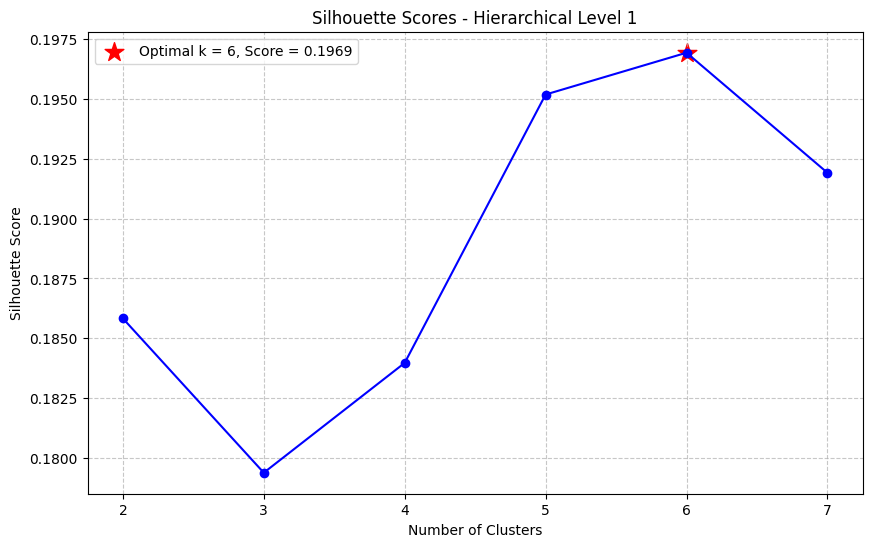

First-level cluster sizes:
cluster_hierarchical_l1
0    36
1    26
2    22
3    33
4    18
5    24
dtype: int64

Performing second-level clustering within each first-level cluster...

Second-level clustering for first-level cluster 0...
Finding optimal number of clusters from 2 to 7...
For n_clusters = 2, the silhouette score is 0.1671
For n_clusters = 3, the silhouette score is 0.1277
For n_clusters = 4, the silhouette score is 0.1340
For n_clusters = 5, the silhouette score is 0.1478
For n_clusters = 6, the silhouette score is 0.1216
For n_clusters = 7, the silhouette score is 0.1464


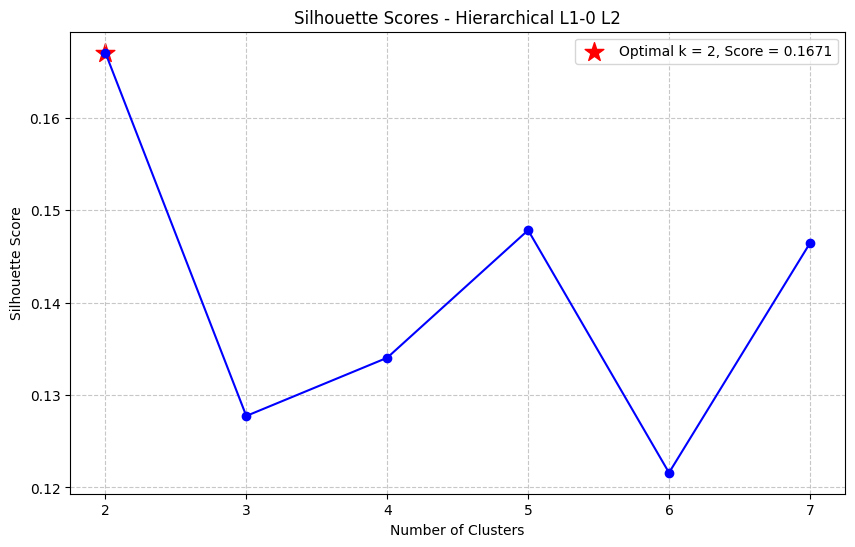


Second-level clustering for first-level cluster 1...
Finding optimal number of clusters from 2 to 5...
For n_clusters = 2, the silhouette score is 0.1600
For n_clusters = 3, the silhouette score is 0.1436
For n_clusters = 4, the silhouette score is 0.1546
For n_clusters = 5, the silhouette score is 0.1661


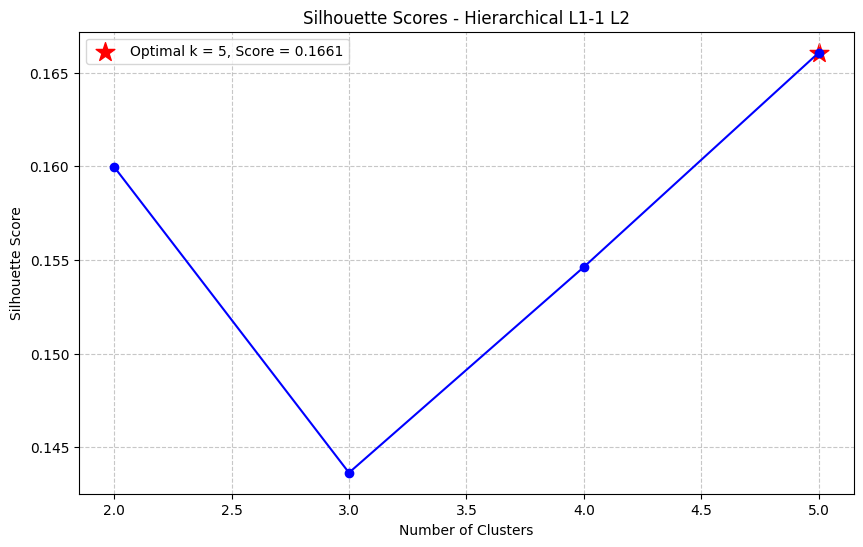


Second-level clustering for first-level cluster 2...
Finding optimal number of clusters from 2 to 4...
For n_clusters = 2, the silhouette score is 0.2107
For n_clusters = 3, the silhouette score is 0.1141
For n_clusters = 4, the silhouette score is 0.0976


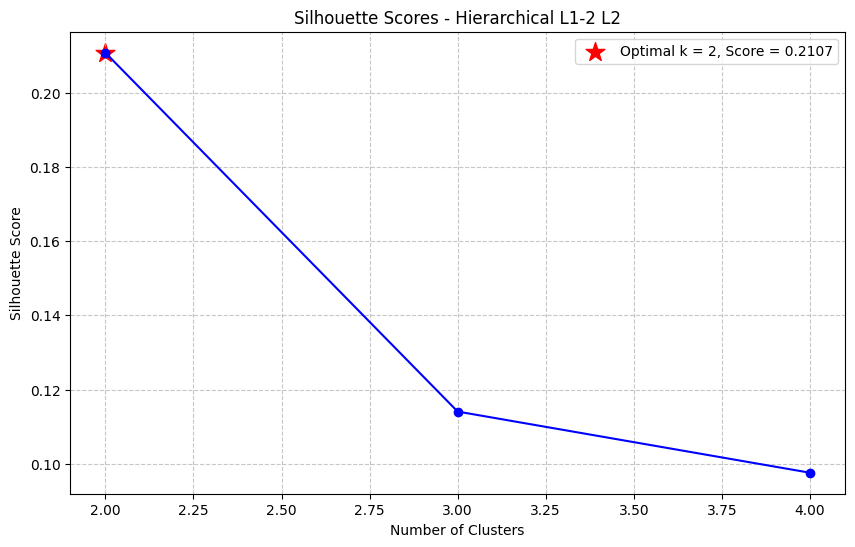


Second-level clustering for first-level cluster 3...
Finding optimal number of clusters from 2 to 6...
For n_clusters = 2, the silhouette score is 0.0902
For n_clusters = 3, the silhouette score is 0.0782
For n_clusters = 4, the silhouette score is 0.0921
For n_clusters = 5, the silhouette score is 0.0955
For n_clusters = 6, the silhouette score is 0.1019


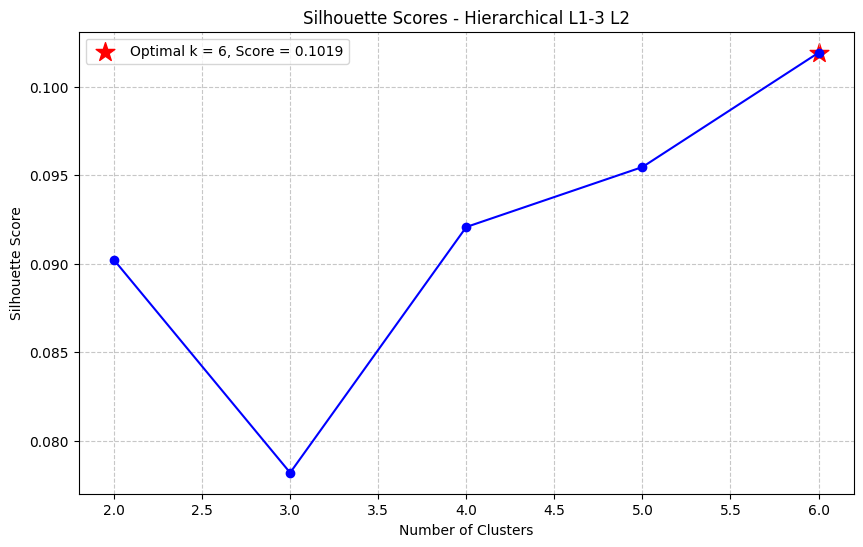


Second-level clustering for first-level cluster 4...
Finding optimal number of clusters from 2 to 3...
For n_clusters = 2, the silhouette score is 0.1728
For n_clusters = 3, the silhouette score is 0.1699


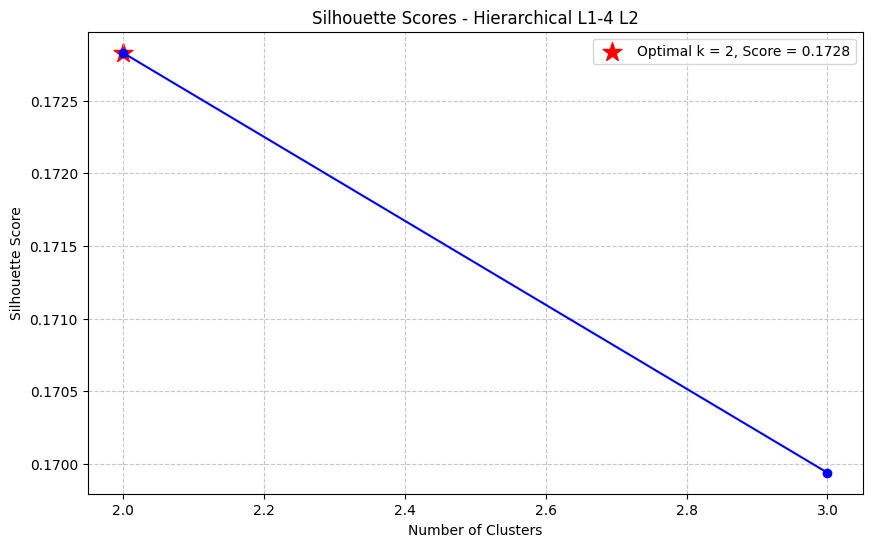


Second-level clustering for first-level cluster 5...
Finding optimal number of clusters from 2 to 4...
For n_clusters = 2, the silhouette score is 0.0963
For n_clusters = 3, the silhouette score is 0.0773
For n_clusters = 4, the silhouette score is 0.0788


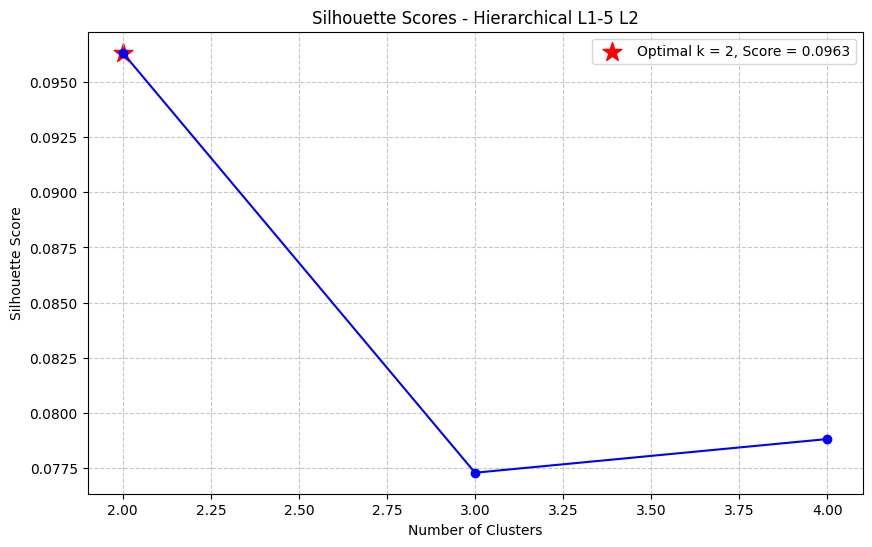


Hierarchical cluster sizes:
cluster_hierarchical
0.0    22
0.1    14
1.0     6
1.1     8
1.2     6
1.3     2
1.4     4
2.0     4
2.1    18
3.0     3
3.1     7
3.2     4
3.3     7
3.4     9
3.5     3
4.0     5
4.1    13
5.0     9
5.1    15
dtype: int64

Running Option 1: Clustering with individual variables...

Clustering with individual...
Finding optimal number of clusters from 2 to 9...
For n_clusters = 2, the silhouette score is 0.2296
For n_clusters = 3, the silhouette score is 0.1812
For n_clusters = 4, the silhouette score is 0.1552
For n_clusters = 5, the silhouette score is 0.1415
For n_clusters = 6, the silhouette score is 0.1373
For n_clusters = 7, the silhouette score is 0.1231
For n_clusters = 8, the silhouette score is 0.1098
For n_clusters = 9, the silhouette score is 0.1128


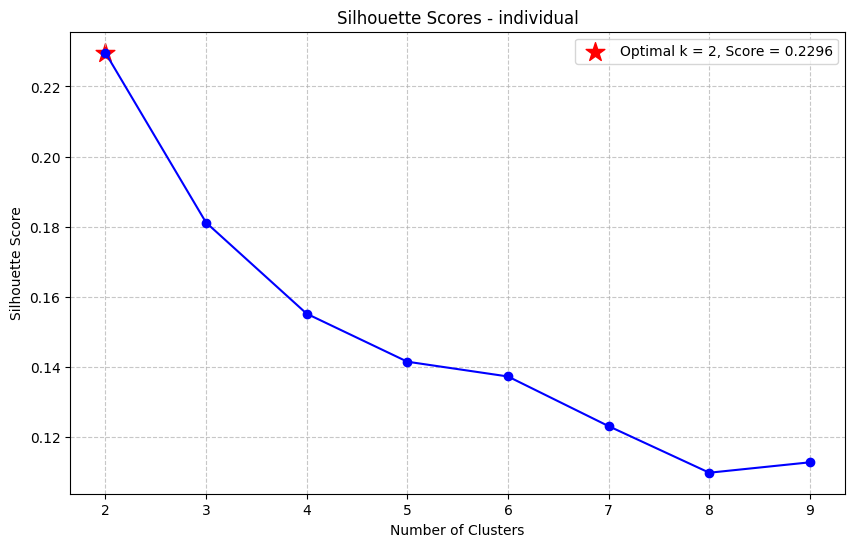

Applying K-means with 2 clusters...
Cluster sizes:
cluster_individual
0     45
1    114
dtype: int64
Generating cluster profiles based on original values...

Cluster Profiles:
                   age_group  Gender  college_ed_binary  employed_binary  \
cluster_individual                                                         
0                      18-44     1.0           0.311111         0.644444   
1                      18-44     1.0           0.333333         0.543860   

                    chronic_cond_binary  pregnant_binary  poor_phys  \
cluster_individual                                                    
0                              0.177778         0.311111   0.133333   
1                              0.254386         0.394737   0.131579   

                    poor_mental  poor_qol  health_issues_count  ...  \
cluster_individual                                              ...   
0                      0.222222  0.355556             0.888889  ...   
1                    

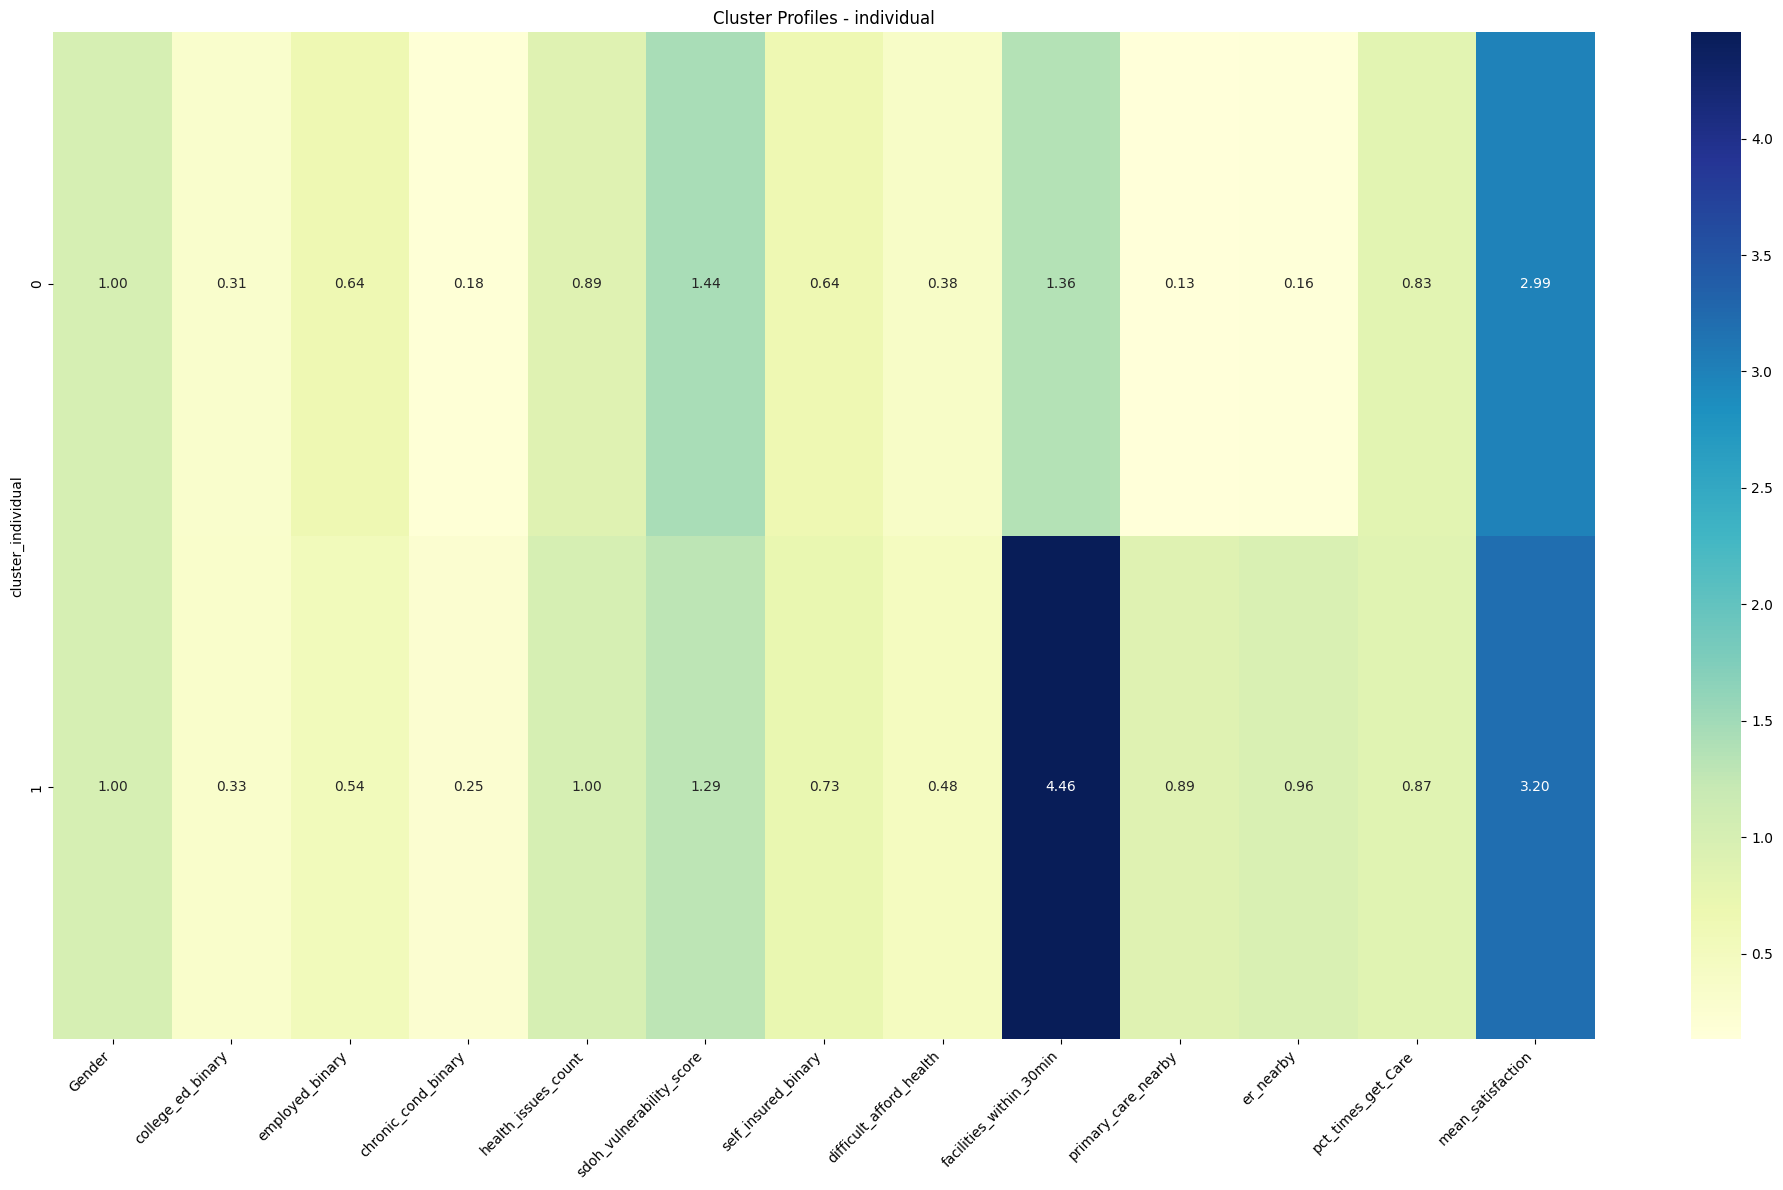

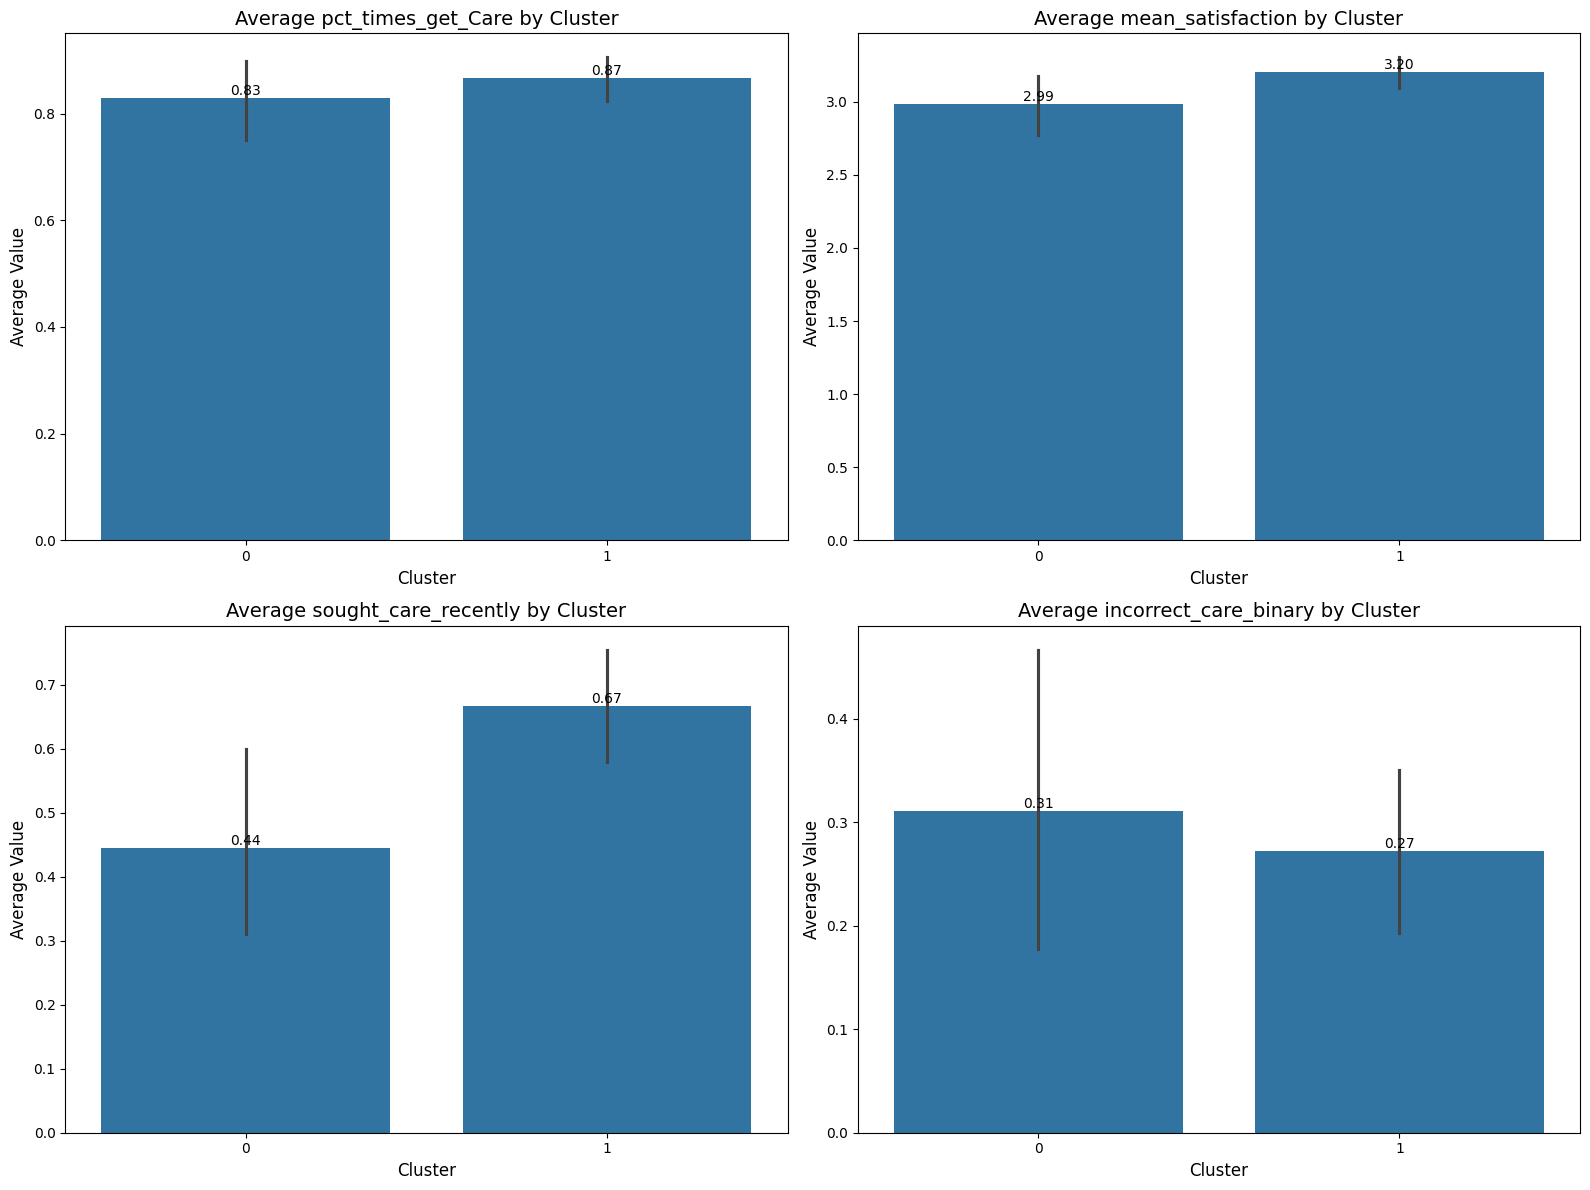


Running Option 2: Clustering with composite variables...

Clustering with composite...
Finding optimal number of clusters from 2 to 9...
For n_clusters = 2, the silhouette score is 0.1858
For n_clusters = 3, the silhouette score is 0.1794
For n_clusters = 4, the silhouette score is 0.1840
For n_clusters = 5, the silhouette score is 0.1952
For n_clusters = 6, the silhouette score is 0.1969
For n_clusters = 7, the silhouette score is 0.1919
For n_clusters = 8, the silhouette score is 0.1724
For n_clusters = 9, the silhouette score is 0.1597


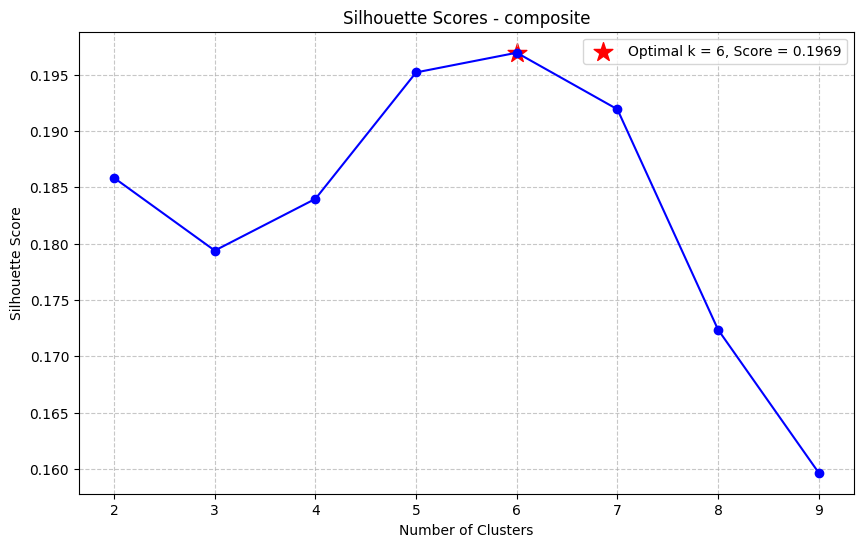

Applying K-means with 6 clusters...
Cluster sizes:
cluster_composite
0    36
1    26
2    22
3    33
4    18
5    24
dtype: int64
Generating cluster profiles based on original values...

Cluster Profiles:
                  age_group  Gender  college_ed_binary  employed_binary  \
cluster_composite                                                         
0                     18-44     1.0           0.416667         0.694444   
1                     18-44     1.0           0.384615         0.692308   
2                     18-44     1.0           0.272727         0.454545   
3                     18-44     1.0           0.363636         0.424242   
4                     18-44     1.0           0.111111         0.611111   
5                     18-44     1.0           0.291667         0.541667   

                   chronic_cond_binary  pregnant_binary  poor_phys  \
cluster_composite                                                    
0                             0.111111         0.30555

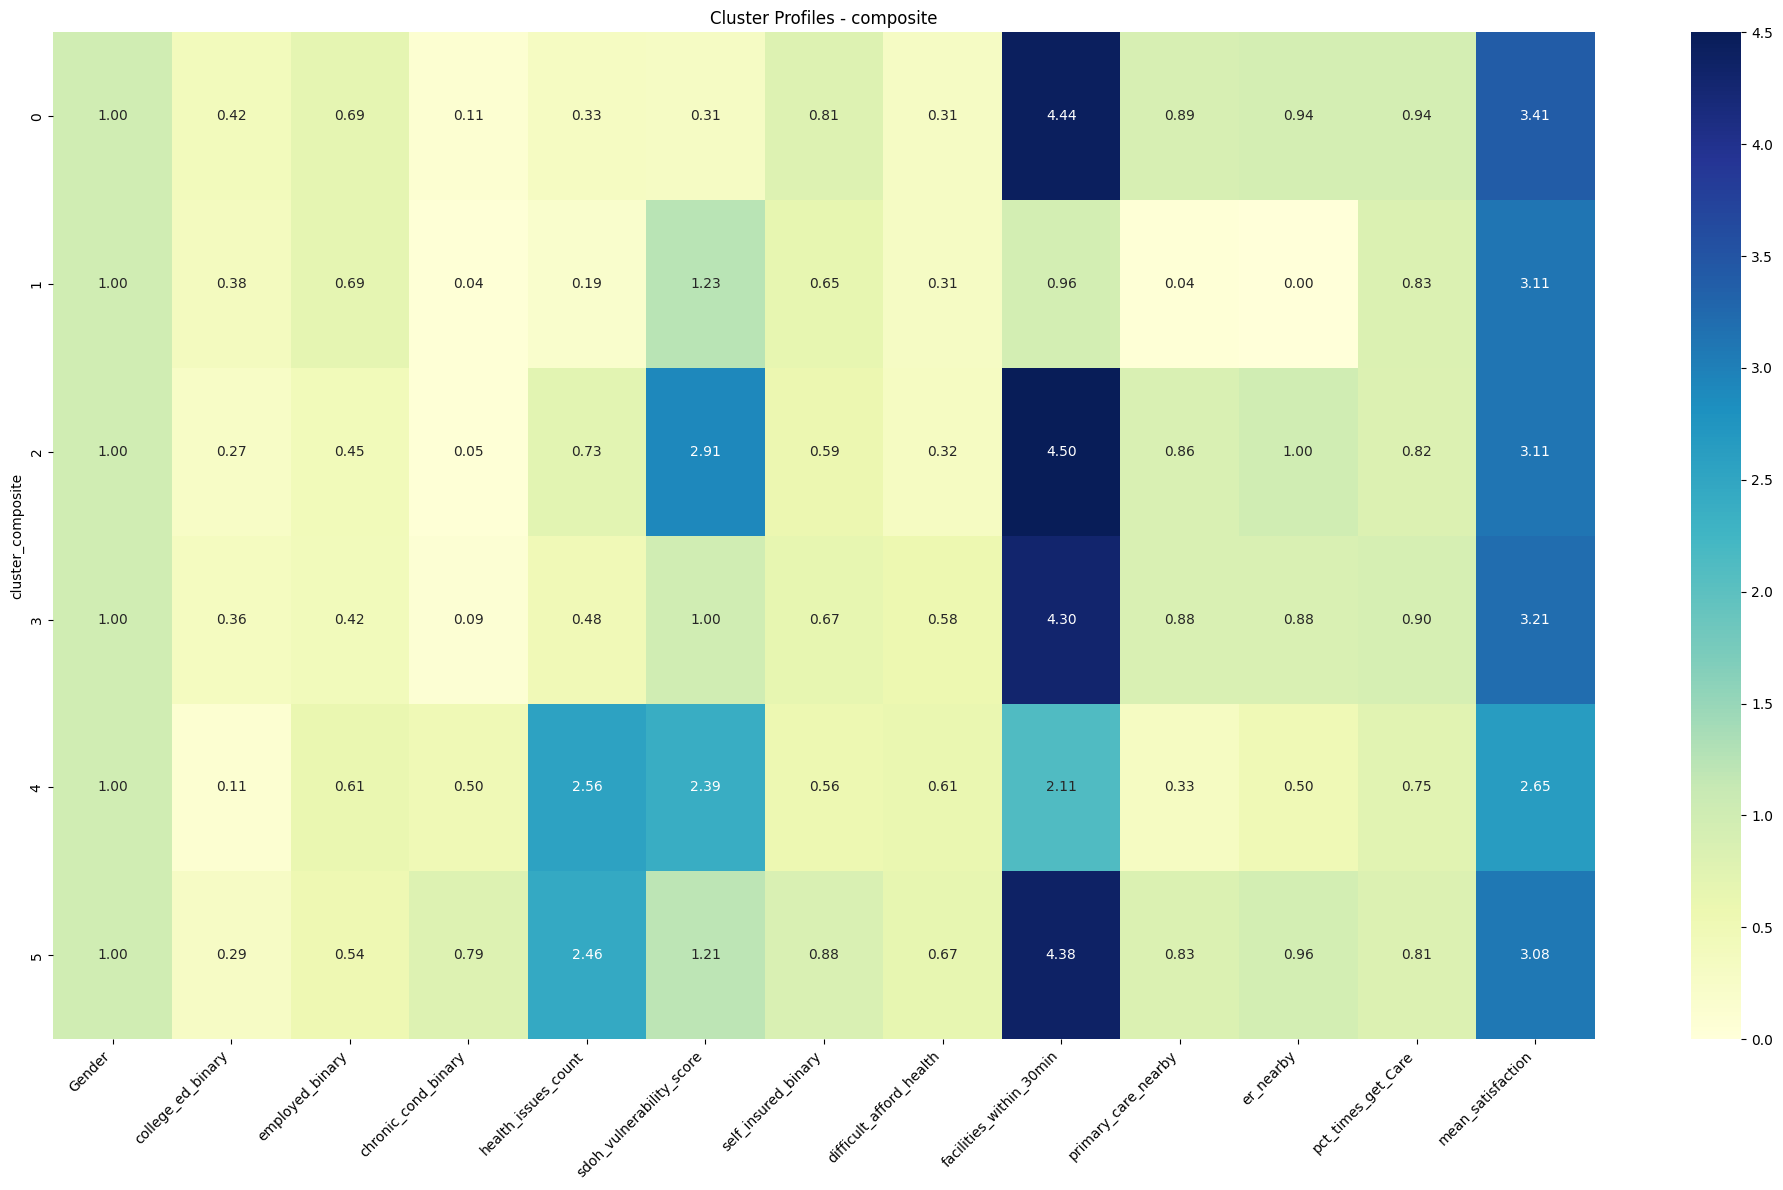

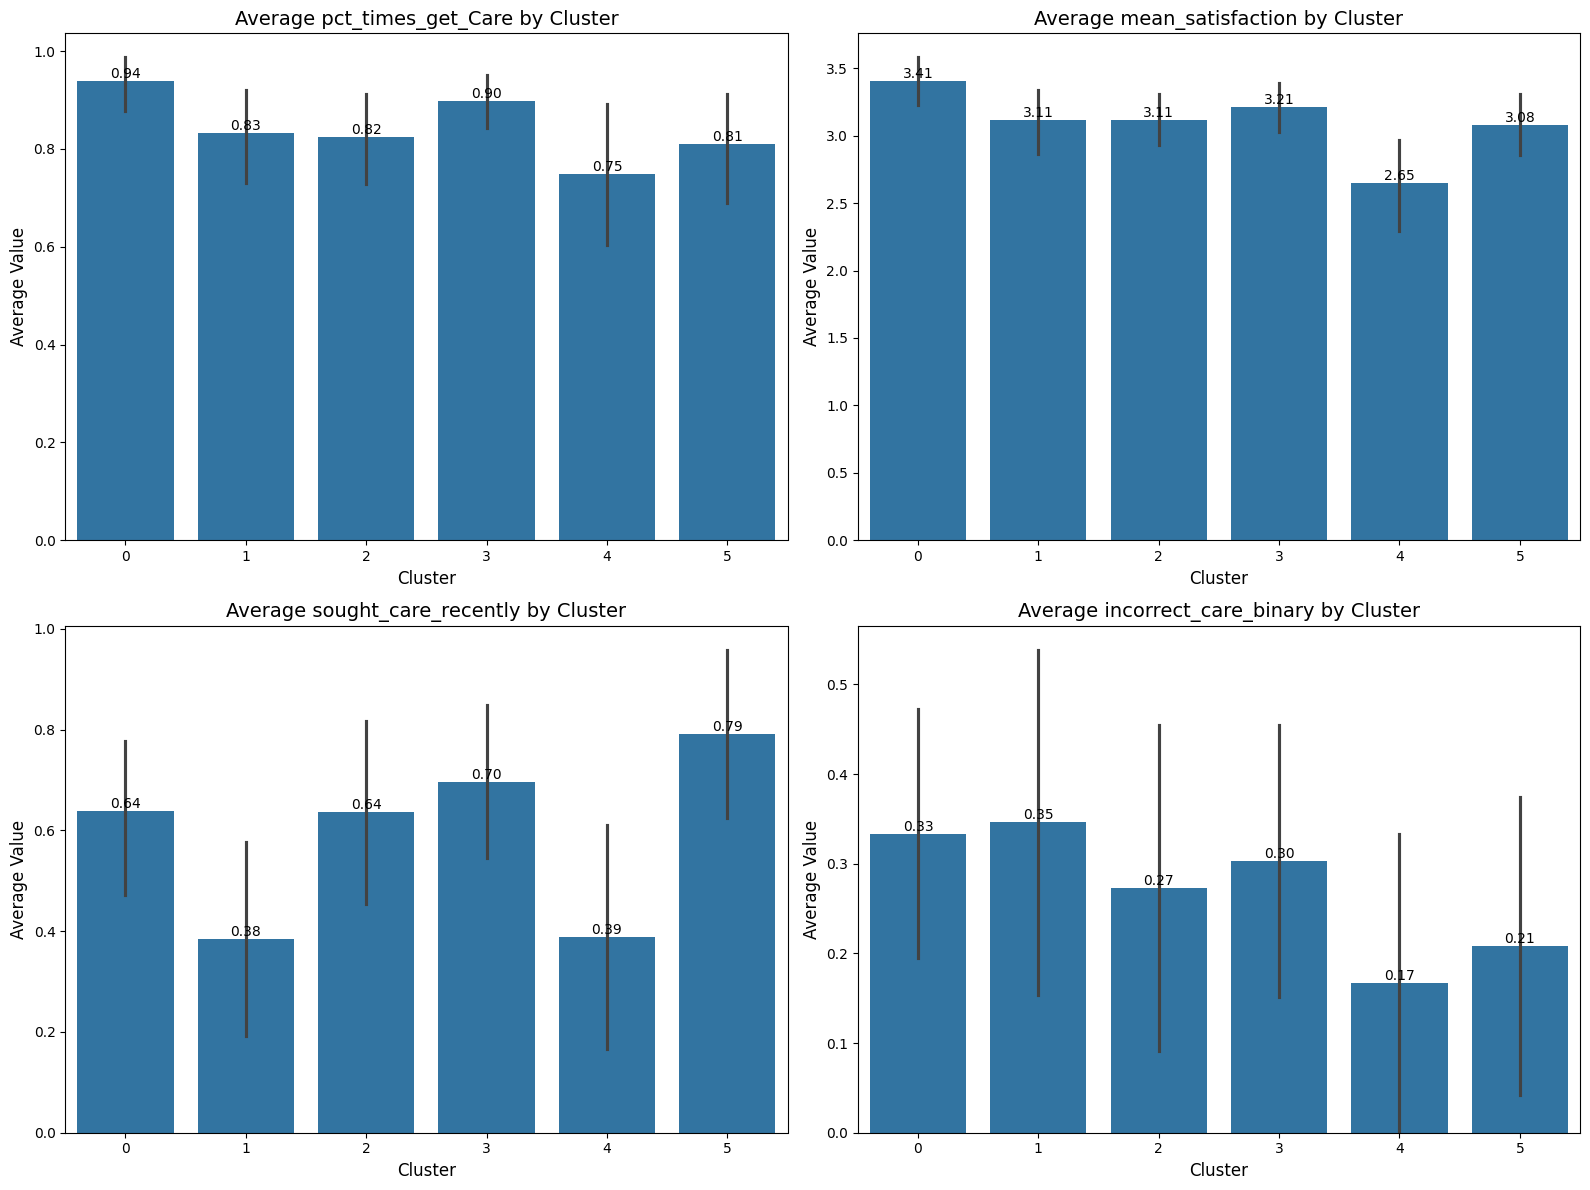


Running Option 3: Clustering with PCA components...

Clustering with pca...
Finding optimal number of clusters from 2 to 9...
For n_clusters = 2, the silhouette score is 0.1874
For n_clusters = 3, the silhouette score is 0.1878
For n_clusters = 4, the silhouette score is 0.1887
For n_clusters = 5, the silhouette score is 0.1935
For n_clusters = 6, the silhouette score is 0.2014
For n_clusters = 7, the silhouette score is 0.1978
For n_clusters = 8, the silhouette score is 0.1919
For n_clusters = 9, the silhouette score is 0.1845


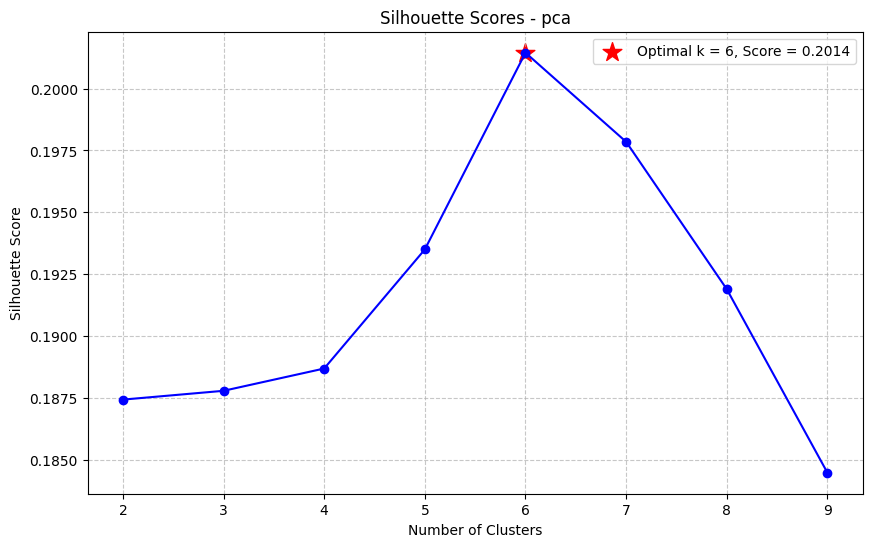

Applying K-means with 6 clusters...
Cluster sizes:
cluster_pca
0    30
1    31
2    21
3    24
4    35
5    18
dtype: int64
Generating cluster profiles based on original values...

Cluster Profiles:
            age_group  Gender  college_ed_binary  employed_binary  \
cluster_pca                                                         
0               18-44     1.0           0.366667         0.666667   
1               18-44     1.0           0.354839         0.387097   
2               18-44     1.0           0.285714         0.476190   
3               18-44     1.0           0.291667         0.541667   
4               18-44     1.0           0.428571         0.714286   
5               18-44     1.0           0.111111         0.611111   

             chronic_cond_binary  pregnant_binary  poor_phys  poor_mental  \
cluster_pca                                                                 
0                       0.033333         0.400000   0.000000     0.033333   
1                

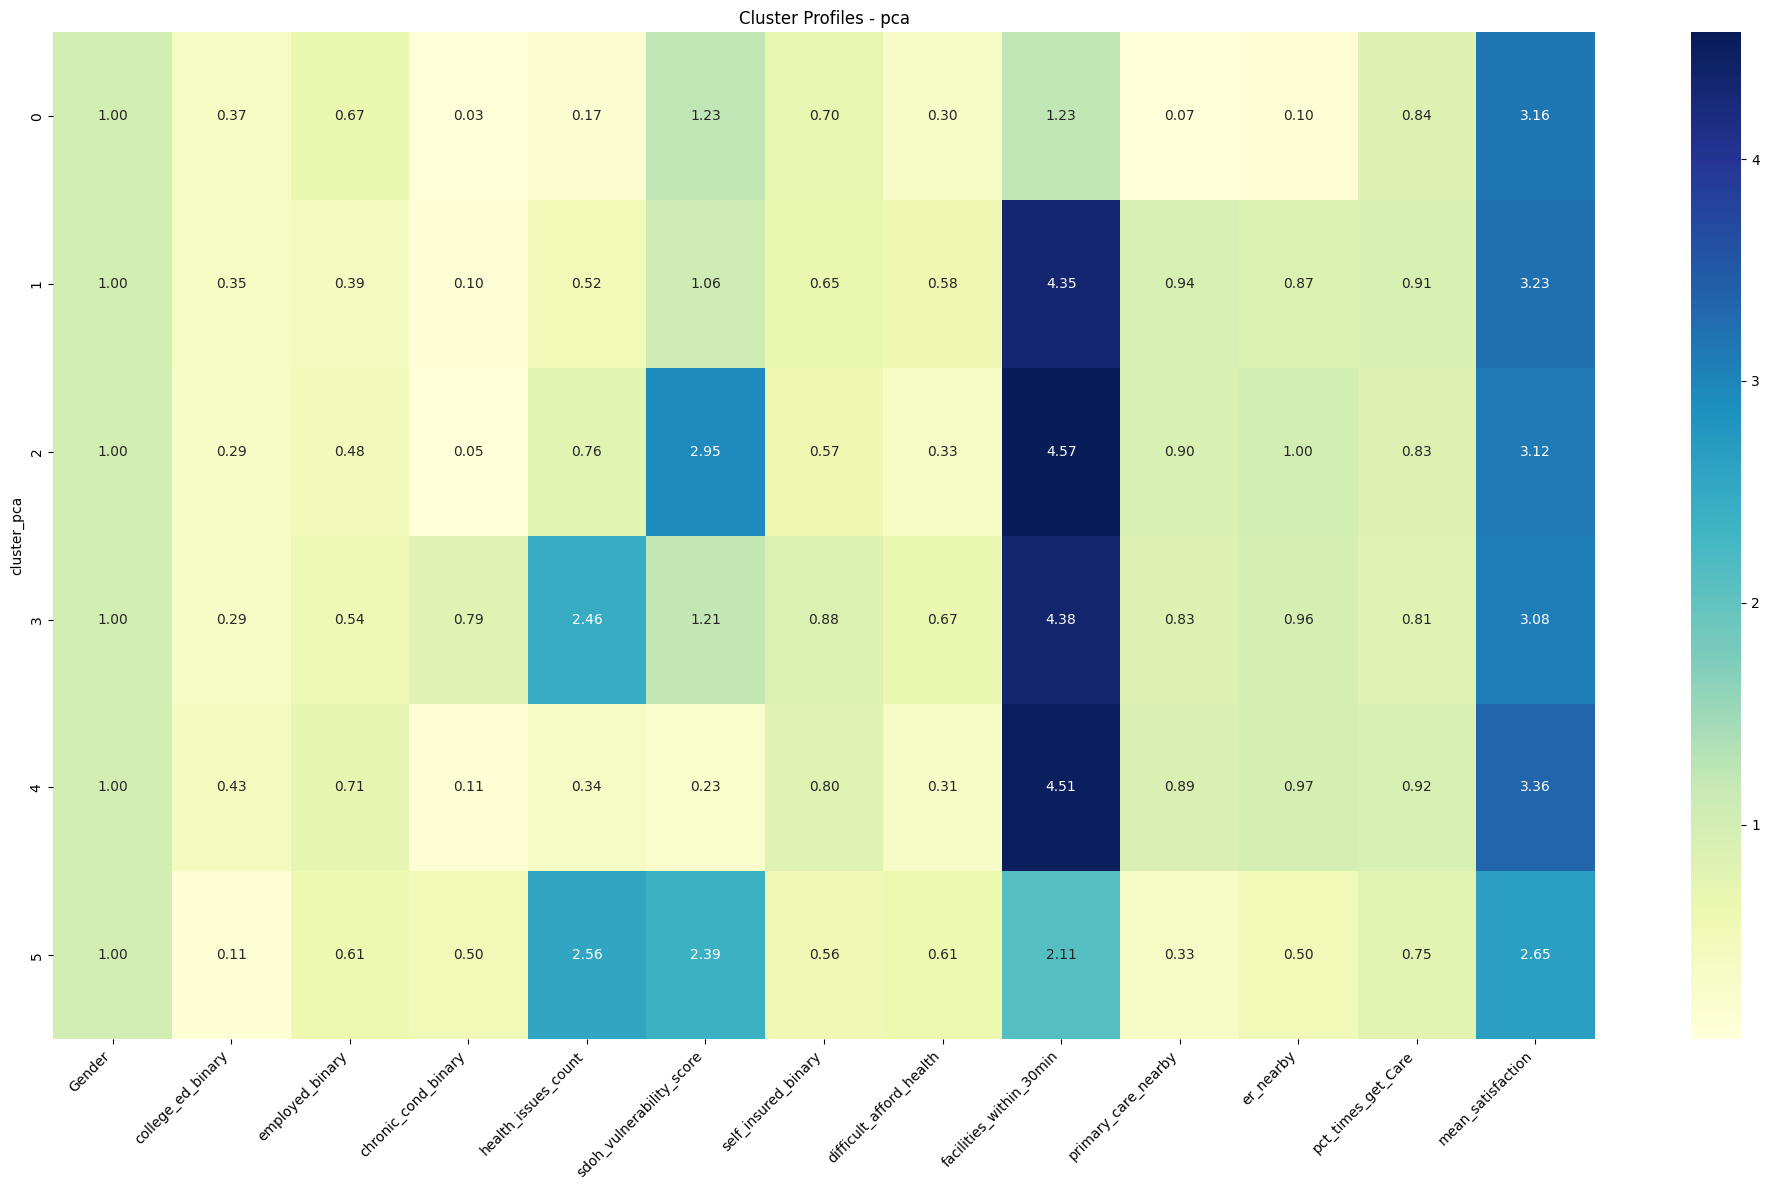

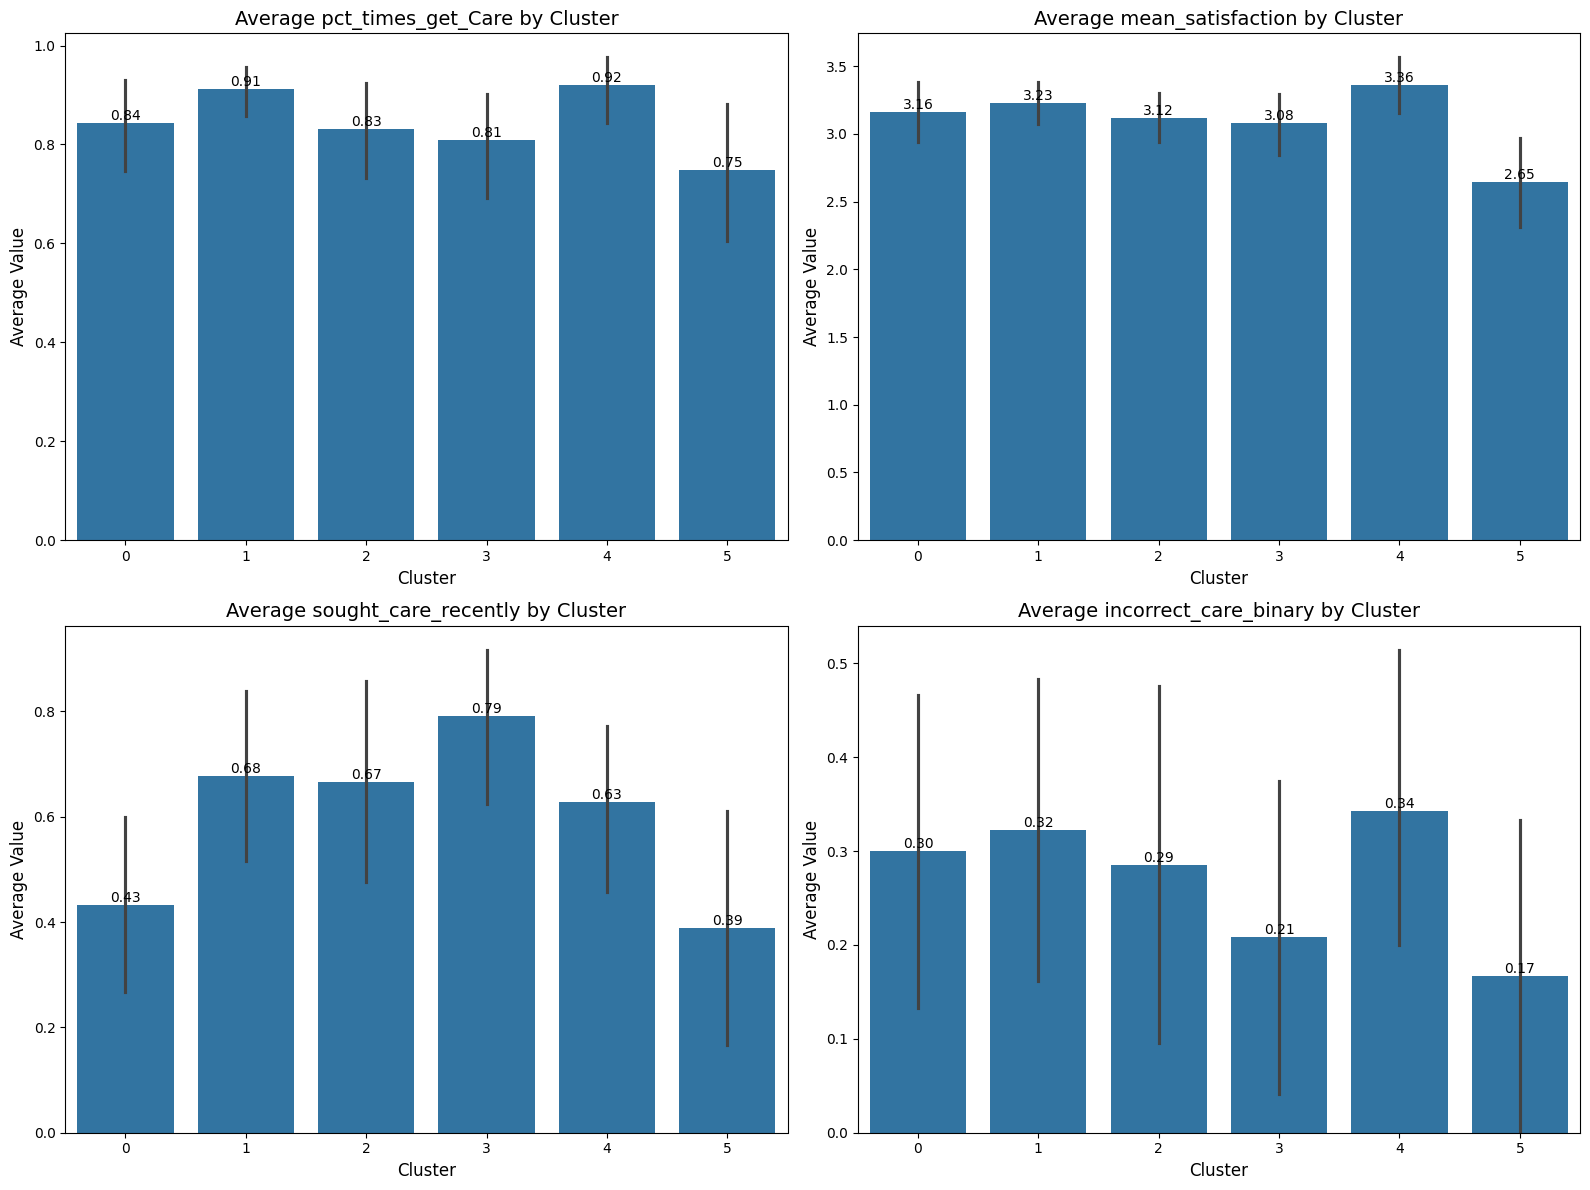


Evaluating clustering results...

Variance explained in outcome variables (%):
                       individual  composite       pca  hierarchical
pct_times_get_Care      -0.223245   3.431188  2.462750     13.360941
mean_satisfaction        1.851248   9.551261  8.157322      6.461543
sought_care_recently     3.545915   5.629649  4.405034      8.098084
incorrect_care_binary   -0.508783  -1.283216 -1.367570      2.455332


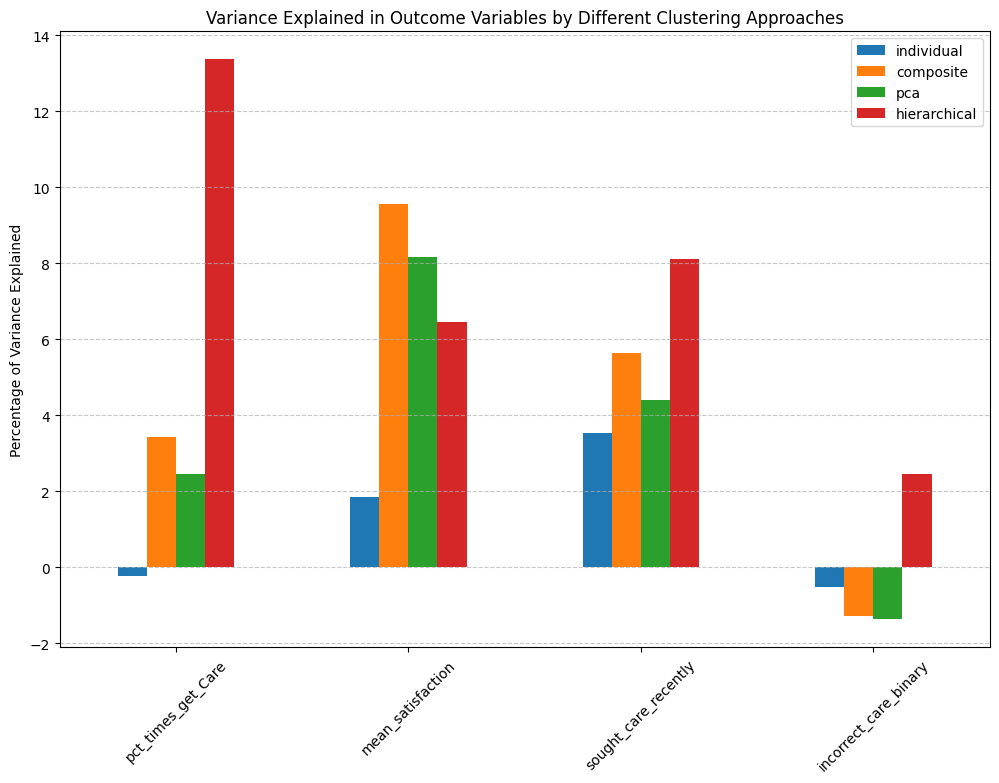


Based on variance explained, the best clustering approach is: hierarchical

All clustering approaches completed!
Final dataset with all cluster assignments saved to 'final_clustered_data_all_approaches.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.cm as cm

# Load the dataset
print("Loading the dataset...")
df = pd.read_csv('cluster_data_.csv')

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

# Create a standardized version of continuous variables
print("Standardizing continuous variables...")
scaler = StandardScaler()
continuous_vars = ['health_issues_count', 'sdoh_vulnerability_score',
                  'facilities_within_30min', 'facilities_within_10miles',
                  'pct_times_get_Care', 'mean_satisfaction']

# Create a copy for standardization
df_scaled = df.copy()

# Standardize continuous variables
for var in continuous_vars:
    df_scaled[f'{var}_scaled'] = scaler.fit_transform(df[[var]])

# One-hot encode categorical variables
print("One-hot encoding categorical variables...")
df_scaled = pd.get_dummies(df_scaled, columns=['age_group'], drop_first=False)

# Define variable sets without double counting
print("Creating different feature sets for clustering...")

# Option 1: Using only individual variables (no composites)
individual_vars = [
    'Gender', 'college_ed_binary', 'employed_binary',
    'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
    'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary', 'income_insecure_binary',
    'self_insured_binary', 'difficult_afford_health',
    'primary_care_nearby', 'urgent_care_nearby', 'er_nearby',
    'difficulty_coping_binary', 'facilities_within_30min_scaled', 'facilities_within_10miles_scaled',
    'age_group_18-44', 'age_group_45-64', 'age_group_65+'
]

# Option 2: Using only composite variables
composite_vars = [
    'Gender', 'college_ed_binary', 'employed_binary',
    'health_issues_count_scaled', 'pregnant_binary',
    'sdoh_vulnerability_score_scaled',
    'self_insured_binary', 'difficult_afford_health',
    'facilities_within_30min_scaled', 'facilities_within_10miles_scaled',
    'difficulty_coping_binary',
    'age_group_18-44', 'age_group_45-64', 'age_group_65+'
]

# Function to determine optimal number of clusters
def find_optimal_clusters(X, max_k=10, min_k=2):
    """Find optimal number of clusters using silhouette scores."""
    print(f"Finding optimal number of clusters from {min_k} to {max_k}...")
    k_range = range(min_k, max_k+1)
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}")

    return k_range, silhouette_scores

# Plot silhouette scores
def plot_silhouette_scores(k_range, silhouette_scores, title="Silhouette Scores"):
    """Plot silhouette scores for different numbers of clusters."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Mark the optimal number of clusters
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    plt.scatter(optimal_k, max(silhouette_scores), s=200, c='red', marker='*',
                label=f'Optimal k = {optimal_k}, Score = {max(silhouette_scores):.4f}')
    plt.legend()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

    return optimal_k

# Function to get representative profiles
def get_representative_profiles(df, cluster_col, cluster_num, n=5):
    """
    Get n most representative profiles for a given cluster.
    These are the profiles closest to the cluster centroid.
    """
    # Get the cluster data
    cluster_df = df[df[cluster_col] == cluster_num].copy()

    # Get the cluster center (mean of all standardized features)
    vars_to_use = [col for col in cluster_df.columns if '_scaled' in col
                   or col in ['Gender', 'college_ed_binary', 'employed_binary',
                             'chronic_cond_binary', 'pregnant_binary', 'poor_phys',
                             'poor_mental', 'poor_qol', 'food_insecure_binary',
                             'house_insecure_binary', 'transport_insecure_binary',
                             'income_insecure_binary', 'self_insured_binary',
                             'difficult_afford_health', 'primary_care_nearby',
                             'urgent_care_nearby', 'er_nearby', 'difficulty_coping_binary']]

    cluster_center = cluster_df[vars_to_use].mean()

    # Calculate distance to center for each profile
    distances = []
    for idx, row in cluster_df.iterrows():
        dist = np.sqrt(((row[vars_to_use] - cluster_center) ** 2).sum())
        distances.append((idx, dist))

    # Sort by distance and get the closest n
    distances.sort(key=lambda x: x[1])
    closest_ids = [x[0] for x in distances[:n]]

    return df.loc[closest_ids]

# Function to perform clustering with a given feature set
def perform_clustering(feature_set, feature_set_name, df, df_scaled):
    """Perform K-means clustering with a given feature set and analyze results."""
    print(f"\n{'='*80}")
    print(f"Clustering with {feature_set_name}...")
    print(f"{'='*80}")

    # Extract features for clustering
    X = df_scaled[feature_set].values

    # Find optimal number of clusters
    k_range, silhouette_scores = find_optimal_clusters(X, max_k=9, min_k=2)

    # Plot silhouette scores
    optimal_k = plot_silhouette_scores(k_range, silhouette_scores,
                                      title=f"Silhouette Scores - {feature_set_name}")

    # Apply K-means with optimal number of clusters
    print(f"Applying K-means with {optimal_k} clusters...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)

    # Add cluster labels to both dataframes
    df[f'cluster_{feature_set_name}'] = clusters
    df_scaled[f'cluster_{feature_set_name}'] = clusters

    # Display cluster sizes
    cluster_sizes = df.groupby(f'cluster_{feature_set_name}').size()
    print(f"Cluster sizes:\n{cluster_sizes}")

    # Generate cluster profiles based on original values
    print("Generating cluster profiles based on original values...")
    profile_vars = [
        'age_group', 'Gender', 'college_ed_binary', 'employed_binary',
        'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
        'health_issues_count', 'food_insecure_binary', 'house_insecure_binary',
        'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score',
        'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
        'facilities_within_10miles', 'primary_care_nearby', 'urgent_care_nearby', 'er_nearby',
        'difficulty_coping_binary', 'sought_care_recently', 'pct_times_get_Care',
        'mean_satisfaction', 'incorrect_care_binary'
    ]

    # Get profiles for categorical variables (mode)
    categorical_vars = ['age_group']
    cat_profiles = df.groupby(f'cluster_{feature_set_name}')[categorical_vars].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    # Get profiles for numerical variables (mean)
    numerical_vars = [var for var in profile_vars if var not in categorical_vars]
    num_profiles = df.groupby(f'cluster_{feature_set_name}')[numerical_vars].mean()

    # Combine profiles
    cluster_profiles = pd.concat([cat_profiles, num_profiles], axis=1)

    # Print cluster profiles
    print("\nCluster Profiles:")
    print(cluster_profiles)

    # Save cluster profiles
    cluster_profiles.to_csv(f'cluster_profiles_{feature_set_name}.csv')

    # For each cluster, get the 5 most representative profiles
    print("\nFinding most representative profiles for each cluster...")
    all_representative_profiles = pd.DataFrame()

    for i in range(optimal_k):
        print(f"\nRepresentative profiles for Cluster {i}:")
        rep_profiles = get_representative_profiles(
            df, f'cluster_{feature_set_name}', i, n=5)

        # Add a cluster identifier column
        rep_profiles['cluster'] = i

        # Add these to our collection of all representative profiles
        all_representative_profiles = pd.concat([all_representative_profiles, rep_profiles])

        # Display key information for these representative profiles
        print(rep_profiles[['Response ID', 'age_group', 'Gender', 'health_issues_count',
                           'sdoh_vulnerability_score', 'facilities_within_30min',
                           'pct_times_get_Care', 'mean_satisfaction']].head())

    # Save representative profiles
    all_representative_profiles.to_csv(f'representative_profiles_{feature_set_name}.csv')

    # Create a heatmap of cluster profiles
    plt.figure(figsize=(20, 12))
    # Select key variables for the heatmap to keep it readable
    key_vars = [
        'Gender', 'college_ed_binary', 'employed_binary',
        'chronic_cond_binary', 'health_issues_count', 'sdoh_vulnerability_score',
        'self_insured_binary', 'difficult_afford_health', 'facilities_within_30min',
        'primary_care_nearby', 'er_nearby', 'pct_times_get_Care', 'mean_satisfaction'
    ]

    sns.heatmap(cluster_profiles[key_vars], annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title(f'Cluster Profiles - {feature_set_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'cluster_profiles_heatmap_{feature_set_name}.png')
    plt.show()

    # Plot key outcome variables by cluster
    outcome_vars = ['pct_times_get_Care', 'mean_satisfaction',
                   'sought_care_recently', 'incorrect_care_binary']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, var in enumerate(outcome_vars):
        sns.barplot(x=f'cluster_{feature_set_name}', y=var, data=df, ax=axes[i])
        axes[i].set_title(f'Average {var} by Cluster', fontsize=14)
        axes[i].set_xlabel('Cluster', fontsize=12)
        axes[i].set_ylabel('Average Value', fontsize=12)
        axes[i].tick_params(labelsize=10)

        # Add value labels
        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height():.2f}',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha = 'center', va = 'bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f'outcome_variables_by_cluster_{feature_set_name}.png')
    plt.show()

    return df, optimal_k, kmeans.cluster_centers_

# Option 3: PCA-based Dimensionality Reduction
print("\n\nOption 3: Dimensionality Reduction with PCA...")

# Select all variables for PCA
pca_vars = [
    'Gender', 'college_ed_binary', 'employed_binary',
    'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
    'health_issues_count_scaled', 'food_insecure_binary', 'house_insecure_binary',
    'transport_insecure_binary', 'income_insecure_binary', 'sdoh_vulnerability_score_scaled',
    'self_insured_binary', 'difficult_afford_health',
    'primary_care_nearby', 'urgent_care_nearby', 'er_nearby',
    'difficulty_coping_binary', 'facilities_within_30min_scaled', 'facilities_within_10miles_scaled',
    'age_group_18-44', 'age_group_45-64', 'age_group_65+'
]

# Create X matrix for PCA
X_pca = df_scaled[pca_vars].values

# Apply PCA
pca = PCA(n_components=0.9)  # Keep components that explain 90% of variance
pca_result = pca.fit_transform(X_pca)

print(f"Original dimensions: {X_pca.shape[1]}, PCA dimensions: {pca_result.shape[1]}")
print(f"Explained variance ratios: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
)

# Add the PCA components to the scaled dataframe
for col in pca_df.columns:
    df_scaled[col] = pca_df[col]

# Use PCA components for clustering
pca_cluster_vars = pca_df.columns.tolist()

# Option 4: Hierarchical Approach
print("\n\nOption 4: Hierarchical Approach...")

# First-level clustering using composite variables
print("First-level clustering using composite variables...")

# Extract features for first-level clustering
X_level1 = df_scaled[composite_vars].values

# Find optimal number of first-level clusters
k_range_l1, silhouette_scores_l1 = find_optimal_clusters(X_level1, max_k=7, min_k=2)
optimal_k_l1 = plot_silhouette_scores(k_range_l1, silhouette_scores_l1,
                                     title="Silhouette Scores - Hierarchical Level 1")

# Apply first-level clustering
kmeans_l1 = KMeans(n_clusters=optimal_k_l1, random_state=42, n_init=10)
clusters_l1 = kmeans_l1.fit_predict(X_level1)

# Add first-level cluster labels
df['cluster_hierarchical_l1'] = clusters_l1
df_scaled['cluster_hierarchical_l1'] = clusters_l1

# Display first-level cluster sizes
cluster_sizes_l1 = df.groupby('cluster_hierarchical_l1').size()
print(f"First-level cluster sizes:\n{cluster_sizes_l1}")

# For each first-level cluster, perform second-level clustering using individual variables
print("\nPerforming second-level clustering within each first-level cluster...")

for i in range(optimal_k_l1):
    # Get data for this first-level cluster
    mask = df_scaled['cluster_hierarchical_l1'] == i
    if sum(mask) > 10:  # Only cluster if we have enough data points
        print(f"\nSecond-level clustering for first-level cluster {i}...")
        X_level2 = df_scaled.loc[mask, individual_vars].values

        # Find optimal number of second-level clusters
        max_k_l2 = min(7, sum(mask) // 5)  # Limit based on cluster size
        if max_k_l2 >= 2:
            k_range_l2, silhouette_scores_l2 = find_optimal_clusters(X_level2, max_k=max_k_l2, min_k=2)
            optimal_k_l2 = plot_silhouette_scores(k_range_l2, silhouette_scores_l2,
                                                title=f"Silhouette Scores - Hierarchical L1-{i} L2")

            # Apply second-level clustering
            kmeans_l2 = KMeans(n_clusters=optimal_k_l2, random_state=42, n_init=10)
            clusters_l2 = kmeans_l2.fit_predict(X_level2)

            # Create hierarchical cluster labels (L1.L2)
            l2_labels = [f"{i}.{j}" for j in clusters_l2]
            df.loc[mask, 'cluster_hierarchical'] = l2_labels
            df_scaled.loc[mask, 'cluster_hierarchical'] = l2_labels
        else:
            # If not enough data for second-level clustering, keep just the L1 label
            df.loc[mask, 'cluster_hierarchical'] = f"{i}.0"
            df_scaled.loc[mask, 'cluster_hierarchical'] = f"{i}.0"
    else:
        # If not enough data for second-level clustering, keep just the L1 label
        df.loc[mask, 'cluster_hierarchical'] = f"{i}.0"
        df_scaled.loc[mask, 'cluster_hierarchical'] = f"{i}.0"

# Display hierarchical cluster sizes
cluster_sizes_hierarchical = df.groupby('cluster_hierarchical').size()
print(f"\nHierarchical cluster sizes:\n{cluster_sizes_hierarchical}")

# Now run the main clustering approaches
print("\nRunning Option 1: Clustering with individual variables...")
df, k_individual, centers_individual = perform_clustering(individual_vars, "individual", df, df_scaled)

print("\nRunning Option 2: Clustering with composite variables...")
df, k_composite, centers_composite = perform_clustering(composite_vars, "composite", df, df_scaled)

print("\nRunning Option 3: Clustering with PCA components...")
df, k_pca, centers_pca = perform_clustering(pca_cluster_vars, "pca", df, df_scaled)

# Evaluate each clustering approach
print("\nEvaluating clustering results...")
cluster_methods = {
    'individual': 'cluster_individual',
    'composite': 'cluster_composite',
    'pca': 'cluster_pca',
    'hierarchical': 'cluster_hierarchical'
}

# Calculate variance explained in outcome variables
def evaluate_clustering(df, cluster_col, outcome_vars):
    """Evaluate clustering based on how well it separates outcome variables."""
    results = {}

    for var in outcome_vars:
        # Calculate total variance
        total_variance = df[var].var()

        # Calculate weighted within-cluster variance
        cluster_variances = df.groupby(cluster_col)[var].var().fillna(0)
        cluster_sizes = df.groupby(cluster_col).size()
        within_variance = sum(cluster_variances * cluster_sizes) / len(df)

        # Calculate variance explained
        variance_explained = (total_variance - within_variance) / total_variance * 100
        results[var] = variance_explained

    return results

# Compare all clustering approaches
outcome_vars = ['pct_times_get_Care', 'mean_satisfaction',
               'sought_care_recently', 'incorrect_care_binary']

evaluation_results = {}
for method, col in cluster_methods.items():
    if col in df.columns:
        evaluation_results[method] = evaluate_clustering(df, col, outcome_vars)

# Create evaluation dataframe
evaluation_df = pd.DataFrame(evaluation_results)
print("\nVariance explained in outcome variables (%):")
print(evaluation_df)

# Plot evaluation results
evaluation_df.plot(kind='bar', figsize=(12, 8))
plt.title('Variance Explained in Outcome Variables by Different Clustering Approaches')
plt.ylabel('Percentage of Variance Explained')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('variance_explained_comparison.png')
plt.show()

# Identify the best approach based on average variance explained
method_means = evaluation_df.mean()
best_method = method_means.idxmax()
print(f"\nBased on variance explained, the best clustering approach is: {best_method}")

# Save final dataset with all cluster assignments
df.to_csv('final_clustered_data_all_approaches.csv', index=False)

print("\nAll clustering approaches completed!")
print("Final dataset with all cluster assignments saved to 'final_clustered_data_all_approaches.csv'")

# Evaluating the approaches

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# Load the final dataset with all cluster assignments
df = pd.read_csv('final_clustered_data_all_approaches.csv')

# Create descriptive names for the clusters based on their characteristics
# For the composite approach (6 clusters)
composite_cluster_names = {
    0: "Healthy, Well-Resourced",
    1: "Healthy, Geographically Isolated",
    2: "Vulnerable, Good Geographic Access",
    3: "Low-Income, Good Geographic Access",
    4: "High Health Needs, Limited Access",
    5: "Chronic Conditions, Good Access"
}

# For the PCA approach (6 clusters)
pca_cluster_names = {
    0: "Geographically Isolated, Moderate Outcomes",
    1: "Good Access, Low Health Needs",
    2: "High Social Vulnerability, Good Access",
    3: "Chronic Conditions, Adequate Access",
    4: "Privileged, Excellent Outcomes",
    5: "High Health Burden, Limited Access"
}

# For the individual approach (2 clusters)
individual_cluster_names = {
    0: "Limited Geographic Access",
    1: "Good Geographic Access"
}

# For hierarchical approach, create names for top-level clusters
hierarchical_l1_names = {
    0: "Healthy, Well-Resourced",
    1: "Geographically Isolated",
    2: "High Vulnerability with Access",
    3: "Low-Income, Good Geographic Access",
    4: "High Health Needs, Limited Access",
    5: "Chronic Conditions, Good Access"
}

# Add cluster names to the dataset
df['cluster_composite_name'] = df['cluster_composite'].map(composite_cluster_names)
df['cluster_pca_name'] = df['cluster_pca'].map(pca_cluster_names)
df['cluster_individual_name'] = df['cluster_individual'].map(individual_cluster_names)
df['cluster_hierarchical_l1_name'] = df['cluster_hierarchical_l1'].map(hierarchical_l1_names)

# Calculate Calinski-Harabasz Index for each approach
# First, get the feature matrices used for each approach
individual_vars = [col for col in df.columns if '_scaled' in col or
                   col in ['Gender', 'college_ed_binary', 'employed_binary',
                          'chronic_cond_binary', 'pregnant_binary', 'poor_phys', 'poor_mental', 'poor_qol',
                          'food_insecure_binary', 'house_insecure_binary', 'transport_insecure_binary',
                          'income_insecure_binary', 'self_insured_binary', 'difficult_afford_health',
                          'primary_care_nearby', 'urgent_care_nearby', 'er_nearby', 'difficulty_coping_binary']]

# Calculate CH index for each approach
ch_individual = calinski_harabasz_score(df[individual_vars], df['cluster_individual'])
ch_composite = calinski_harabasz_score(df[individual_vars], df['cluster_composite'])
ch_pca = calinski_harabasz_score(df[individual_vars], df['cluster_pca'])

# Store best silhouette scores
silhouette_scores = {
    "Individual": 0.2296,  # 2 clusters
    "Composite": 0.1969,   # 6 clusters
    "PCA": 0.2014,         # 6 clusters
    "Hierarchical": 0.1969  # Level 1 silhouette score
}

# Store Calinski-Harabasz scores
ch_scores = {
    "Individual": ch_individual,
    "Composite": ch_composite,
    "PCA": ch_pca
}

# Create a dataframe with cluster evaluation metrics
evaluation_df = pd.DataFrame({
    'Approach': list(silhouette_scores.keys()),
    'Optimal Clusters': [2, 6, 6, 'Hierarchical'],
    'Silhouette Score': list(silhouette_scores.values()),
    'Calinski-Harabasz Index': [ch_scores.get(k, np.nan) for k in silhouette_scores.keys()],
    'Variance Explained (pct_times_get_Care)': [-0.223245, 3.431188, 2.462750, 13.360941],
    'Variance Explained (mean_satisfaction)': [1.851248, 9.551261, 8.157322, 6.461543],
    'Variance Explained (sought_care_recently)': [3.545915, 5.629649, 4.405034, 8.098084],
    'Variance Explained (incorrect_care_binary)': [-0.508783, -1.283216, -1.367570, 2.455332]
})

# Save evaluation metrics
evaluation_df.to_csv('cluster_evaluation_metrics.csv', index=False)

# Create a comprehensive profile for each approach
def create_comprehensive_profiles(df, cluster_col, cluster_names, approach_name):
    """Create comprehensive profiles for a clustering approach"""
    profiles = []

    for cluster_id, cluster_name in cluster_names.items():
        cluster_df = df[df[cluster_col] == cluster_id]
        n = len(cluster_df)
        pct = n / len(df) * 100

        # Demographics
        gender_pct = cluster_df['Gender'].mean() * 100
        edu_pct = cluster_df['college_ed_binary'].mean() * 100
        emp_pct = cluster_df['employed_binary'].mean() * 100

        # Health status
        chronic_pct = cluster_df['chronic_cond_binary'].mean() * 100
        health_issues = cluster_df['health_issues_count'].mean()

        # Social determinants
        sdoh_score = cluster_df['sdoh_vulnerability_score'].mean()

        # Healthcare access
        geo_access = cluster_df['facilities_within_30min'].mean()

        # Outcomes
        care_pct = cluster_df['pct_times_get_Care'].mean() * 100
        satisfaction = cluster_df['mean_satisfaction'].mean()

        # Get representative profiles (5 most typical examples)
        rep_ids = cluster_df.sort_values(by='Response ID').head(5)['Response ID'].tolist()

        profiles.append({
            'Approach': approach_name,
            'Cluster ID': cluster_id,
            'Cluster Name': cluster_name,
            'Size': n,
            'Percentage': pct,
            'Female Percentage': gender_pct,
            'College Educated Percentage': edu_pct,
            'Employed Percentage': emp_pct,
            'Chronic Condition Percentage': chronic_pct,
            'Average Health Issues': health_issues,
            'Average SDoH Vulnerability': sdoh_score,
            'Average Facilities Within 30min': geo_access,
            'Care Access Percentage': care_pct,
            'Satisfaction Rating': satisfaction,
            'Representative Profile IDs': ', '.join(rep_ids)
        })

    return pd.DataFrame(profiles)

# Create profiles for each approach
individual_profiles = create_comprehensive_profiles(
    df, 'cluster_individual', individual_cluster_names, 'Individual')
composite_profiles = create_comprehensive_profiles(
    df, 'cluster_composite', composite_cluster_names, 'Composite')
pca_profiles = create_comprehensive_profiles(
    df, 'cluster_pca', pca_cluster_names, 'PCA')

# Combine all profiles
all_profiles = pd.concat([individual_profiles, composite_profiles, pca_profiles])

# Save comprehensive profiles
all_profiles.to_csv('comprehensive_cluster_profiles.csv', index=False)

# Save dataset with cluster assignments and names
df.to_csv('final_dataset_with_cluster_names.csv', index=False)

print("Analysis complete. Files saved:")
print("1. cluster_evaluation_metrics.csv - Comparison of clustering approaches")
print("2. comprehensive_cluster_profiles.csv - Detailed profiles of all clusters")
print("3. final_dataset_with_cluster_names.csv - Full dataset with cluster assignments and names")

Analysis complete. Files saved:
1. cluster_evaluation_metrics.csv - Comparison of clustering approaches
2. comprehensive_cluster_profiles.csv - Detailed profiles of all clusters
3. final_dataset_with_cluster_names.csv - Full dataset with cluster assignments and names


# Trying simplified clustering techniques


Number of records after removing missing values: 159
For n_clusters = 2, the silhouette score is 0.17606880070460051
For n_clusters = 3, the silhouette score is 0.16106057184955067
For n_clusters = 4, the silhouette score is 0.17035632419390756
For n_clusters = 5, the silhouette score is 0.17915545981710135
For n_clusters = 6, the silhouette score is 0.1794206034549219
For n_clusters = 7, the silhouette score is 0.18373728725105498


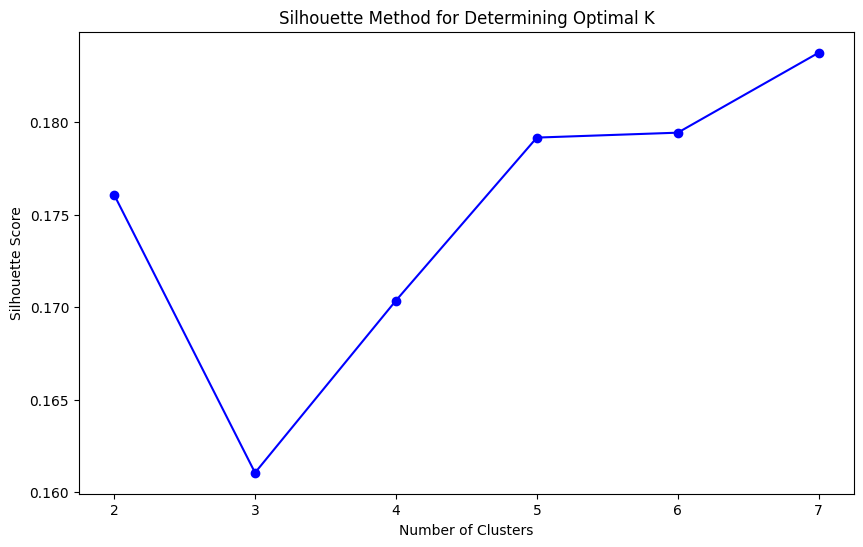

Optimal number of clusters based on silhouette score: 7

Cluster Profiles (Simplified Variables):
         Gender  college_ed_binary  employed_binary  older_adult  \
cluster                                                            
0           1.0           1.000000         0.629630     0.000000   
1           1.0           0.000000         0.434783     0.000000   
2           1.0           0.047619         0.285714     0.047619   
3           1.0           0.736842         0.842105     0.000000   
4           1.0           0.000000         0.214286     0.000000   
5           1.0           0.272727         0.818182     0.000000   
6           1.0           0.210526         0.947368     0.052632   

         high_health_need  high_social_vulnerability  low_geographic_access  \
cluster                                                                       
0                0.148148                   0.000000               0.000000   
1                0.130435                   0.521739

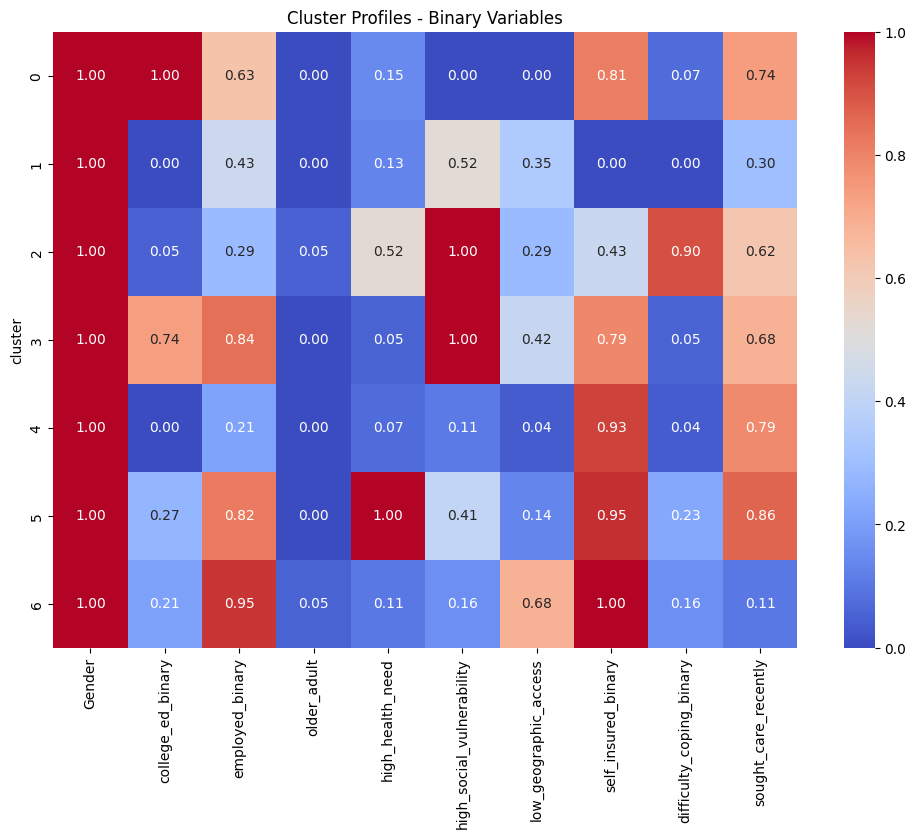

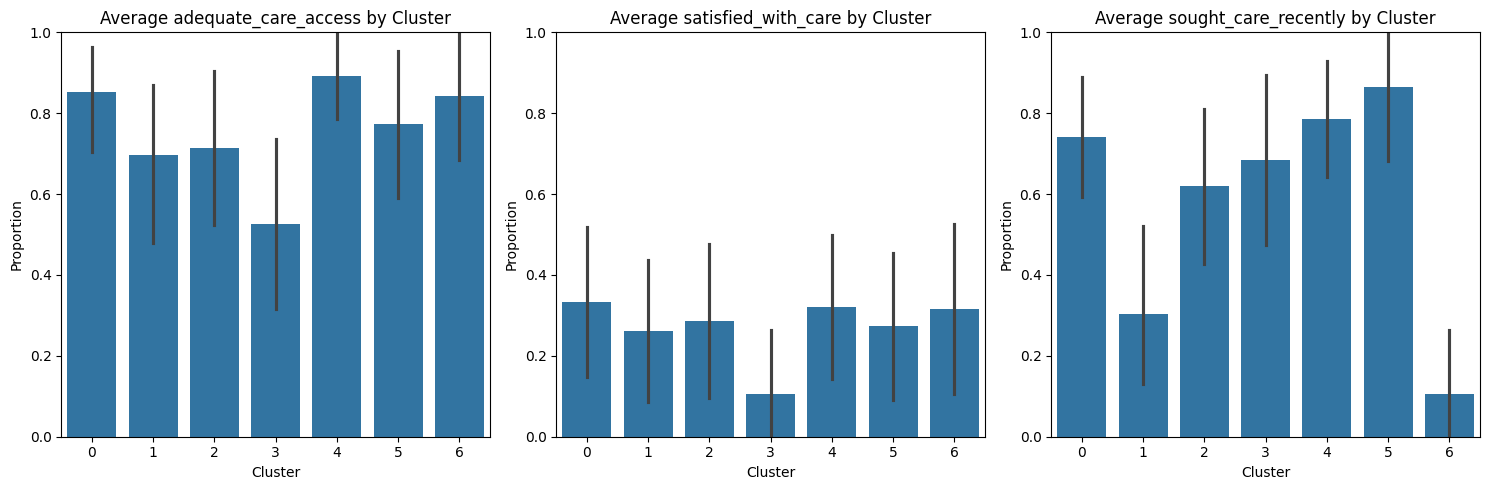


Cluster Sizes:
cluster
0    27
1    23
2    21
3    19
4    28
5    22
6    19
Name: count, dtype: int64


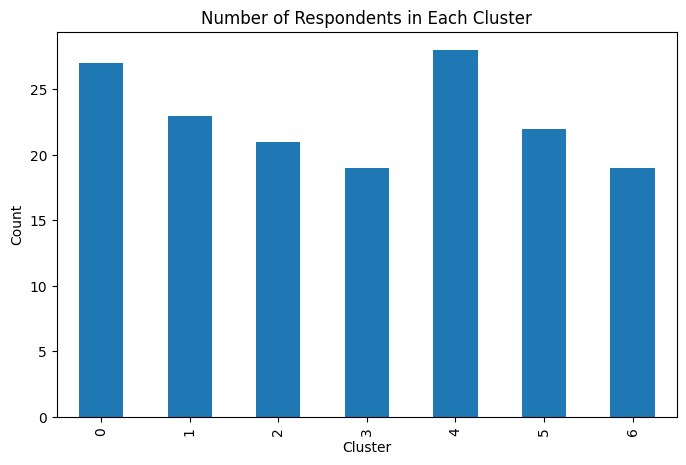

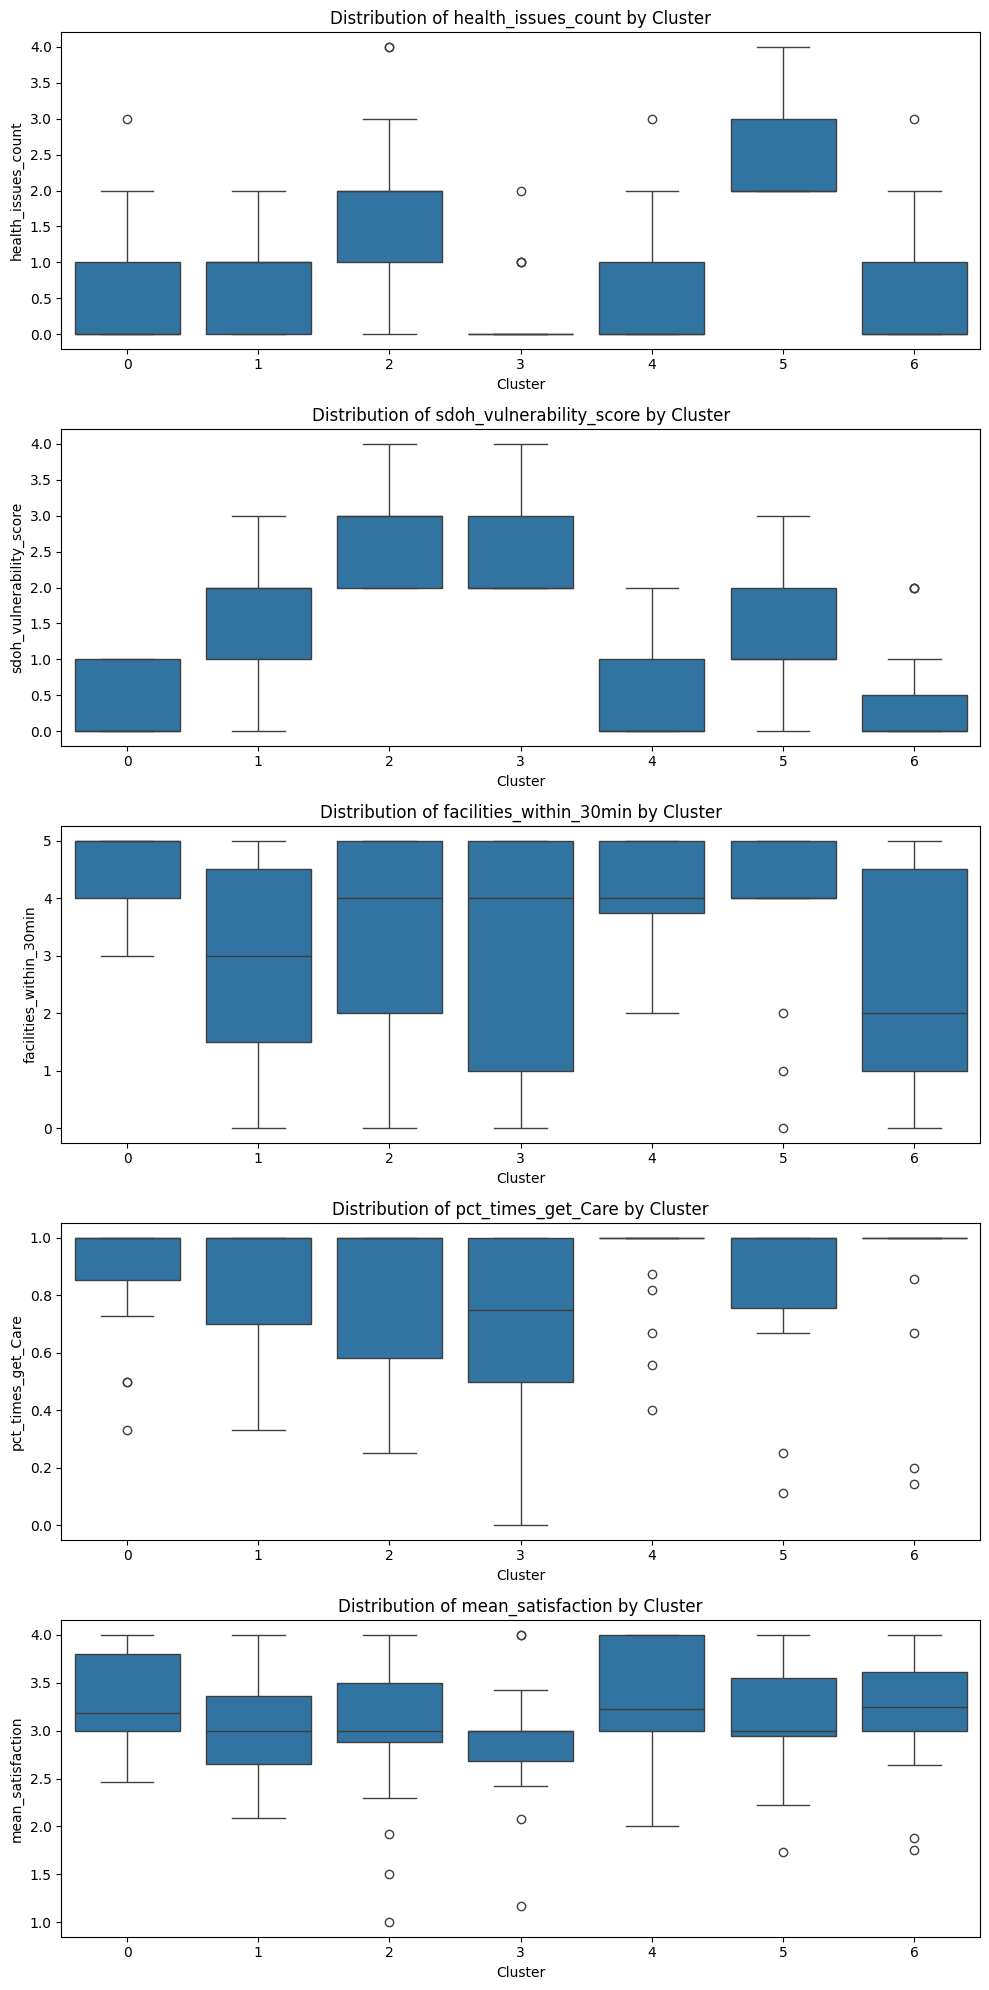


Detailed Cluster Descriptions:

Cluster 0 (n=27):
Demographics:
  Age groups: {'18-44': np.float64(0.74), '45-64': np.float64(0.26)}
  Female: 100.0%
  College education: 100.0%
  Employed: 63.0%
Health Status:
  Chronic condition: 25.9%
  High health need: 14.8%
Social Vulnerability:
  High social vulnerability: 0.0%
Healthcare Access:
  Self-insured: 81.5%
  Low geographic access: 0.0%
Outcomes:
  Sought care recently: 74.1%
  Adequate care access: 85.2%
  Mean satisfaction: 3.32

Cluster 1 (n=23):
Demographics:
  Age groups: {'18-44': np.float64(1.0)}
  Female: 100.0%
  College education: 0.0%
  Employed: 43.5%
Health Status:
  Chronic condition: 0.0%
  High health need: 13.0%
Social Vulnerability:
  High social vulnerability: 52.2%
Healthcare Access:
  Self-insured: 0.0%
  Low geographic access: 34.8%
Outcomes:
  Sought care recently: 30.4%
  Adequate care access: 69.6%
  Mean satisfaction: 3.04

Cluster 2 (n=21):
Demographics:
  Age groups: {'18-44': np.float64(0.76), '45-64': np

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv('cluster_data_.csv')

# Create binary versions of composite variables
df['high_health_need'] = (df['health_issues_count'] >= 2).astype(int)
df['high_social_vulnerability'] = (df['sdoh_vulnerability_score'] >= 2).astype(int)
df['low_geographic_access'] = (df['facilities_within_30min'] <= 2).astype(int)

# Create binary outcomes
df['adequate_care_access'] = (df['pct_times_get_Care'] >= 0.75).astype(int)
df['satisfied_with_care'] = (df['mean_satisfaction'] >= 3.5).astype(int)

# Create simplified age variable
df['older_adult'] = (df['age_group'] == '65+').astype(int)

# Create simplified dataset for clustering
simplified_df = df[['Response ID', 'Gender', 'college_ed_binary', 'employed_binary',
                   'older_adult', 'high_health_need', 'high_social_vulnerability',
                   'low_geographic_access', 'self_insured_binary',
                   'difficulty_coping_binary', 'sought_care_recently']].copy()

# Drop any rows with missing values in the simplified dataset
simplified_df = simplified_df.dropna()
print(f"Number of records after removing missing values: {len(simplified_df)}")

# Save the simplified dataset
simplified_df.to_csv('simplified_cluster_data.csv', index=False)

# Create a version for clustering (without ID)
X = simplified_df.drop('Response ID', axis=1).copy()

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 8)  # Testing clusters from 2 to 7

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Determining Optimal K')
plt.savefig('silhouette_scores_simplified.png')
plt.show()

# Determine optimal k from the plot
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to the datasets
simplified_df['cluster'] = cluster_labels

# Create a mapping of Response ID to cluster
id_to_cluster = dict(zip(simplified_df['Response ID'], simplified_df['cluster']))

# Add cluster labels to the original dataframe
df['cluster'] = df['Response ID'].map(id_to_cluster)

# Save clustered data
simplified_df.to_csv('simplified_clustered_data.csv', index=False)
df.to_csv('full_data_with_clusters.csv', index=False)

# ------------- Analysis and Visualization of Clusters -------------

# 1. Create a profile of each cluster with the simplified variables
# Excluding 'Response ID' to avoid the error
cluster_profiles = simplified_df.drop('Response ID', axis=1).groupby('cluster').mean()
print("\nCluster Profiles (Simplified Variables):")
print(cluster_profiles)

# 2. Create a heatmap of cluster profiles
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Cluster Profiles - Binary Variables')
plt.savefig('cluster_profiles_heatmap.png')
plt.show()

# 3. Examine key outcome variables by cluster
outcome_vars = ['adequate_care_access', 'satisfied_with_care', 'sought_care_recently']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, var in enumerate(outcome_vars):
    sns.barplot(x='cluster', y=var, data=df, ax=axes[i])
    axes[i].set_title(f'Average {var} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Proportion')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('outcome_variables_by_cluster.png')
plt.show()

# 4. Cluster sizes
cluster_sizes = simplified_df['cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar')
plt.title('Number of Respondents in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.savefig('cluster_sizes.png')
plt.show()

# 5. Create a comparison of original continuous variables across clusters
continuous_vars = ['health_issues_count', 'sdoh_vulnerability_score',
                  'facilities_within_30min', 'pct_times_get_Care', 'mean_satisfaction']

fig, axes = plt.subplots(len(continuous_vars), 1, figsize=(10, 4*len(continuous_vars)))

for i, var in enumerate(continuous_vars):
    sns.boxplot(x='cluster', y=var, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {var} by Cluster')
    axes[i].set_xlabel('Cluster')

plt.tight_layout()
plt.savefig('continuous_variables_by_cluster.png')
plt.show()

# 6. Create detailed cluster descriptions
print("\nDetailed Cluster Descriptions:")
for i in range(optimal_k):
    cluster_members = df[df['cluster'] == i]
    print(f"\nCluster {i} (n={len(cluster_members)}):")

    # Demographics
    print("Demographics:")
    age_dist = cluster_members['age_group'].value_counts(normalize=True)
    print(f"  Age groups: {dict(age_dist.round(2))}")
    gender_pct = cluster_members['Gender'].mean() * 100
    print(f"  Female: {gender_pct:.1f}%")
    college_pct = cluster_members['college_ed_binary'].mean() * 100
    print(f"  College education: {college_pct:.1f}%")
    employed_pct = cluster_members['employed_binary'].mean() * 100
    print(f"  Employed: {employed_pct:.1f}%")

    # Health needs
    print("Health Status:")
    chronic_pct = cluster_members['chronic_cond_binary'].mean() * 100
    print(f"  Chronic condition: {chronic_pct:.1f}%")
    high_health_need_pct = cluster_members['high_health_need'].mean() * 100
    print(f"  High health need: {high_health_need_pct:.1f}%")

    # Social vulnerability
    print("Social Vulnerability:")
    high_vuln_pct = cluster_members['high_social_vulnerability'].mean() * 100
    print(f"  High social vulnerability: {high_vuln_pct:.1f}%")

    # Healthcare access
    print("Healthcare Access:")
    insured_pct = cluster_members['self_insured_binary'].mean() * 100
    print(f"  Self-insured: {insured_pct:.1f}%")
    low_access_pct = cluster_members['low_geographic_access'].mean() * 100
    print(f"  Low geographic access: {low_access_pct:.1f}%")

    # Outcomes
    print("Outcomes:")
    sought_care_pct = cluster_members['sought_care_recently'].mean() * 100
    print(f"  Sought care recently: {sought_care_pct:.1f}%")
    adequate_care_pct = cluster_members['adequate_care_access'].mean() * 100
    print(f"  Adequate care access: {adequate_care_pct:.1f}%")
    satisfaction_mean = cluster_members['mean_satisfaction'].mean()
    print(f"  Mean satisfaction: {satisfaction_mean:.2f}")

# More validation techniques

Number of records after removing missing values: 159

Evaluating cluster validity with multiple metrics:
--------------------------------------------------
K	Silhouette	Davies-Bouldin	Calinski-Harabasz
--------------------------------------------------
2	0.1761		2.1755		30.64
3	0.1611		2.1124		26.94
4	0.1704		1.8564		25.40
5	0.1792		1.9010		23.40
6	0.1794		1.8668		20.78
7	0.1837		1.6243		20.37


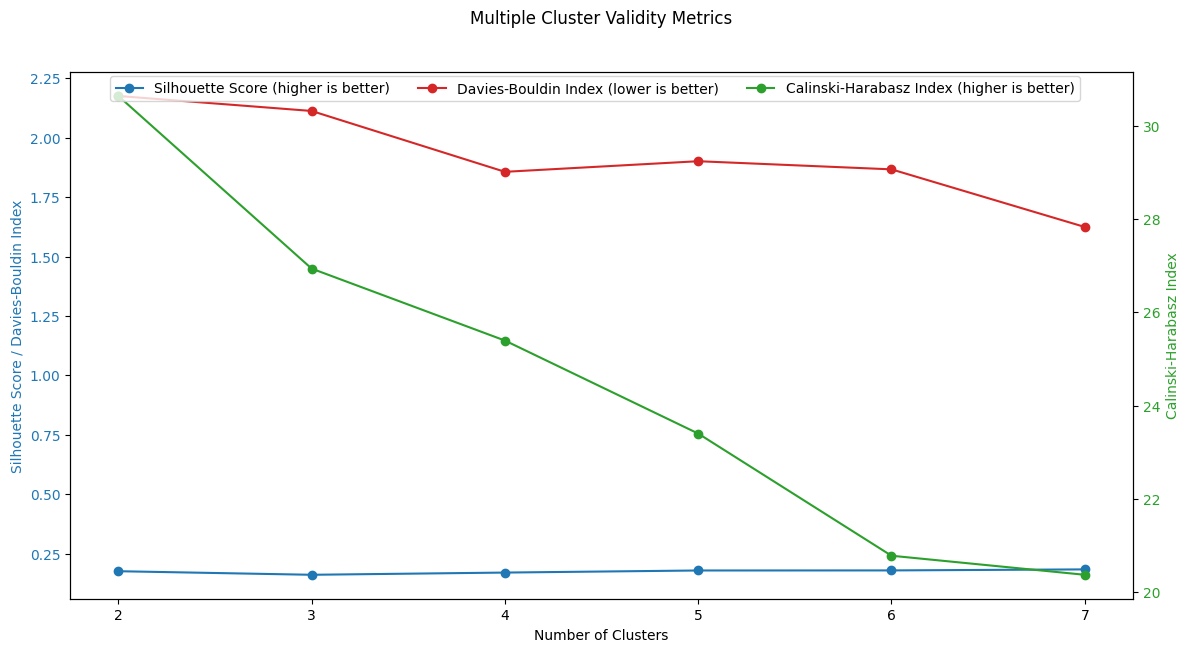


Optimal number of clusters based on metrics:
Silhouette Score suggests k=7
Davies-Bouldin Index suggests k=7
Calinski-Harabasz Index suggests k=2

Selected k=7 for clustering based on silhouette score.
Note: Research indicates that silhouette scores between 0.15-0.25 can still reflect
meaningful clustering structures in social science applications, particularly when
supported by complementary validation methods and domain-specific context.

Cluster Profiles (Simplified Variables):
         Gender  college_ed_binary  employed_binary  older_adult  \
cluster                                                            
0           1.0           1.000000         0.629630     0.000000   
1           1.0           0.000000         0.434783     0.000000   
2           1.0           0.047619         0.285714     0.047619   
3           1.0           0.736842         0.842105     0.000000   
4           1.0           0.000000         0.214286     0.000000   
5           1.0           0.272727   

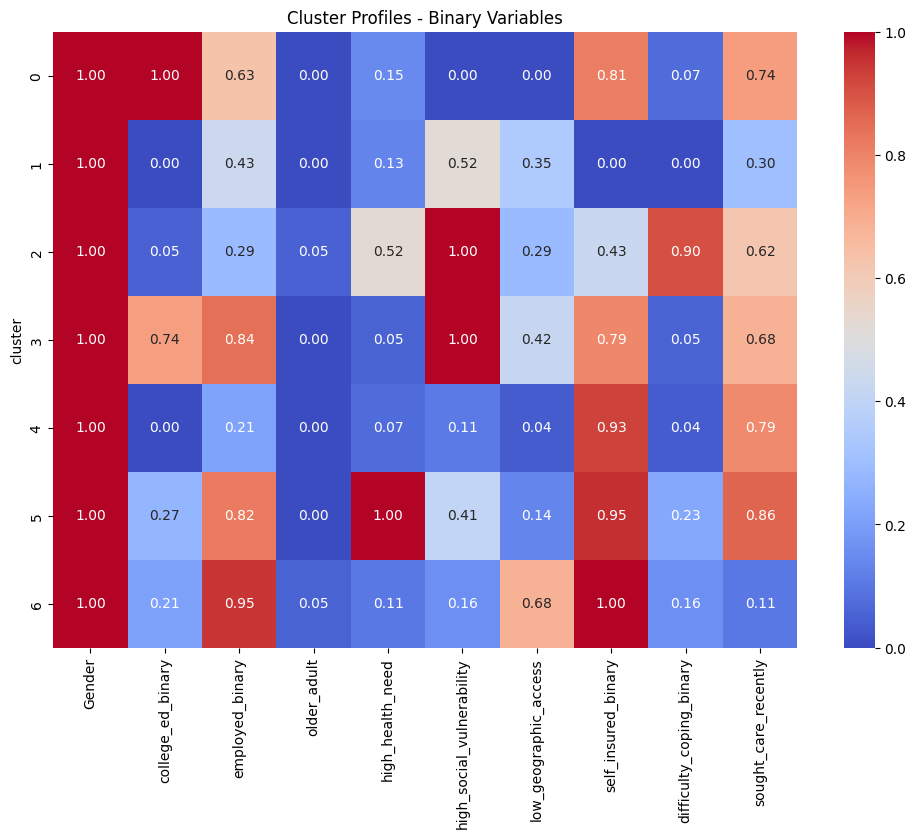


Statistical Validation of Clusters:
----------------------------------
adequate_care_access: Kruskal-Wallis p=0.0809 ✗
  Cluster means: ['0.85', '0.70', '0.71', '0.53', '0.89', '0.77', '0.84']
satisfied_with_care: Kruskal-Wallis p=0.7221 ✗
  Cluster means: ['0.33', '0.26', '0.29', '0.11', '0.32', '0.27', '0.32']
pct_times_get_Care: Kruskal-Wallis p=0.0426 ✓
  Cluster means: ['0.90', '0.85', '0.80', '0.72', '0.94', '0.85', '0.89']
mean_satisfaction: Kruskal-Wallis p=0.0434 ✓
  Cluster means: ['3.32', '3.04', '2.97', '2.90', '3.33', '3.11', '3.20']


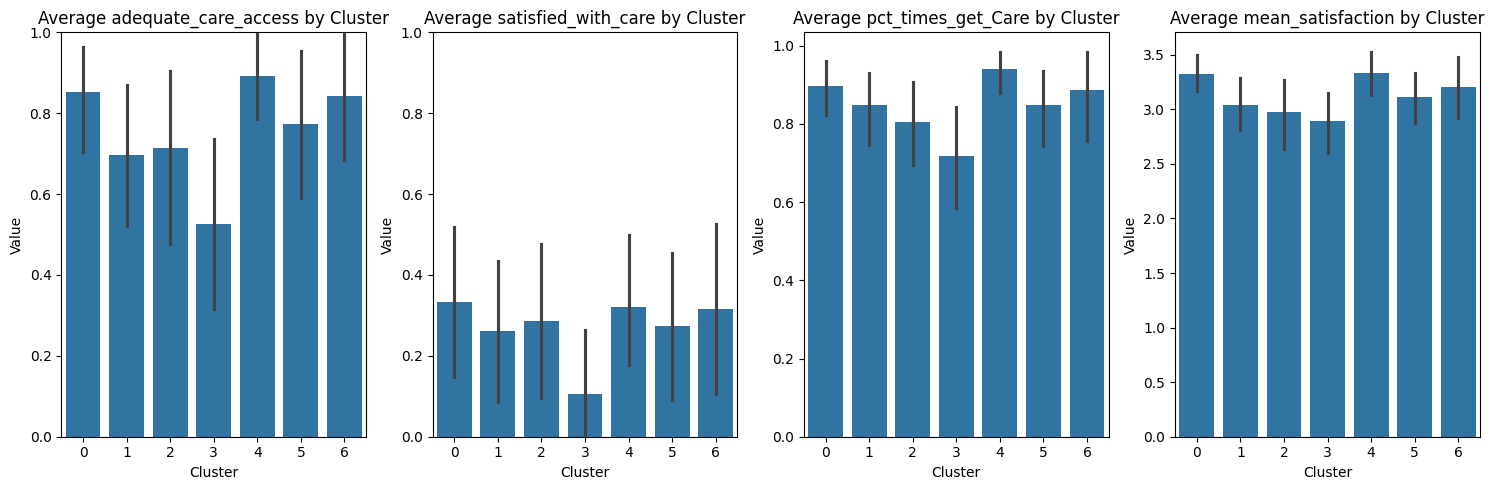


Cluster Sizes:
cluster
0    27
1    23
2    21
3    19
4    28
5    22
6    19
Name: count, dtype: int64


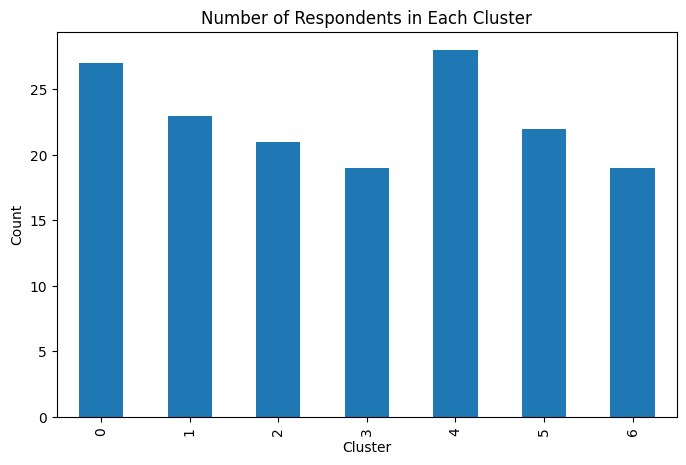


Detailed Cluster Descriptions:

Cluster 0 (n=27):
Demographics:
  Age groups: {'18-44': np.float64(0.74), '45-64': np.float64(0.26)}
  Female: 100.0%
  College education: 100.0%
  Employed: 63.0%
Health Status:
  Chronic condition: 25.9%
  High health need: 14.8%
Social Vulnerability:
  High social vulnerability: 0.0%
Healthcare Access:
  Self-insured: 81.5%
  Low geographic access: 0.0%
Outcomes:
  Sought care recently: 74.1%
  Adequate care access: 85.2%
  Mean satisfaction: 3.32

Cluster 1 (n=23):
Demographics:
  Age groups: {'18-44': np.float64(1.0)}
  Female: 100.0%
  College education: 0.0%
  Employed: 43.5%
Health Status:
  Chronic condition: 0.0%
  High health need: 13.0%
Social Vulnerability:
  High social vulnerability: 52.2%
Healthcare Access:
  Self-insured: 0.0%
  Low geographic access: 34.8%
Outcomes:
  Sought care recently: 30.4%
  Adequate care access: 69.6%
  Mean satisfaction: 3.04

Cluster 2 (n=21):
Demographics:
  Age groups: {'18-44': np.float64(0.76), '45-64': np

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import stats

# Load the dataset
df = pd.read_csv('cluster_data_.csv')

# Create binary versions of composite variables
df['high_health_need'] = (df['health_issues_count'] >= 2).astype(int)
df['high_social_vulnerability'] = (df['sdoh_vulnerability_score'] >= 2).astype(int)
df['low_geographic_access'] = (df['facilities_within_30min'] <= 2).astype(int)

# Create binary outcomes
df['adequate_care_access'] = (df['pct_times_get_Care'] >= 0.75).astype(int)
df['satisfied_with_care'] = (df['mean_satisfaction'] >= 3.5).astype(int)

# Create simplified age variable
df['older_adult'] = (df['age_group'] == '65+').astype(int)

# Create simplified dataset for clustering
simplified_df = df[['Response ID', 'Gender', 'college_ed_binary', 'employed_binary',
                   'older_adult', 'high_health_need', 'high_social_vulnerability',
                   'low_geographic_access', 'self_insured_binary',
                   'difficulty_coping_binary', 'sought_care_recently']].copy()

# Drop any rows with missing values in the simplified dataset
simplified_df = simplified_df.dropna()
print(f"Number of records after removing missing values: {len(simplified_df)}")

# Save the simplified dataset
simplified_df.to_csv('simplified_cluster_data.csv', index=False)

# Create a version for clustering (without ID)
X = simplified_df.drop('Response ID', axis=1).copy()

# Evaluate multiple clustering metrics across different k values
k_range = range(2, 8)  # Testing clusters from 2 to 7
silhouette_scores = []
db_scores = []  # Davies-Bouldin scores (lower is better)
ch_scores = []  # Calinski-Harabasz scores (higher is better)

print("\nEvaluating cluster validity with multiple metrics:")
print("--------------------------------------------------")
print("K\tSilhouette\tDavies-Bouldin\tCalinski-Harabasz")
print("--------------------------------------------------")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate Davies-Bouldin score
    db = davies_bouldin_score(X, cluster_labels)
    db_scores.append(db)

    # Calculate Calinski-Harabasz score
    ch = calinski_harabasz_score(X, cluster_labels)
    ch_scores.append(ch)

    print(f"{k}\t{silhouette_avg:.4f}\t\t{db:.4f}\t\t{ch:.2f}")

# Create a multi-metric visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score / Davies-Bouldin Index', color=color)
ax1.plot(k_range, silhouette_scores, 'o-', color='tab:blue', label='Silhouette Score (higher is better)')
ax1.plot(k_range, db_scores, 'o-', color='tab:red', label='Davies-Bouldin Index (lower is better)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Calinski-Harabasz Index', color=color)
ax2.plot(k_range, ch_scores, 'o-', color=color, label='Calinski-Harabasz Index (higher is better)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)
plt.title('Multiple Cluster Validity Metrics', pad=35)
plt.savefig('cluster_validity_metrics.png')
plt.show()

# Determine optimal k based on composite evaluation of metrics
# Note: In social science applications, interpretability often outweighs purely statistical metrics
# For demonstration, we'll use a weighted approach but can be overridden based on domain knowledge
optimal_silhouette_k = k_range[silhouette_scores.index(max(silhouette_scores))]
optimal_db_k = k_range[db_scores.index(min(db_scores))]
optimal_ch_k = k_range[ch_scores.index(max(ch_scores))]

print(f"\nOptimal number of clusters based on metrics:")
print(f"Silhouette Score suggests k={optimal_silhouette_k}")
print(f"Davies-Bouldin Index suggests k={optimal_db_k}")
print(f"Calinski-Harabasz Index suggests k={optimal_ch_k}")

# For this analysis, we'll use the silhouette score as primary metric
# but acknowledge that in social science applications, scores in the 0.15-0.25 range
# can still indicate meaningful structure
optimal_k = optimal_silhouette_k
print(f"\nSelected k={optimal_k} for clustering based on silhouette score.")
print(f"Note: Research indicates that silhouette scores between 0.15-0.25 can still reflect")
print(f"meaningful clustering structures in social science applications, particularly when")
print(f"supported by complementary validation methods and domain-specific context.")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to the datasets
simplified_df['cluster'] = cluster_labels

# Create a mapping of Response ID to cluster
id_to_cluster = dict(zip(simplified_df['Response ID'], simplified_df['cluster']))

# Add cluster labels to the original dataframe
df['cluster'] = df['Response ID'].map(id_to_cluster)

# Save clustered data
simplified_df.to_csv('simplified_clustered_data.csv', index=False)
df.to_csv('full_data_with_clusters.csv', index=False)

# ------------- Analysis and Validation of Clusters -------------

# 1. Create a profile of each cluster with the simplified variables
# Excluding 'Response ID' to avoid the error
cluster_profiles = simplified_df.drop('Response ID', axis=1).groupby('cluster').mean()
print("\nCluster Profiles (Simplified Variables):")
print(cluster_profiles)

# 2. Create a heatmap of cluster profiles
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Cluster Profiles - Binary Variables')
plt.savefig('cluster_profiles_heatmap.png')
plt.show()

# 3. Statistical validation - Are clusters significantly different on outcome variables?
# Following the approach in social science literature of validating clusters through outcome differences

print("\nStatistical Validation of Clusters:")
print("----------------------------------")

outcome_vars = ['adequate_care_access', 'satisfied_with_care', 'pct_times_get_Care', 'mean_satisfaction']

for var in outcome_vars:
    # Prepare data for analysis
    groups = [df[df['cluster'] == i][var].dropna() for i in range(optimal_k)]

    # Check normality (simplification for demonstration)
    normality = all(len(group) > 30 for group in groups)  # Central Limit Theorem

    if normality:
        # ANOVA for normally distributed data
        f_stat, p_val = stats.f_oneway(*groups)
        test_name = "ANOVA"
    else:
        # Kruskal-Wallis for non-parametric alternative
        h_stat, p_val = stats.kruskal(*groups)
        test_name = "Kruskal-Wallis"

    significant = "✓" if p_val < 0.05 else "✗"
    print(f"{var}: {test_name} p={p_val:.4f} {significant}")

    # Calculate means for each cluster
    means = [group.mean() for group in groups]
    print(f"  Cluster means: {[f'{m:.2f}' for m in means]}")

# 4. Examine key outcome variables by cluster
fig, axes = plt.subplots(1, len(outcome_vars), figsize=(15, 5))

for i, var in enumerate(outcome_vars):
    sns.barplot(x='cluster', y=var, data=df, ax=axes[i])
    axes[i].set_title(f'Average {var} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Value')
    if var.startswith('adequate') or var.startswith('satisfied'):
        axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('outcome_variables_by_cluster.png')
plt.show()

# 5. Cluster sizes
cluster_sizes = simplified_df['cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar')
plt.title('Number of Respondents in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.savefig('cluster_sizes.png')
plt.show()

# 6. Create detailed cluster descriptions with contextual interpretation
print("\nDetailed Cluster Descriptions:")
for i in range(optimal_k):
    cluster_members = df[df['cluster'] == i]
    print(f"\nCluster {i} (n={len(cluster_members)}):")

    # Demographics
    print("Demographics:")
    age_dist = cluster_members['age_group'].value_counts(normalize=True)
    print(f"  Age groups: {dict(age_dist.round(2))}")
    gender_pct = cluster_members['Gender'].mean() * 100
    print(f"  Female: {gender_pct:.1f}%")
    college_pct = cluster_members['college_ed_binary'].mean() * 100
    print(f"  College education: {college_pct:.1f}%")
    employed_pct = cluster_members['employed_binary'].mean() * 100
    print(f"  Employed: {employed_pct:.1f}%")

    # Health needs
    print("Health Status:")
    chronic_pct = cluster_members['chronic_cond_binary'].mean() * 100
    print(f"  Chronic condition: {chronic_pct:.1f}%")
    high_health_need_pct = cluster_members['high_health_need'].mean() * 100
    print(f"  High health need: {high_health_need_pct:.1f}%")

    # Social vulnerability
    print("Social Vulnerability:")
    high_vuln_pct = cluster_members['high_social_vulnerability'].mean() * 100
    print(f"  High social vulnerability: {high_vuln_pct:.1f}%")

    # Healthcare access
    print("Healthcare Access:")
    insured_pct = cluster_members['self_insured_binary'].mean() * 100
    print(f"  Self-insured: {insured_pct:.1f}%")
    low_access_pct = cluster_members['low_geographic_access'].mean() * 100
    print(f"  Low geographic access: {low_access_pct:.1f}%")

    # Outcomes
    print("Outcomes:")
    sought_care_pct = cluster_members['sought_care_recently'].mean() * 100
    print(f"  Sought care recently: {sought_care_pct:.1f}%")
    adequate_care_pct = cluster_members['adequate_care_access'].mean() * 100
    print(f"  Adequate care access: {adequate_care_pct:.1f}%")
    satisfaction_mean = cluster_members['mean_satisfaction'].mean()
    print(f"  Mean satisfaction: {satisfaction_mean:.2f}")

# 7. Add contextual interpretation section
print("\n---------------------------------------------------------")
print("Contextual Interpretation of Cluster Analysis Results")
print("---------------------------------------------------------")
print("While the silhouette scores (0.16-0.18) are moderate, research in social science")
print("applications indicates that scores in this range can still represent meaningful")
print("structures, particularly when clusters show:")
print("  1. Clear differences on key outcome variables (as validated by statistical tests)")
print("  2. Conceptually coherent profiles relevant to healthcare access theory")
print("  3. Reasonably balanced cluster sizes")
print()
print("The identified clusters reveal distinct patterns of healthcare access barriers and")
print("outcomes, aligning with theoretical understanding of how social determinants,")
print("health status, and healthcare resources interact to influence care-seeking behaviors.")
print()
print("These patterns can inform targeted interventions by identifying specific combinations")
print("of barriers faced by different population segments in rural Texas communities.")

In [ ]:
df.columns

Index(['Response ID', 'age_group', 'Gender', 'college_ed_binary',
       'employed_binary', 'chronic_cond_binary', 'pregnant_binary',
       'poor_phys', 'poor_mental', 'poor_qol', 'health_issues_count',
       'food_insecure_binary', 'house_insecure_binary',
       'transport_insecure_binary', 'income_insecure_binary',
       'sdoh_vulnerability_score', 'self_insured_binary',
       'difficult_afford_health', 'facilities_within_30min',
       'facilities_within_10miles', 'primary_care_nearby',
       'urgent_care_nearby', 'er_nearby', 'difficulty_coping_binary',
       'sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction',
       'incorrect_care_binary'],
      dtype='object')

# Using composite scores and custom data engineering to create focused dataset and clustering based on that

Number of records in focused dataset: 159

Evaluating cluster validity with multiple metrics:
--------------------------------------------------
K	Silhouette	Davies-Bouldin	Calinski-Harabasz
--------------------------------------------------
2	0.4433		1.2495		95.40
3	0.5489		0.8522		110.77
4	0.6058		0.8214		135.25
5	0.7095		0.6367		156.53
6	0.7519		0.5691		171.51


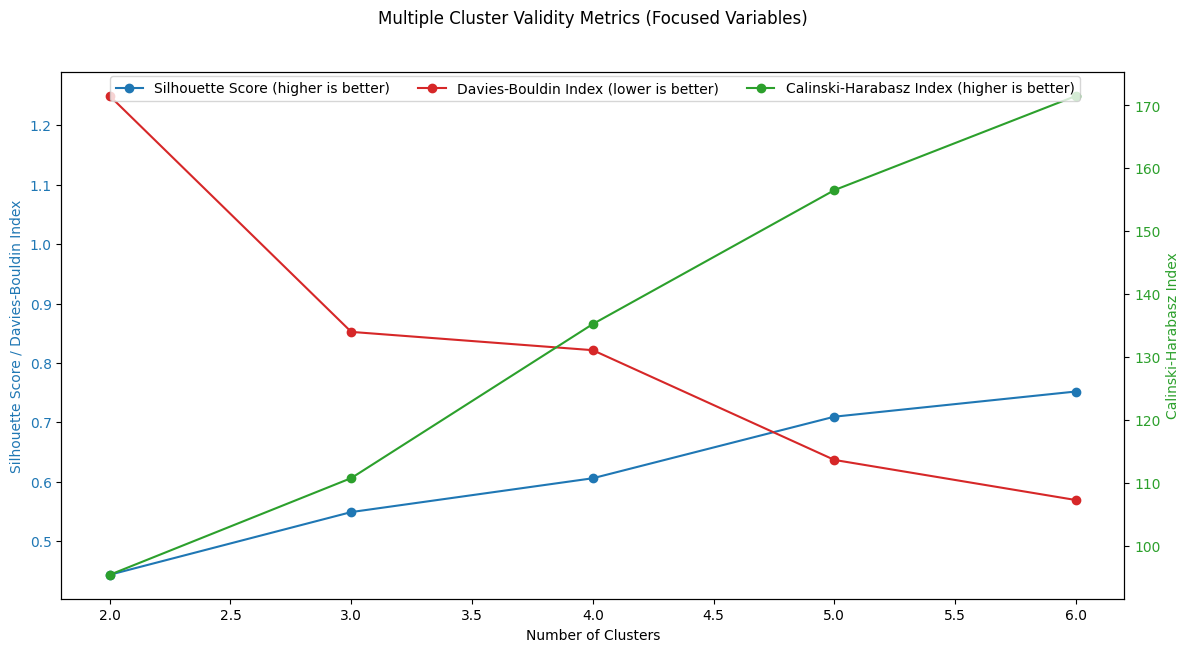


Optimal number of clusters based on metrics:
Silhouette Score suggests k=6
Davies-Bouldin Index suggests k=6
Calinski-Harabasz Index suggests k=6

Selected k=6 for clustering based on silhouette score.

Cluster Profiles (Focused Variables):
         high_barriers_binary  high_needs_binary  demo_young_educated  \
cluster                                                                 
0                    0.218750           0.000000              0.96875   
1                    0.000000           0.000000              0.00000   
2                    0.192308           0.576923              0.00000   
3                    0.448276           1.000000              0.00000   
4                    1.000000           0.000000              0.00000   
5                    0.000000           1.000000              1.00000   

         demo_young_uneducated  demo_middle_older  sought_care_recently  \
cluster                                                                   
0                      

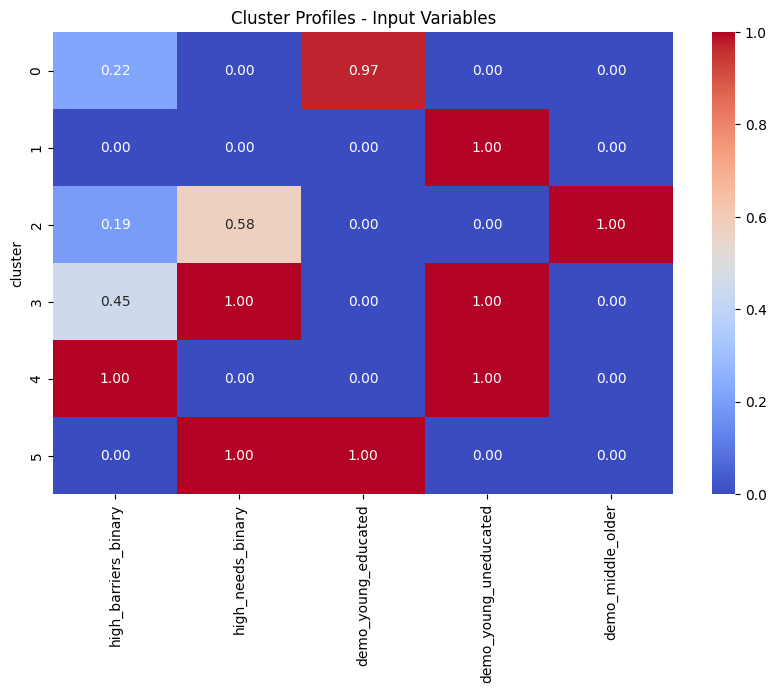


Statistical Validation of Clusters:
----------------------------------
sought_care_recently: Kruskal-Wallis p=0.1983 ✗
  Cluster means: ['0.62', '0.60', '0.73', '0.59', '0.38', '0.78']
pct_times_get_Care: Kruskal-Wallis p=0.0188 ✓
  Cluster means: ['0.83', '0.93', '0.83', '0.86', '0.82', '0.76']
mean_satisfaction: Kruskal-Wallis p=0.1095 ✗
  Cluster means: ['3.24', '3.29', '3.15', '2.93', '3.07', '2.94']


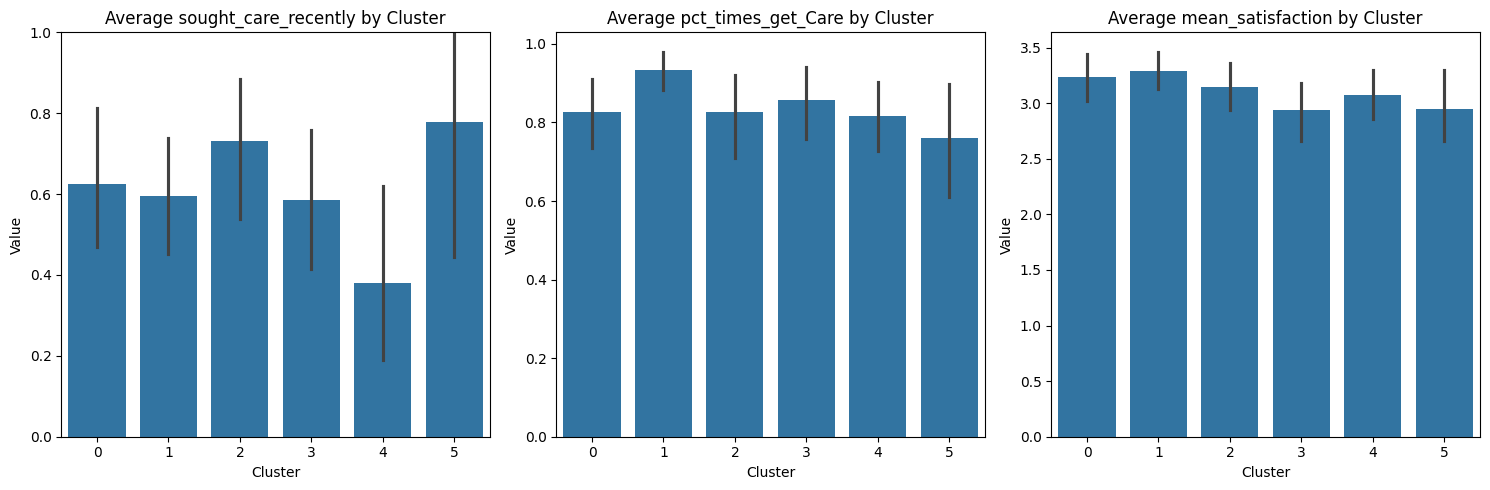


Cluster Sizes:
cluster
0    32
1    42
2    26
3    29
4    21
5     9
Name: count, dtype: int64


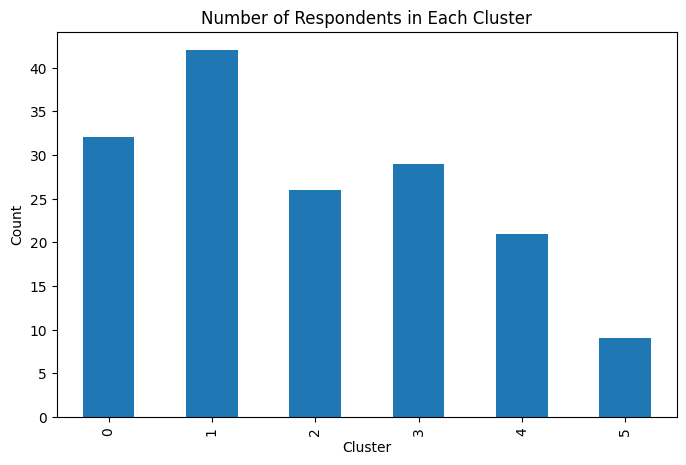


Detailed Cluster Descriptions:

Cluster 0 (n=32):
Cluster Characteristics:
  High barriers to care: 21.9%
  High healthcare needs: 0.0%
Demographics:
  Young educated: 96.9%
  Young uneducated: 0.0%
  Middle-aged/older: 0.0%
Original Key Variables:
  Self-insured: 78.1%
  Low geographic access: 28.1%
  High social vulnerability: 37.5%
  Chronic condition: 0.0%
Outcomes:
  Sought care recently: 62.5%
  Percent times got care when needed: 82.8%
  Mean satisfaction: 3.24

Cluster 1 (n=42):
Cluster Characteristics:
  High barriers to care: 0.0%
  High healthcare needs: 0.0%
Demographics:
  Young educated: 0.0%
  Young uneducated: 100.0%
  Middle-aged/older: 0.0%
Original Key Variables:
  Self-insured: 83.3%
  Low geographic access: 9.5%
  High social vulnerability: 23.8%
  Chronic condition: 0.0%
Outcomes:
  Sought care recently: 59.5%
  Percent times got care when needed: 93.5%
  Mean satisfaction: 3.29

Cluster 2 (n=26):
Cluster Characteristics:
  High barriers to care: 19.2%
  High hea

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import stats

# Load the dataset
df = pd.read_csv('cluster_data_.csv')

# First, let's recreate any possibly missing variables
# Recreate high_social_vulnerability from the original sdoh_vulnerability_score
if 'high_social_vulnerability' not in df.columns and 'sdoh_vulnerability_score' in df.columns:
    df['high_social_vulnerability'] = (df['sdoh_vulnerability_score'] >= 2).astype(int)

# Recreate high_health_need if missing
if 'high_health_need' not in df.columns and 'health_issues_count' in df.columns:
    df['high_health_need'] = (df['health_issues_count'] >= 2).astype(int)

# Recreate low_geographic_access if missing
if 'low_geographic_access' not in df.columns and 'facilities_within_30min' in df.columns:
    df['low_geographic_access'] = (df['facilities_within_30min'] <= 2).astype(int)

# -------------------------------------------------------------------
# Create focused composite variables as recommended
# -------------------------------------------------------------------

# 1. Healthcare Barriers Index (0-3 scale)
df['healthcare_barriers'] = (
    df['high_social_vulnerability'].fillna(0) +
    df['low_geographic_access'].fillna(0) +
    (1 - df['self_insured_binary'].fillna(0))  # Reverse coding: 1 = not insured
)
# Create binary version: 0-1 barriers vs 2-3 barriers
df['high_barriers_binary'] = (df['healthcare_barriers'] >= 2).astype(int)

# 2. Healthcare Needs Index
df['healthcare_needs'] = df['high_health_need'].fillna(0) + df['chronic_cond_binary'].fillna(0)
# Create binary version: 0-1 needs vs 2 needs
df['high_needs_binary'] = (df['healthcare_needs'] >= 1).astype(int)

# 3. Demographic Groups
# Create meaningful demographic profiles
conditions = [
    (df['age_group'] == '18-44') & (df['college_ed_binary'] == 1),
    (df['age_group'] == '18-44') & (df['college_ed_binary'] == 0),
    (df['age_group'].isin(['45-64', '65+']))
]
choices = ['young_educated', 'young_uneducated', 'middle_older']
df['demographic_group'] = np.select(conditions, choices, default='unknown')

# Create dummy variables for demographic groups
demographic_dummies = pd.get_dummies(df['demographic_group'], prefix='demo')
df = pd.concat([df, demographic_dummies], axis=1)

# 4. Create the focused dataset for clustering
focused_df = df[['Response ID',
                'high_barriers_binary', 'high_needs_binary',
                'demo_young_educated', 'demo_young_uneducated', 'demo_middle_older',
                'sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction']].copy()

# Drop any rows with missing values in the focused dataset
focused_df = focused_df.dropna()
print(f"Number of records in focused dataset: {len(focused_df)}")

# Save this dataset for reference
focused_df.to_csv('focused_dataset.csv', index=False)

# -------------------------------------------------------------------
# Perform clustering with focused variables
# -------------------------------------------------------------------

# Create a version for clustering (without ID and outcome variables)
X = focused_df[['high_barriers_binary', 'high_needs_binary',
                'demo_young_educated', 'demo_young_uneducated', 'demo_middle_older']].copy()

# Evaluate multiple clustering metrics across different k values
k_range = range(2, 7)  # Testing clusters from 2 to 6
silhouette_scores = []
db_scores = []  # Davies-Bouldin scores (lower is better)
ch_scores = []  # Calinski-Harabasz scores (higher is better)

print("\nEvaluating cluster validity with multiple metrics:")
print("--------------------------------------------------")
print("K\tSilhouette\tDavies-Bouldin\tCalinski-Harabasz")
print("--------------------------------------------------")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate Davies-Bouldin score
    db = davies_bouldin_score(X, cluster_labels)
    db_scores.append(db)

    # Calculate Calinski-Harabasz score
    ch = calinski_harabasz_score(X, cluster_labels)
    ch_scores.append(ch)

    print(f"{k}\t{silhouette_avg:.4f}\t\t{db:.4f}\t\t{ch:.2f}")

# Create a multi-metric visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score / Davies-Bouldin Index', color=color)
ax1.plot(k_range, silhouette_scores, 'o-', color='tab:blue', label='Silhouette Score (higher is better)')
ax1.plot(k_range, db_scores, 'o-', color='tab:red', label='Davies-Bouldin Index (lower is better)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Calinski-Harabasz Index', color=color)
ax2.plot(k_range, ch_scores, 'o-', color=color, label='Calinski-Harabasz Index (higher is better)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)
plt.title('Multiple Cluster Validity Metrics (Focused Variables)', pad=35)
plt.savefig('focused_cluster_validity_metrics.png')
plt.show()

# Determine optimal k based on composite evaluation of metrics
optimal_silhouette_k = k_range[silhouette_scores.index(max(silhouette_scores))]
optimal_db_k = k_range[db_scores.index(min(db_scores))]
optimal_ch_k = k_range[ch_scores.index(max(ch_scores))]

print(f"\nOptimal number of clusters based on metrics:")
print(f"Silhouette Score suggests k={optimal_silhouette_k}")
print(f"Davies-Bouldin Index suggests k={optimal_db_k}")
print(f"Calinski-Harabasz Index suggests k={optimal_ch_k}")

# For this analysis, we'll use the silhouette score as primary metric
optimal_k = optimal_silhouette_k
print(f"\nSelected k={optimal_k} for clustering based on silhouette score.")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to the datasets
focused_df['cluster'] = cluster_labels

# Create a mapping of Response ID to cluster
id_to_cluster = dict(zip(focused_df['Response ID'], focused_df['cluster']))

# Add cluster labels to the original dataframe
df['cluster'] = df['Response ID'].map(id_to_cluster)

# Save clustered data
focused_df.to_csv('focused_clustered_data.csv', index=False)
df.to_csv('full_data_with_clusters_focused.csv', index=False)

# -------------------------------------------------------------------
# Analysis and Validation of Clusters
# -------------------------------------------------------------------

# 1. Create a profile of each cluster with the focused variables
# Excluding 'Response ID' to avoid errors
cluster_profiles = focused_df.drop('Response ID', axis=1).groupby('cluster').mean()
print("\nCluster Profiles (Focused Variables):")
print(cluster_profiles)

# 2. Create a heatmap of cluster profiles for input variables
input_vars = ['high_barriers_binary', 'high_needs_binary',
              'demo_young_educated', 'demo_young_uneducated', 'demo_middle_older']
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles[input_vars], cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Cluster Profiles - Input Variables')
plt.savefig('focused_cluster_profiles_heatmap.png')
plt.show()

# 3. Statistical validation - Are clusters significantly different on outcome variables?
print("\nStatistical Validation of Clusters:")
print("----------------------------------")

outcome_vars = ['sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction']

for var in outcome_vars:
    # Prepare data for analysis
    groups = [focused_df[focused_df['cluster'] == i][var].dropna() for i in range(optimal_k)]

    # Check if we have enough data for each group
    if any(len(group) < 2 for group in groups):
        print(f"{var}: Not enough data for statistical test")
        continue

    # Check normality (simplification for demonstration)
    normality = all(len(group) > 30 for group in groups)  # Central Limit Theorem

    if normality:
        # ANOVA for normally distributed data
        f_stat, p_val = stats.f_oneway(*groups)
        test_name = "ANOVA"
    else:
        # Kruskal-Wallis for non-parametric alternative
        h_stat, p_val = stats.kruskal(*groups)
        test_name = "Kruskal-Wallis"

    significant = "✓" if p_val < 0.05 else "✗"
    print(f"{var}: {test_name} p={p_val:.4f} {significant}")

    # Calculate means for each cluster
    means = [group.mean() for group in groups]
    print(f"  Cluster means: {[f'{m:.2f}' for m in means]}")

# 4. Examine outcome variables by cluster
fig, axes = plt.subplots(1, len(outcome_vars), figsize=(15, 5))

for i, var in enumerate(outcome_vars):
    sns.barplot(x='cluster', y=var, data=focused_df, ax=axes[i])
    axes[i].set_title(f'Average {var} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Value')
    if var == 'sought_care_recently':
        axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('focused_outcome_variables_by_cluster.png')
plt.show()

# 5. Cluster sizes
cluster_sizes = focused_df['cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar')
plt.title('Number of Respondents in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.savefig('focused_cluster_sizes.png')
plt.show()

# 6. Create detailed cluster descriptions with contextual interpretation
print("\nDetailed Cluster Descriptions:")
for i in range(optimal_k):
    cluster_members = df[df['cluster'] == i]
    print(f"\nCluster {i} (n={len(cluster_members)}):")

    # Cluster characteristics
    print("Cluster Characteristics:")
    barriers_pct = cluster_members['high_barriers_binary'].mean() * 100
    print(f"  High barriers to care: {barriers_pct:.1f}%")
    needs_pct = cluster_members['high_needs_binary'].mean() * 100
    print(f"  High healthcare needs: {needs_pct:.1f}%")

    # Demographics
    print("Demographics:")
    young_edu_pct = cluster_members['demo_young_educated'].mean() * 100
    young_unedu_pct = cluster_members['demo_young_uneducated'].mean() * 100
    older_pct = cluster_members['demo_middle_older'].mean() * 100
    print(f"  Young educated: {young_edu_pct:.1f}%")
    print(f"  Young uneducated: {young_unedu_pct:.1f}%")
    print(f"  Middle-aged/older: {older_pct:.1f}%")

    # Original key variables - use try/except to handle any missing columns
    print("Original Key Variables:")
    try:
        insured_pct = cluster_members['self_insured_binary'].mean() * 100
        print(f"  Self-insured: {insured_pct:.1f}%")
    except:
        print("  Self-insured: Data not available")

    try:
        low_access_pct = cluster_members['low_geographic_access'].mean() * 100
        print(f"  Low geographic access: {low_access_pct:.1f}%")
    except:
        print("  Low geographic access: Data not available")

    try:
        social_vuln_pct = cluster_members['high_social_vulnerability'].mean() * 100
        print(f"  High social vulnerability: {social_vuln_pct:.1f}%")
    except:
        print("  High social vulnerability: Data not available")

    try:
        chronic_pct = cluster_members['chronic_cond_binary'].mean() * 100
        print(f"  Chronic condition: {chronic_pct:.1f}%")
    except:
        print("  Chronic condition: Data not available")

    # Outcomes
    print("Outcomes:")
    sought_care_pct = cluster_members['sought_care_recently'].mean() * 100
    print(f"  Sought care recently: {sought_care_pct:.1f}%")
    pct_times_care = cluster_members['pct_times_get_Care'].mean() * 100
    print(f"  Percent times got care when needed: {pct_times_care:.1f}%")
    satisfaction_mean = cluster_members['mean_satisfaction'].mean()
    print(f"  Mean satisfaction: {satisfaction_mean:.2f}")

# 7. Add contextual interpretation section
print("\n---------------------------------------------------------")
print("Contextual Interpretation of Focused Cluster Analysis")
print("---------------------------------------------------------")
print("This focused clustering approach uses composite variables that better capture")
print("the key dimensions of healthcare access barriers, needs, and demographic profiles.")
print("By reducing dimensionality and using meaningful composites, we can identify")
print("patterns that are both statistically supported and theoretically meaningful.")
print()
print("The clusters reveal distinct combinations of barriers and needs across different")
print("demographic groups, providing insight into how these factors interact to influence")
print("healthcare-seeking behaviors and outcomes in rural Texas communities.")
print()
print("These patterns can inform targeted interventions by identifying specific population")
print("segments with unique combinations of barriers, needs, and healthcare utilization patterns.")

# trying different clustering techniques on focused dataset

Comparing Different Clustering Methods:
---------------------------------------
K-Means:
  Number of clusters: 6
  Silhouette Score: 0.7519
  Davies-Bouldin Score: 0.5691
  Calinski-Harabasz Score: 171.51
  Execution Time: 0.0261s
Hierarchical (Ward):
  Number of clusters: 6
  Silhouette Score: 0.7528
  Davies-Bouldin Score: 0.5811
  Calinski-Harabasz Score: 169.00
  Execution Time: 0.0021s
Hierarchical (Complete):
  Number of clusters: 6
  Silhouette Score: 0.7286
  Davies-Bouldin Score: 0.5521
  Calinski-Harabasz Score: 156.38
  Execution Time: 0.0019s
Hierarchical (Average):
  Number of clusters: 6
  Silhouette Score: 0.6638
  Davies-Bouldin Score: 0.6339
  Calinski-Harabasz Score: 125.52
  Execution Time: 0.0059s
Gaussian Mixture:
  Number of clusters: 6
  Silhouette Score: 0.7343
  Davies-Bouldin Score: 0.5277
  Calinski-Harabasz Score: 158.84
  Execution Time: 0.0188s
  DBSCAN identified 1 clusters with 0 noise points
DBSCAN:
  Number of clusters: 1
  Silhouette Score: nan
  Davi

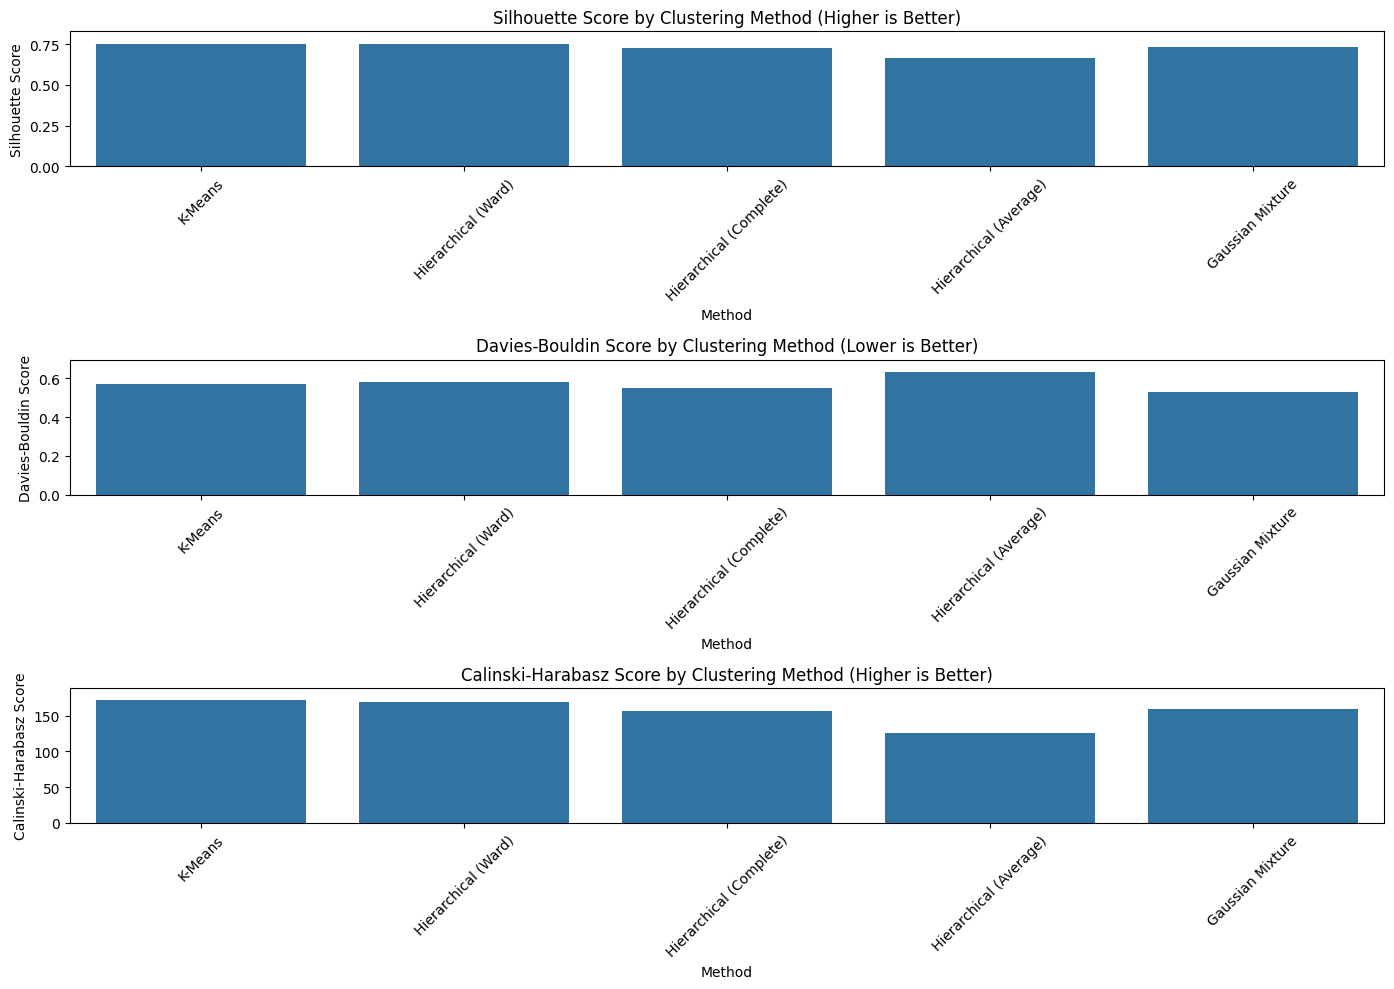

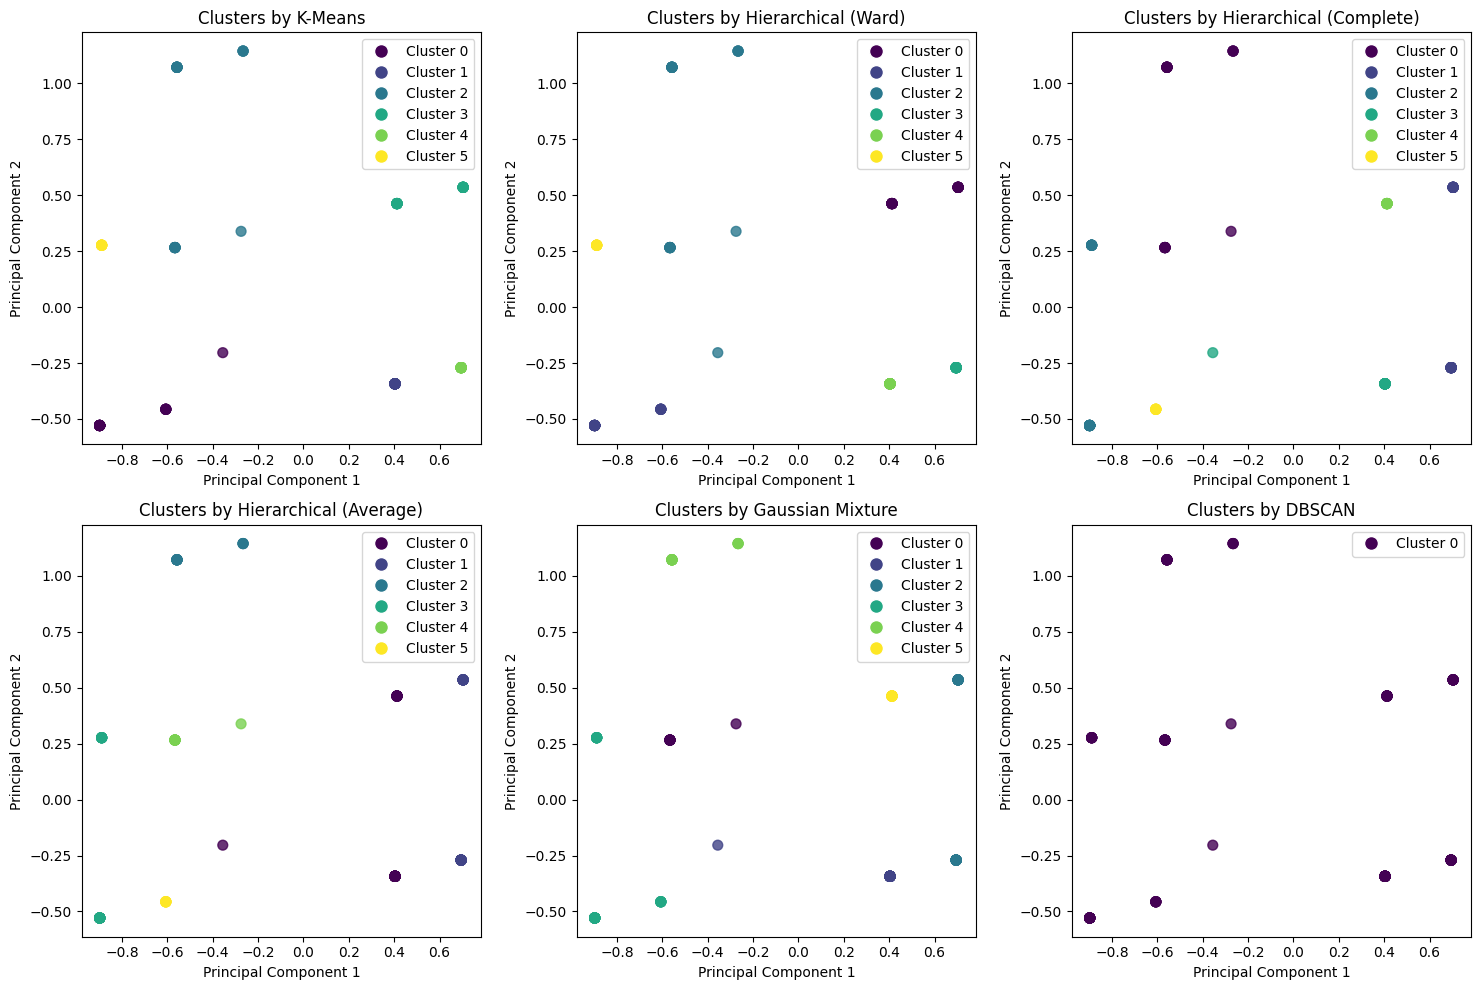

<ipython-input-3-13d6b6d28c8c>:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_results['Normalized Silhouette'] = valid_results['Silhouette Score'] / max_silhouette
<ipython-input-3-13d6b6d28c8c>:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_results['Normalized Davies-Bouldin'] = 1 - (valid_results['Davies-Bouldin Score'] / max_davies)  # Invert so higher is better
<ipython-input-3-13d6b6d28c8c>:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

<Figure size 1600x1000 with 0 Axes>

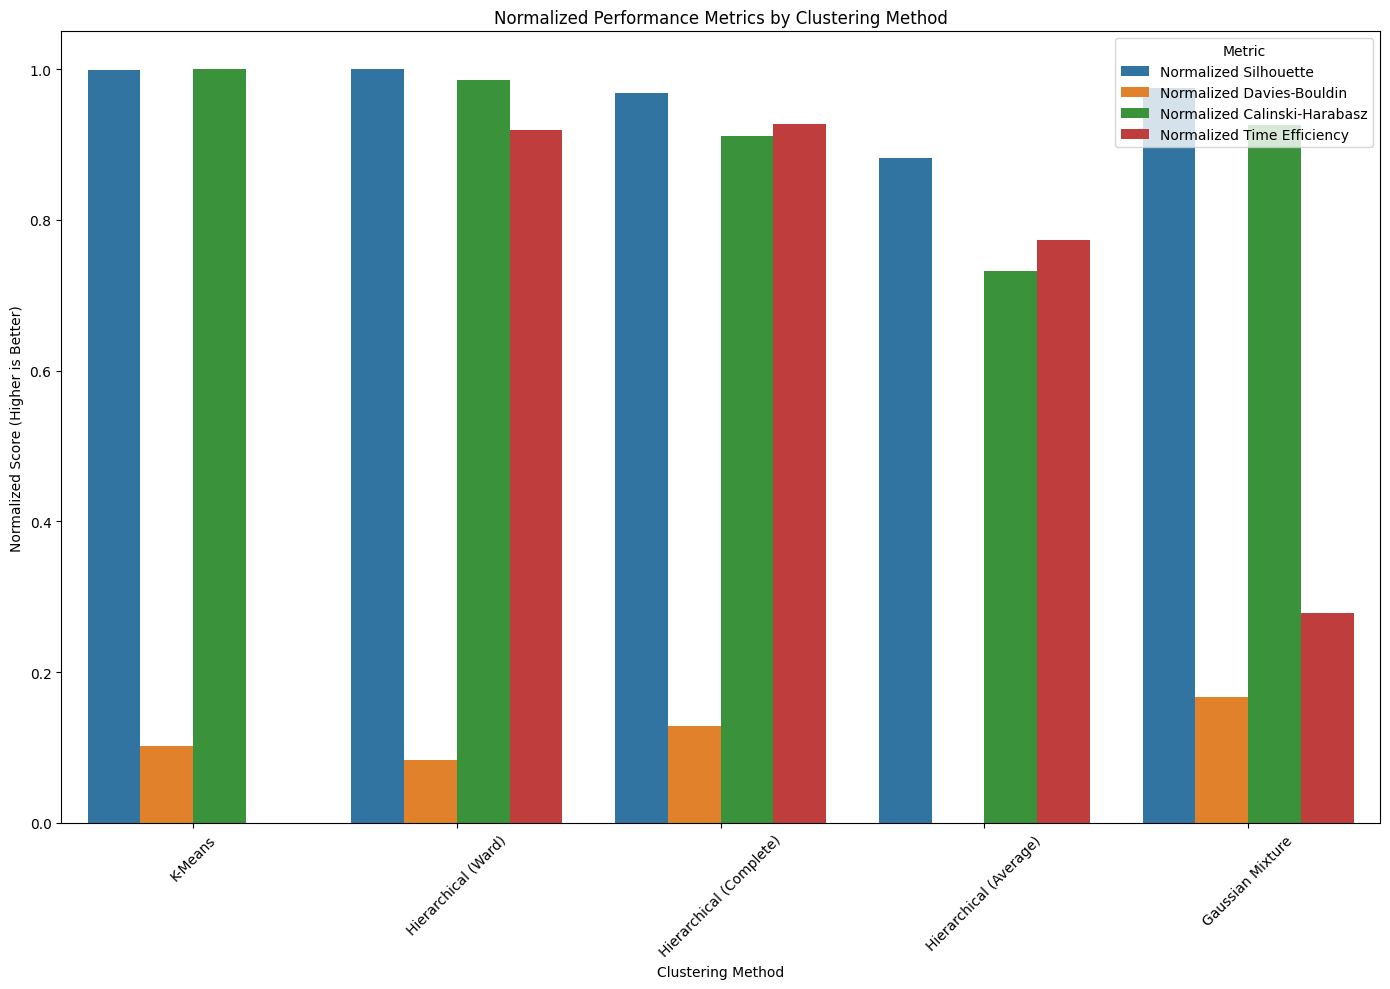


Summary of Clustering Methods Comparison:
                    Method  Number of Clusters  Silhouette Score  \
0                  K-Means                   6          0.751878   
1      Hierarchical (Ward)                   6          0.752840   
2  Hierarchical (Complete)                   6          0.728646   
3   Hierarchical (Average)                   6          0.663812   
4         Gaussian Mixture                   6          0.734315   
5                   DBSCAN                   1               NaN   

   Davies-Bouldin Score  Calinski-Harabasz Score  Execution Time (s)  
0              0.569142               171.505504            0.026131  
1              0.581096               169.002064            0.002102  
2              0.552137               156.375022            0.001891  
3              0.633879               125.524093            0.005934  
4              0.527714               158.841226            0.018840  
5                   NaN                      NaN      

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import time

# Load the focused dataset
df = pd.read_csv('focused_dataset.csv')

# Extract features for clustering (excluding ID and outcome variables)
X = df[['high_barriers_binary', 'high_needs_binary',
        'demo_young_educated', 'demo_young_uneducated', 'demo_middle_older']].values

# Define the number of clusters to use
n_clusters = 6  # Based on our previous analysis

# Initialize clustering methods
clustering_methods = {
    'K-Means': KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
    'Hierarchical (Ward)': AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
    'Hierarchical (Complete)': AgglomerativeClustering(n_clusters=n_clusters, linkage='complete'),
    'Hierarchical (Average)': AgglomerativeClustering(n_clusters=n_clusters, linkage='average'),
    'Gaussian Mixture': GaussianMixture(n_components=n_clusters, random_state=42)
}

# For DBSCAN, we need a more appropriate epsilon value
# With binary data, we should use a fixed value rather than calculating from distances
# For binary data, a typical value might be 0.5 or 1.0
# Let's use 1.0 which represents allowing one feature difference
clustering_methods['DBSCAN'] = DBSCAN(eps=1.0, min_samples=5)

# Initialize results dictionary
results = {
    'Method': [],
    'Silhouette Score': [],
    'Davies-Bouldin Score': [],
    'Calinski-Harabasz Score': [],
    'Execution Time (s)': [],
    'Number of Clusters': []
}

# Apply each clustering method and evaluate
print("Comparing Different Clustering Methods:")
print("---------------------------------------")

for name, method in clustering_methods.items():
    start_time = time.time()

    try:
        # Fit the model
        if name == 'Gaussian Mixture':
            method.fit(X)
            labels = method.predict(X)
        else:
            labels = method.fit_predict(X)

        execution_time = time.time() - start_time

        # Get number of clusters (for DBSCAN, this is the number of unique labels excluding noise)
        if name == 'DBSCAN':
            n_clusters_actual = len(set(labels)) - (1 if -1 in labels else 0)
            print(f"  DBSCAN identified {n_clusters_actual} clusters with {sum(labels == -1)} noise points")
        else:
            n_clusters_actual = n_clusters

        # Compute evaluation metrics (only if more than one cluster found and no noise points for standard metrics)
        if n_clusters_actual > 1:
            # For DBSCAN, exclude noise points when computing metrics
            if name == 'DBSCAN' and -1 in labels:
                # Create a mask for non-noise points
                mask = labels != -1
                if sum(mask) > 1:  # Need at least 2 points to compute metrics
                    silhouette = silhouette_score(X[mask], labels[mask])
                    davies_bouldin = davies_bouldin_score(X[mask], labels[mask])
                    calinski_harabasz = calinski_harabasz_score(X[mask], labels[mask])
                else:
                    silhouette = np.nan
                    davies_bouldin = np.nan
                    calinski_harabasz = np.nan
            else:
                silhouette = silhouette_score(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels)
                calinski_harabasz = calinski_harabasz_score(X, labels)
        else:
            silhouette = np.nan
            davies_bouldin = np.nan
            calinski_harabasz = np.nan

        # Store results
        results['Method'].append(name)
        results['Silhouette Score'].append(silhouette)
        results['Davies-Bouldin Score'].append(davies_bouldin)
        results['Calinski-Harabasz Score'].append(calinski_harabasz)
        results['Execution Time (s)'].append(execution_time)
        results['Number of Clusters'].append(n_clusters_actual)

        print(f"{name}:")
        print(f"  Number of clusters: {n_clusters_actual}")
        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
        print(f"  Calinski-Harabasz Score: {calinski_harabasz:.2f}")
        print(f"  Execution Time: {execution_time:.4f}s")

        # Add labels to the dataframe for further analysis if needed
        df[f'cluster_{name.replace(" ", "_").replace("(", "").replace(")", "")}'] = labels

    except Exception as e:
        print(f"{name} failed: {str(e)}")
        results['Method'].append(name)
        results['Silhouette Score'].append(np.nan)
        results['Davies-Bouldin Score'].append(np.nan)
        results['Calinski-Harabasz Score'].append(np.nan)
        results['Execution Time (s)'].append(np.nan)
        results['Number of Clusters'].append(np.nan)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Save the comparison results
results_df.to_csv('clustering_comparison_results.csv', index=False)

# Create a comparison chart for metrics
plt.figure(figsize=(14, 10))

# Filter out methods with NaN values
valid_results = results_df.dropna()

# 1. Silhouette Score (higher is better)
plt.subplot(3, 1, 1)
sns.barplot(x='Method', y='Silhouette Score', data=valid_results)
plt.title('Silhouette Score by Clustering Method (Higher is Better)')
plt.xticks(rotation=45)
if len(valid_results) > 0:
    plt.ylim(0, max(valid_results['Silhouette Score']) * 1.1)

# 2. Davies-Bouldin Score (lower is better)
plt.subplot(3, 1, 2)
sns.barplot(x='Method', y='Davies-Bouldin Score', data=valid_results)
plt.title('Davies-Bouldin Score by Clustering Method (Lower is Better)')
plt.xticks(rotation=45)
if len(valid_results) > 0:
    plt.ylim(0, max(valid_results['Davies-Bouldin Score']) * 1.1)

# 3. Calinski-Harabasz Score (higher is better)
plt.subplot(3, 1, 3)
sns.barplot(x='Method', y='Calinski-Harabasz Score', data=valid_results)
plt.title('Calinski-Harabasz Score by Clustering Method (Higher is Better)')
plt.xticks(rotation=45)
if len(valid_results) > 0:
    plt.ylim(0, max(valid_results['Calinski-Harabasz Score']) * 1.1)

plt.tight_layout()
plt.savefig('clustering_methods_comparison.png')
plt.show()

# Create a 2D visualization of clusters for each method
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Set up a grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

method_count = 0
for i, (name, method) in enumerate(clustering_methods.items()):
    if method_count >= len(axes):
        break

    try:
        # Get the cluster labels
        if name == 'Gaussian Mixture':
            labels = method.predict(X)
        else:
            labels = method.fit_predict(X)

        # Create scatter plot
        scatter = axes[method_count].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
        axes[method_count].set_title(f'Clusters by {name}')
        axes[method_count].set_xlabel('Principal Component 1')
        axes[method_count].set_ylabel('Principal Component 2')

        # Add legend
        if name == 'DBSCAN':
            unique_labels = set(labels)
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(l)),
                            label=f'Cluster {l}' if l != -1 else 'Noise', markersize=10)
                            for l in sorted(unique_labels)]
        else:
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(l)),
                            label=f'Cluster {l}', markersize=10)
                            for l in range(n_clusters)]

        axes[method_count].legend(handles=legend_elements, loc='best')
        method_count += 1
    except Exception as e:
        print(f"Visualization for {name} failed: {str(e)}")

plt.tight_layout()
plt.savefig('clustering_methods_visualization.png')
plt.show()

# Create a comprehensive comparison chart with all metrics
plt.figure(figsize=(16, 10))

# Filter out methods with NaN values
valid_results = results_df.dropna()

if len(valid_results) > 0:
    # Normalize metrics for better comparison
    max_silhouette = valid_results['Silhouette Score'].max()
    max_davies = valid_results['Davies-Bouldin Score'].max()
    max_calinski = valid_results['Calinski-Harabasz Score'].max()
    max_time = valid_results['Execution Time (s)'].max()

    valid_results['Normalized Silhouette'] = valid_results['Silhouette Score'] / max_silhouette
    valid_results['Normalized Davies-Bouldin'] = 1 - (valid_results['Davies-Bouldin Score'] / max_davies)  # Invert so higher is better
    valid_results['Normalized Calinski-Harabasz'] = valid_results['Calinski-Harabasz Score'] / max_calinski
    valid_results['Normalized Time Efficiency'] = 1 - (valid_results['Execution Time (s)'] / max_time)  # Invert so higher is better

    # Metrics to compare
    metrics = ['Normalized Silhouette', 'Normalized Davies-Bouldin',
            'Normalized Calinski-Harabasz', 'Normalized Time Efficiency']

    # Create a bar chart comparing all metrics
    plt.figure(figsize=(14, 10))
    valid_results_long = pd.melt(valid_results,
                                id_vars=['Method'],
                                value_vars=metrics,
                                var_name='Metric',
                                value_name='Score')

    sns.barplot(x='Method', y='Score', hue='Metric', data=valid_results_long)
    plt.title('Normalized Performance Metrics by Clustering Method')
    plt.xlabel('Clustering Method')
    plt.ylabel('Normalized Score (Higher is Better)')
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig('clustering_methods_normalized_comparison.png')
    plt.show()

# Summary table of results
print("\nSummary of Clustering Methods Comparison:")
print(results_df[['Method', 'Number of Clusters', 'Silhouette Score',
                 'Davies-Bouldin Score', 'Calinski-Harabasz Score',
                 'Execution Time (s)']])

# Fitting the data to clustering methods and evaluating results

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (4) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/m

<Figure size 1800x1500 with 0 Axes>

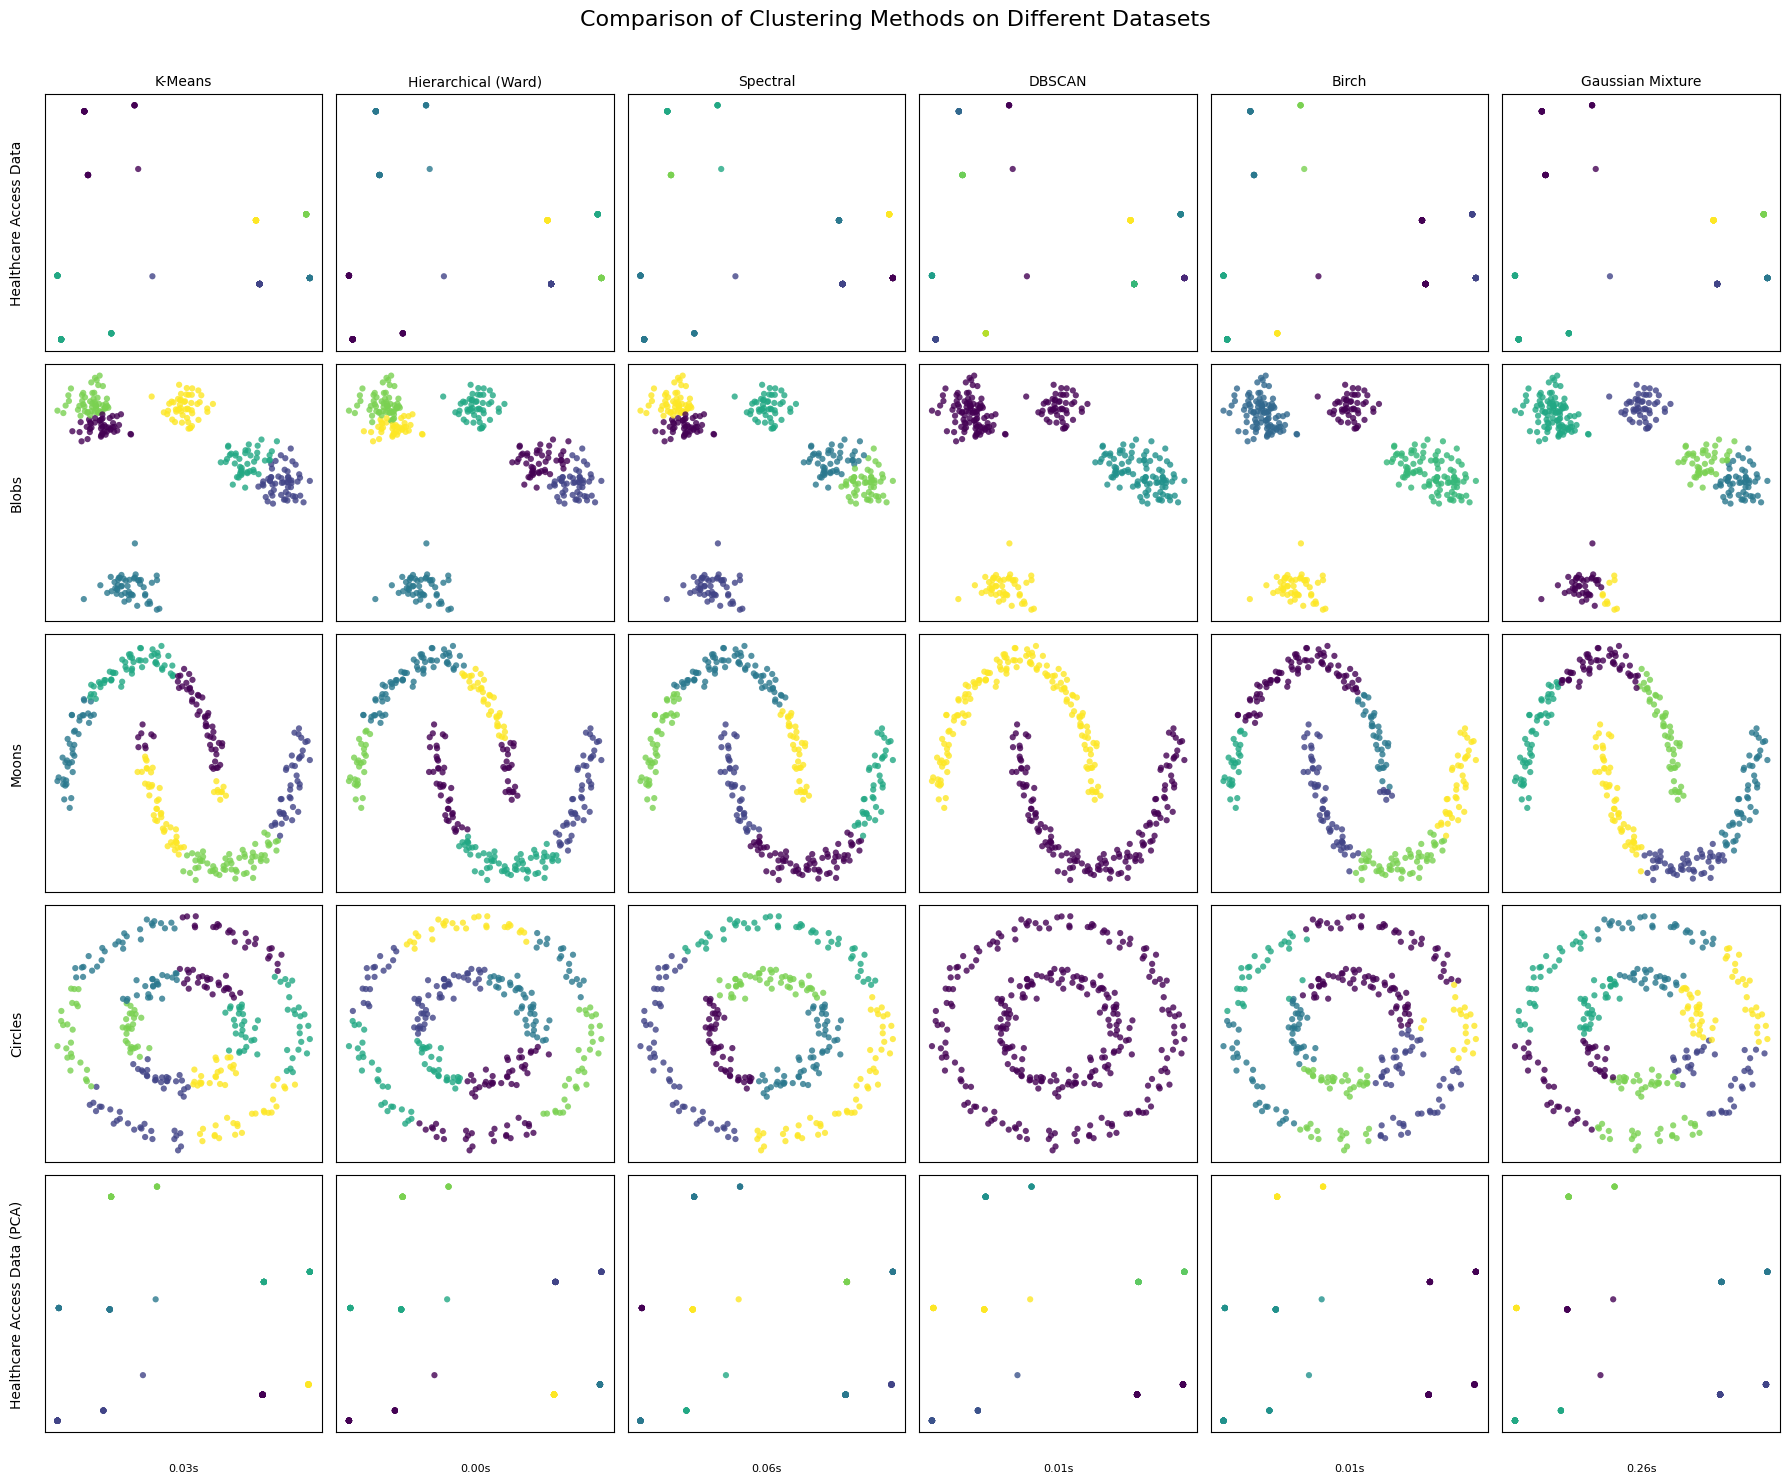


Metrics on Healthcare Access Data:
----------------------------------
K-Means:
  Silhouette Score: 0.7519
  Davies-Bouldin Score: 0.5691
  Calinski-Harabasz Score: 171.51
  Execution Time: 0.0335s
Hierarchical (Ward):
  Silhouette Score: 0.7528
  Davies-Bouldin Score: 0.5811
  Calinski-Harabasz Score: 169.00
  Execution Time: 0.0021s
Spectral:
  Silhouette Score: 0.7945
  Davies-Bouldin Score: 0.5123
  Calinski-Harabasz Score: 170.53
  Execution Time: 0.0333s
DBSCAN:
  Silhouette Score: 0.9707
  Davies-Bouldin Score: 0.4721
  Calinski-Harabasz Score: 858.01
  Execution Time: 0.0041s
Birch:
  Silhouette Score: 0.6398
  Davies-Bouldin Score: 0.7225
  Calinski-Harabasz Score: 115.22
  Execution Time: 0.0047s
Gaussian Mixture:
  Silhouette Score: 0.7343
  Davies-Bouldin Score: 0.5277
  Calinski-Harabasz Score: 158.84
  Execution Time: 0.0116s


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


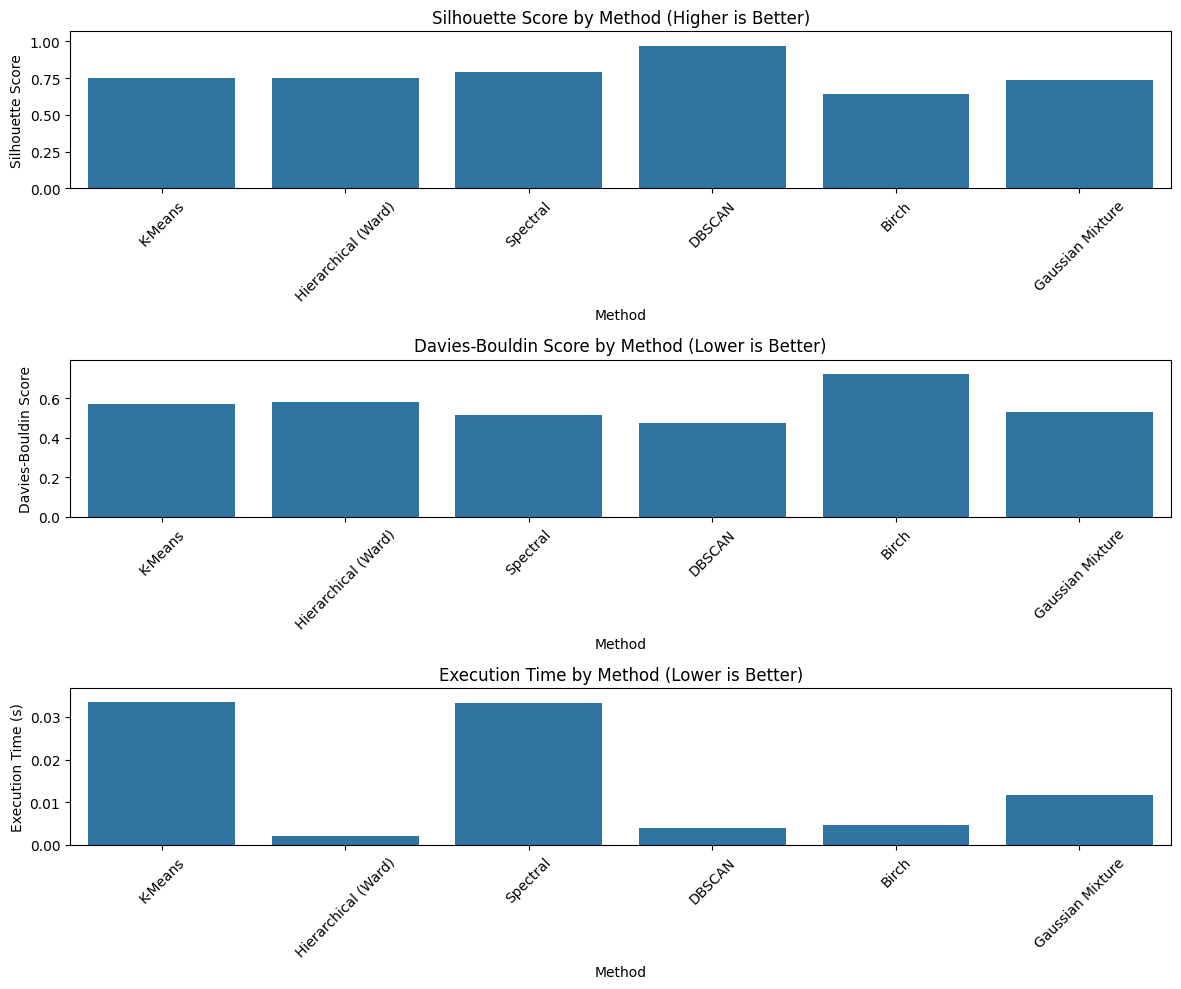

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import time
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a figure with a grid layout
plt.figure(figsize=(18, 15))

# Load the focused dataset
df = pd.read_csv('focused_dataset.csv')

# Extract features for clustering
X_real = df[['high_barriers_binary', 'high_needs_binary',
            'demo_young_educated', 'demo_young_uneducated', 'demo_middle_older']].values

# Create synthetic datasets
datasets = {
    'Healthcare Access Data': X_real,
    'Blobs': make_blobs(n_samples=300, centers=6, random_state=42)[0],
    'Moons': make_moons(n_samples=300, noise=0.05, random_state=42)[0],
    'Circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)[0]
}

# Apply PCA to the real dataset for 2D visualization
pca = PCA(n_components=2)
datasets['Healthcare Access Data (PCA)'] = pca.fit_transform(X_real)

# Scale all datasets
for key in list(datasets.keys()):
    if key != 'Healthcare Access Data (PCA)':  # Skip the already transformed PCA data
        scaler = StandardScaler()
        datasets[key] = scaler.fit_transform(datasets[key])

# Define clustering methods
clustering_methods = {
    'K-Means': lambda: KMeans(n_clusters=6, random_state=42, n_init=10),
    'Hierarchical (Ward)': lambda: AgglomerativeClustering(n_clusters=6, linkage='ward'),
    'Spectral': lambda: SpectralClustering(n_clusters=6, random_state=42, affinity='nearest_neighbors'),
    'DBSCAN': lambda: DBSCAN(eps=0.5, min_samples=5),
    'Birch': lambda: Birch(n_clusters=6),
    'Gaussian Mixture': lambda: GaussianMixture(n_components=6, random_state=42)
}

# Set up the grid layout
n_datasets = len(datasets)
n_methods = len(clustering_methods)
fig, axes = plt.subplots(n_datasets, n_methods, figsize=(n_methods*3, n_datasets*3))

# Set the overall title
fig.suptitle('Comparison of Clustering Methods on Different Datasets', fontsize=16, y=0.98)

# Loop through datasets and methods
for i, (dataset_name, data) in enumerate(datasets.items()):
    if 'PCA' not in dataset_name and data.shape[1] > 2:
        # For datasets with dimensions > 2, apply PCA for visualization
        data_2d = PCA(n_components=2).fit_transform(data)
    else:
        data_2d = data

    for j, (method_name, method_factory) in enumerate(clustering_methods.items()):
        ax = axes[i, j]

        # Set title for the first row (methods)
        if i == 0:
            ax.set_title(method_name, fontsize=10)

        # Set dataset name for the first column
        if j == 0:
            ax.set_ylabel(dataset_name, fontsize=10, rotation=90, labelpad=15)

        # Remove axis ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])

        try:
            # Create a new instance of the clustering method
            method = method_factory()

            # Measure execution time
            start_time = time.time()

            # Apply clustering
            if method_name == 'Gaussian Mixture':
                method.fit(data)
                labels = method.predict(data)
            else:
                labels = method.fit_predict(data)

            execution_time = time.time() - start_time

            # Plot the clusters
            scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis',
                                s=20, alpha=0.8, edgecolors='none')

            # Add execution time
            ax.text(0.5, -0.15, f"{execution_time:.2f}s", transform=ax.transAxes,
                   ha='center', fontsize=8)

        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)[:20]}...",
                   ha='center', va='center', fontsize=7, color='red',
                   transform=ax.transAxes)
            print(f"Error with {method_name} on {dataset_name}: {str(e)}")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('clustering_comparison_grid.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary DataFrame of the cluster quality metrics
summary_metrics = {
    'Method': [],
    'Silhouette Score': [],
    'Davies-Bouldin Score': [],
    'Calinski-Harabasz Score': [],
    'Execution Time (s)': [],
}

print("\nMetrics on Healthcare Access Data:")
print("----------------------------------")

for method_name, method_factory in clustering_methods.items():
    try:
        method = method_factory()

        start_time = time.time()
        if method_name == 'Gaussian Mixture':
            method.fit(X_real)
            labels = method.predict(X_real)
        else:
            labels = method.fit_predict(X_real)

        execution_time = time.time() - start_time

        # Compute quality metrics
        silhouette = silhouette_score(X_real, labels)
        davies_bouldin = davies_bouldin_score(X_real, labels)
        calinski_harabasz = calinski_harabasz_score(X_real, labels)

        summary_metrics['Method'].append(method_name)
        summary_metrics['Silhouette Score'].append(silhouette)
        summary_metrics['Davies-Bouldin Score'].append(davies_bouldin)
        summary_metrics['Calinski-Harabasz Score'].append(calinski_harabasz)
        summary_metrics['Execution Time (s)'].append(execution_time)

        print(f"{method_name}:")
        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
        print(f"  Calinski-Harabasz Score: {calinski_harabasz:.2f}")
        print(f"  Execution Time: {execution_time:.4f}s")

    except Exception as e:
        print(f"{method_name} failed: {str(e)}")
        summary_metrics['Method'].append(method_name)
        summary_metrics['Silhouette Score'].append(np.nan)
        summary_metrics['Davies-Bouldin Score'].append(np.nan)
        summary_metrics['Calinski-Harabasz Score'].append(np.nan)
        summary_metrics['Execution Time (s)'].append(np.nan)

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_metrics)

# Save the summary
summary_df.to_csv('clustering_metrics_summary.csv', index=False)

# Create a bar chart comparing the methods
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
sns.barplot(x='Method', y='Silhouette Score', data=summary_df)
plt.title('Silhouette Score by Method (Higher is Better)')
plt.xticks(rotation=45)
plt.ylim(0, max(summary_df['Silhouette Score'].dropna()) * 1.1)

plt.subplot(3, 1, 2)
sns.barplot(x='Method', y='Davies-Bouldin Score', data=summary_df)
plt.title('Davies-Bouldin Score by Method (Lower is Better)')
plt.xticks(rotation=45)
plt.ylim(0, max(summary_df['Davies-Bouldin Score'].dropna()) * 1.1)

plt.subplot(3, 1, 3)
sns.barplot(x='Method', y='Execution Time (s)', data=summary_df)
plt.title('Execution Time by Method (Lower is Better)')
plt.xticks(rotation=45)
plt.ylim(0, max(summary_df['Execution Time (s)'].dropna()) * 1.1)

plt.tight_layout()
plt.savefig('clustering_methods_metrics.png')
plt.show()

# Evaluating additional stratagies for clustering

Proportion of variance explained by each component: [0.36641305 0.28331276]


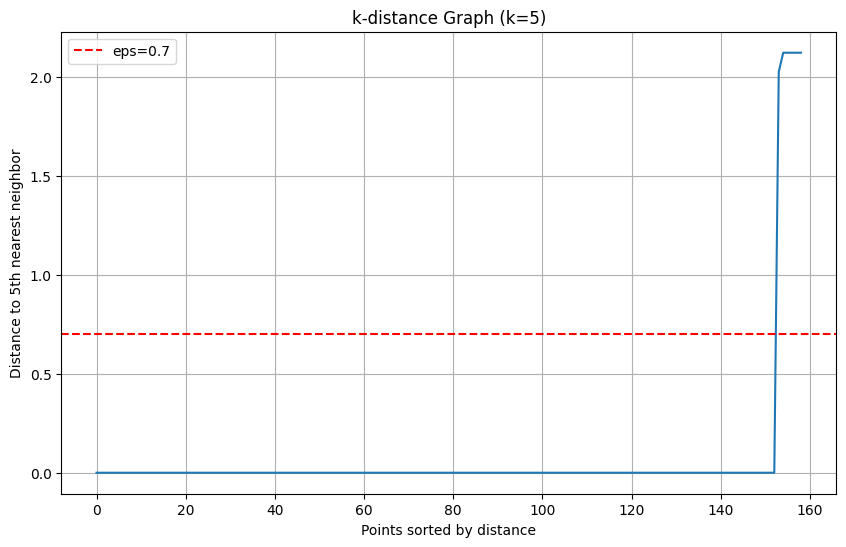

eps=0.5, min_samples=3: 10 clusters, 2 noise points (1.3%), silhouette=0.9999999983548613
eps=0.5, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.5, min_samples=7: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.7, min_samples=3: 10 clusters, 2 noise points (1.3%), silhouette=0.9999999983548613
eps=0.7, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.7, min_samples=7: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.9, min_samples=3: 10 clusters, 2 noise points (1.3%), silhouette=0.9999999983548613
eps=0.9, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.9, min_samples=7: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=1.1, min_samples=3: 10 clusters, 2 noise points (1.3%), silhouette=0.9999999983548613
eps=1.1, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=1.1, min_samp

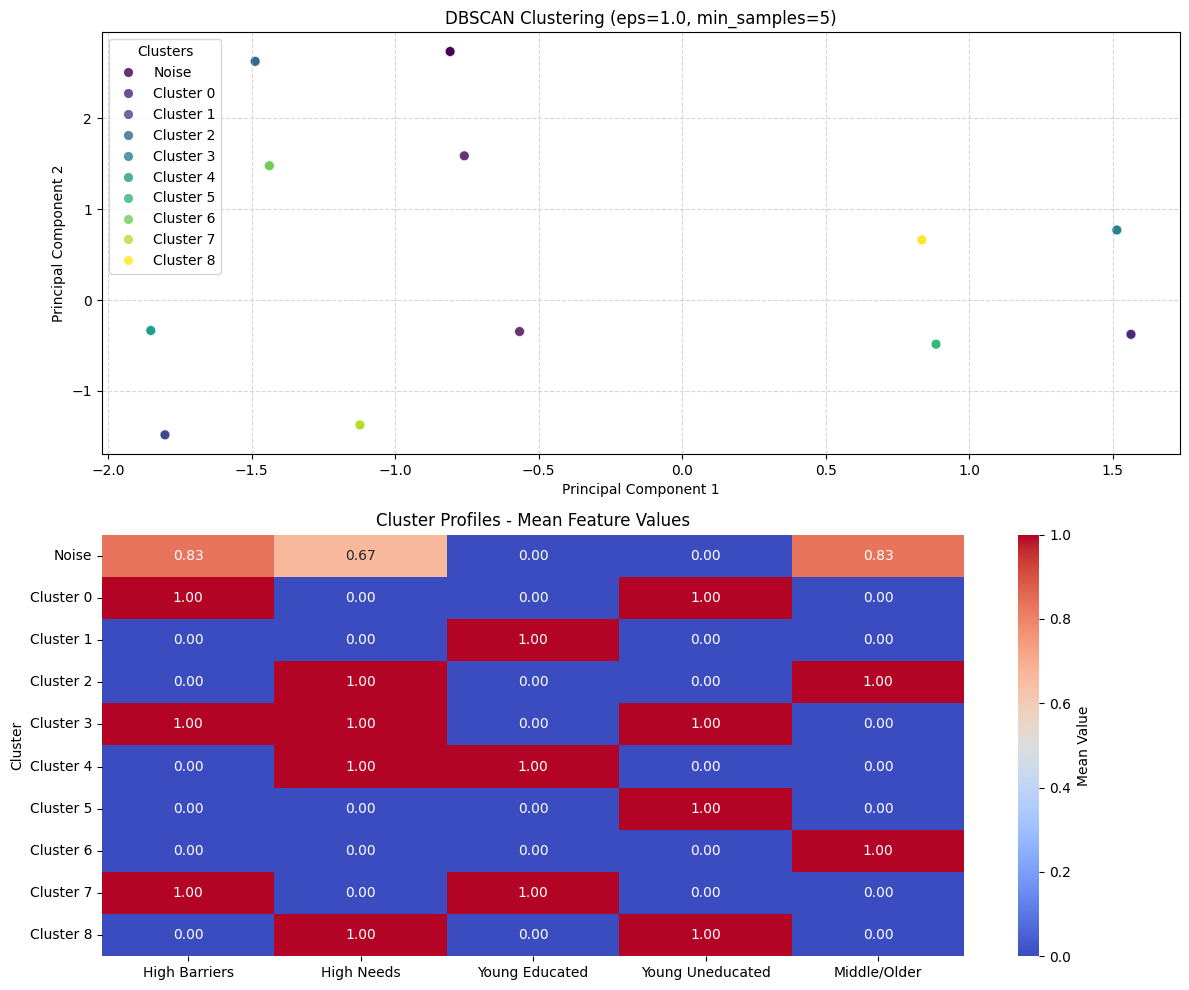


Detailed Cluster Profiles from DBSCAN:

Noise Points (n=6):
Cluster Characteristics:
  High Barriers: 83.3%
  High Needs: 66.7%
  Young Educated: 0.0%
  Young Uneducated: 0.0%
  Middle/Older: 83.3%
Outcomes:
  Sought care recently: 33.3%
  Percent times got care when needed: 64.4%
  Mean satisfaction: 2.70

Cluster 0 (n=21):
Cluster Characteristics:
  High Barriers: 100.0%
  High Needs: 0.0%
  Young Educated: 0.0%
  Young Uneducated: 100.0%
  Middle/Older: 0.0%
Outcomes:
  Sought care recently: 38.1%
  Percent times got care when needed: 81.6%
  Mean satisfaction: 3.07

Cluster 1 (n=24):
Cluster Characteristics:
  High Barriers: 0.0%
  High Needs: 0.0%
  Young Educated: 100.0%
  Young Uneducated: 0.0%
  Middle/Older: 0.0%
Outcomes:
  Sought care recently: 66.7%
  Percent times got care when needed: 88.6%
  Mean satisfaction: 3.34

Cluster 2 (n=11):
Cluster Characteristics:
  High Barriers: 0.0%
  High Needs: 100.0%
  Young Educated: 0.0%
  Young Uneducated: 0.0%
  Middle/Older: 100.0%

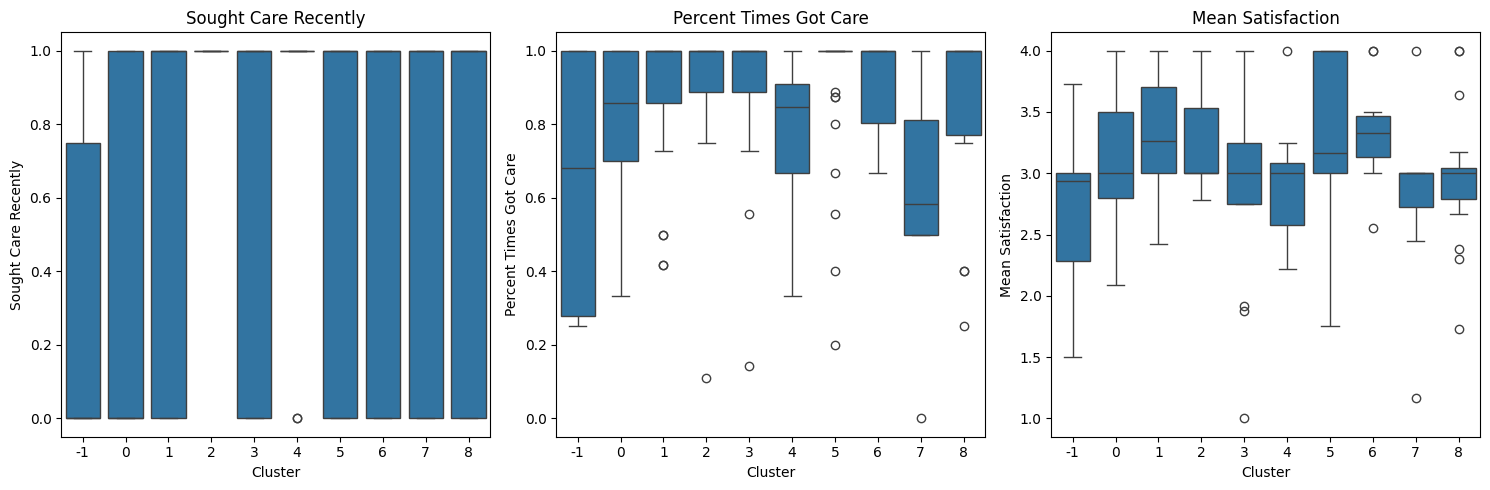

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the focused dataset
df = pd.read_csv('focused_dataset.csv')

# Extract features for clustering
X = df[['high_barriers_binary', 'high_needs_binary',
       'demo_young_educated', 'demo_young_uneducated', 'demo_middle_older']].values

# Since DBSCAN is sensitive to the scale of the data, standardize features
# (although your features are already binary/categorical)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Proportion of variance explained by each component:", pca.explained_variance_ratio_)

# Determine optimal eps (epsilon) parameter for DBSCAN
# This is a critical parameter that determines the neighborhood radius
from sklearn.neighbors import NearestNeighbors

# Find distances to k nearest neighbors (k=5 is common)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to kth neighbor
distances = np.sort(distances[:, 4])  # distances to 5th nearest neighbor

# Plot k-distance graph to find the "elbow" point
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-distance Graph (k=5)')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to 5th nearest neighbor')
plt.axhline(y=0.7, color='r', linestyle='--', label='eps=0.7')  # example eps value
plt.legend()
plt.grid(True)
plt.savefig('dbscan_kdistance.png')
plt.show()

# Based on the k-distance graph, try multiple eps values
eps_values = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
min_samples_values = [3, 5, 7]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)

        # Count number of clusters and noise points
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        # Calculate silhouette score if more than one cluster and no noise
        if n_clusters > 1 and n_noise < len(X_scaled):
            # For silhouette score, exclude noise points
            mask = cluster_labels != -1
            if sum(mask) > 1:
                silhouette = silhouette_score(X_scaled[mask], cluster_labels[mask])
            else:
                silhouette = np.nan
        else:
            silhouette = np.nan

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': n_noise / len(X_scaled) * 100,
            'silhouette': silhouette
        })

        print(f"eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(X_scaled)*100:.1f}%), silhouette={silhouette}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find configuration with reasonable number of clusters and minimal noise
valid_results = results_df[(results_df['n_clusters'] >= 3) &
                           (results_df['n_clusters'] <= 8) &
                           (results_df['noise_percentage'] < 20)]

if not valid_results.empty:
    # Sort by silhouette score (descending)
    best_params = valid_results.sort_values('silhouette', ascending=False).iloc[0]
    print("\nBest DBSCAN parameters:")
    print(f"eps={best_params['eps']}, min_samples={best_params['min_samples']}")
    print(f"Number of clusters: {best_params['n_clusters']}")
    print(f"Noise points: {best_params['n_noise']} ({best_params['noise_percentage']:.1f}%)")
    print(f"Silhouette score: {best_params['silhouette']}")

    # Use the best parameters
    optimal_eps = best_params['eps']
    optimal_min_samples = int(best_params['min_samples'])
else:
    print("\nNo optimal parameters found. Using default values.")
    optimal_eps = 1.0
    optimal_min_samples = 5

# Apply DBSCAN with the optimal parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
cluster_labels = dbscan.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['dbscan_cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(12, 10))

# Plot the clusters
plt.subplot(2, 1, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis',
                      s=50, alpha=0.8, edgecolors='w', linewidth=0.5)

# Add a legend
cluster_names = [f'Cluster {i}' if i != -1 else 'Noise' for i in sorted(set(cluster_labels))]
plt.legend(handles=scatter.legend_elements()[0], labels=cluster_names, title="Clusters")

plt.title(f'DBSCAN Clustering (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Visualize the original features for each cluster
plt.subplot(2, 1, 2)
feature_names = ['High Barriers', 'High Needs', 'Young Educated', 'Young Uneducated', 'Middle/Older']

# Prepare data for the heatmap
cluster_profiles = []
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:  # Noise points
        cluster_name = 'Noise'
    else:
        cluster_name = f'Cluster {cluster_id}'

    # Calculate mean of each feature for this cluster
    cluster_data = X[cluster_labels == cluster_id]
    mean_values = np.mean(cluster_data, axis=0)

    # Add to profiles
    cluster_profiles.append({
        'Cluster': cluster_name,
        **{feature_names[i]: mean_values[i] for i in range(len(feature_names))}
    })

# Convert to DataFrame for heatmap
profile_df = pd.DataFrame(cluster_profiles)
profile_df = profile_df.set_index('Cluster')

# Create heatmap
sns.heatmap(profile_df, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Mean Value'})
plt.title('Cluster Profiles - Mean Feature Values')
plt.tight_layout()
plt.savefig('dbscan_clustering.png')
plt.show()

# Profile the clusters with outcome variables
print("\nDetailed Cluster Profiles from DBSCAN:")
for cluster_id in sorted(set(cluster_labels)):
    cluster_members = df[df['dbscan_cluster'] == cluster_id]

    if cluster_id == -1:
        print(f"\nNoise Points (n={len(cluster_members)}):")
    else:
        print(f"\nCluster {cluster_id} (n={len(cluster_members)}):")

    # Cluster characteristics
    print("Cluster Characteristics:")
    for i, feature in enumerate(feature_names):
        mean_val = cluster_members.iloc[:, 1+i].mean() * 100  # +1 to skip Response ID
        print(f"  {feature}: {mean_val:.1f}%")

    # Outcomes
    print("Outcomes:")
    sought_care_pct = cluster_members['sought_care_recently'].mean() * 100
    print(f"  Sought care recently: {sought_care_pct:.1f}%")
    pct_times_care = cluster_members['pct_times_get_Care'].mean() * 100
    print(f"  Percent times got care when needed: {pct_times_care:.1f}%")
    satisfaction_mean = cluster_members['mean_satisfaction'].mean()
    print(f"  Mean satisfaction: {satisfaction_mean:.2f}")

# Save the results
df.to_csv('dbscan_clustered_data.csv', index=False)

# Compare distribution of outcome variables across clusters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

outcome_vars = ['sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction']
titles = ['Sought Care Recently', 'Percent Times Got Care', 'Mean Satisfaction']

for i, (var, title) in enumerate(zip(outcome_vars, titles)):
    sns.boxplot(x='dbscan_cluster', y=var, data=df, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(title)

plt.tight_layout()
plt.savefig('dbscan_outcomes.png')
plt.show()

# DBSCAN with 6 clusters


eps=0.8, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.8, min_samples=7: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.8, min_samples=10: 7 clusters, 22 noise points (13.8%), silhouette=0.9999999981146949
eps=0.9, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.9, min_samples=7: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=0.9, min_samples=10: 7 clusters, 22 noise points (13.8%), silhouette=0.9999999981146949
eps=1.0, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=1.0, min_samples=7: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=1.0, min_samples=10: 7 clusters, 22 noise points (13.8%), silhouette=0.9999999981146949
eps=1.1, min_samples=5: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=1.1, min_samples=7: 9 clusters, 6 noise points (3.8%), silhouette=0.9999999983118512
eps=1.1, min

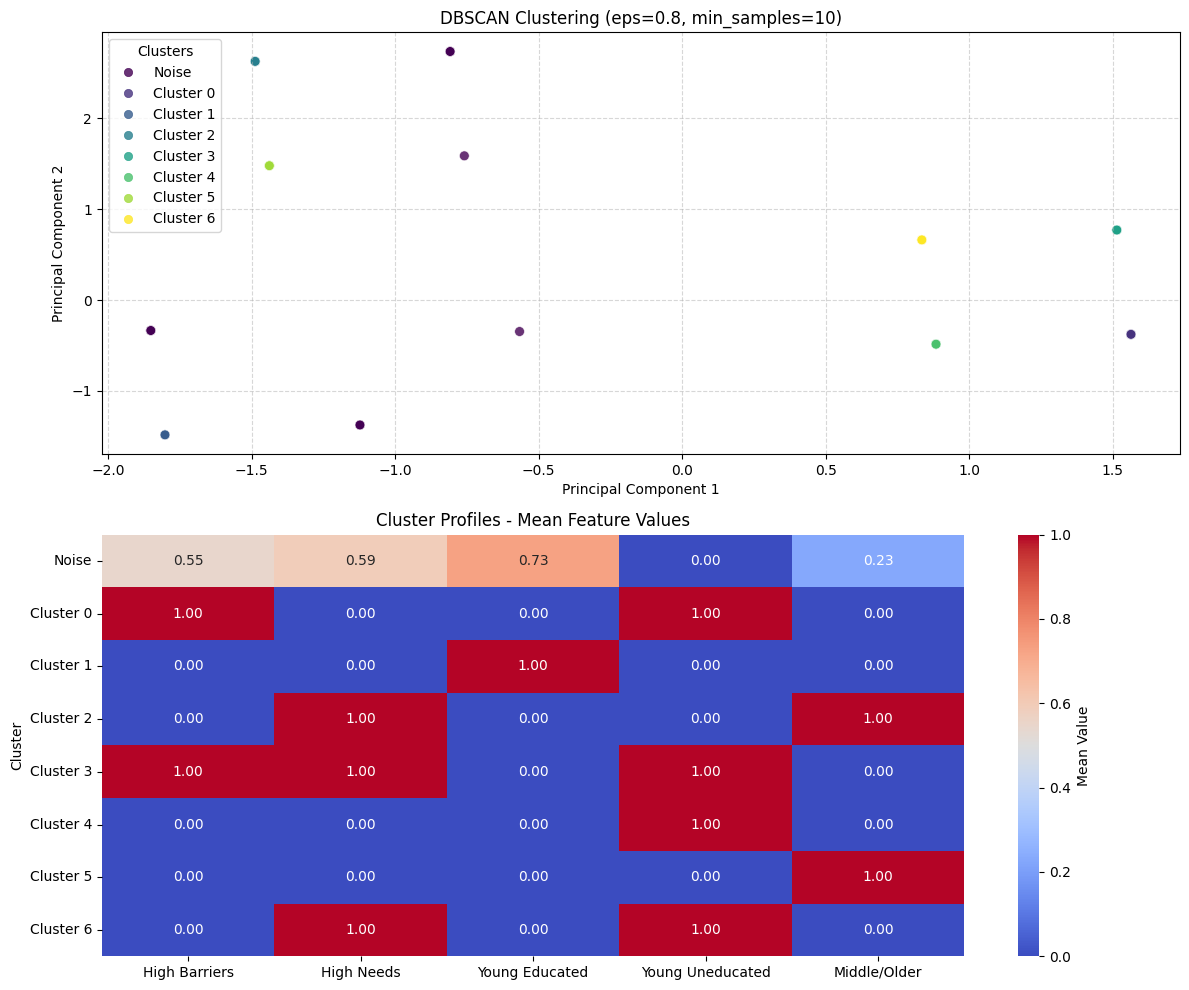


Detailed Cluster Profiles from DBSCAN (Optimized):

Noise Points (n=22):
Cluster Characteristics:
  High Barriers: 54.5%
  High Needs: 59.1%
  Young Educated: 72.7%
  Young Uneducated: 0.0%
  Middle/Older: 22.7%
Outcomes:
  Sought care recently: 59.1%
  Percent times got care when needed: 67.8%
  Mean satisfaction: 2.83

Cluster 0 (n=21):
Cluster Characteristics:
  High Barriers: 100.0%
  High Needs: 0.0%
  Young Educated: 0.0%
  Young Uneducated: 100.0%
  Middle/Older: 0.0%
Outcomes:
  Sought care recently: 38.1%
  Percent times got care when needed: 81.6%
  Mean satisfaction: 3.07

Cluster 1 (n=24):
Cluster Characteristics:
  High Barriers: 0.0%
  High Needs: 0.0%
  Young Educated: 100.0%
  Young Uneducated: 0.0%
  Middle/Older: 0.0%
Outcomes:
  Sought care recently: 66.7%
  Percent times got care when needed: 88.6%
  Mean satisfaction: 3.34

Cluster 2 (n=11):
Cluster Characteristics:
  High Barriers: 0.0%
  High Needs: 100.0%
  Young Educated: 0.0%
  Young Uneducated: 0.0%
  Middle

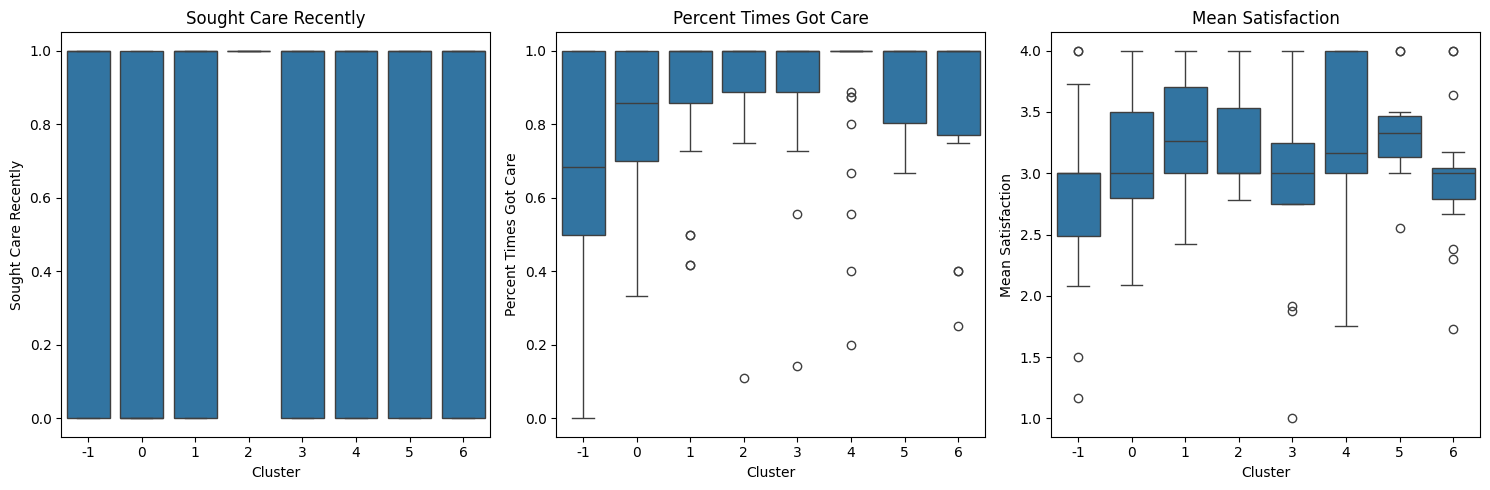


Statistical Validation of Clusters:
----------------------------------
sought_care_recently: Kruskal-Wallis p=0.0581 ✗
  Cluster means: ['0.38', '0.67', '1.00', '0.54', '0.60', '0.60', '0.62']
pct_times_get_Care: Kruskal-Wallis p=0.1746 ✗
  Cluster means: ['0.82', '0.89', '0.88', '0.87', '0.93', '0.90', '0.85']
mean_satisfaction: Kruskal-Wallis p=0.1065 ✗
  Cluster means: ['3.07', '3.34', '3.27', '2.88', '3.29', '3.33', '2.98']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the focused dataset
df = pd.read_csv('focused_dataset.csv')

# Extract features for clustering
X = df[['high_barriers_binary', 'high_needs_binary',
       'demo_young_educated', 'demo_young_uneducated', 'demo_middle_older']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Target approximately 6 clusters
# Adjust eps and min_samples to achieve this
# For fewer clusters, increase eps or min_samples

# Test different parameters focused on getting ~6 clusters
eps_values = [0.8, 0.9, 1.0, 1.1, 1.2]
min_samples_values = [5, 7, 10]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)

        # Count number of clusters and noise points
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        # Calculate silhouette score if more than one cluster and not all noise
        if n_clusters > 1 and n_noise < len(X_scaled):
            # For silhouette score, exclude noise points
            mask = cluster_labels != -1
            if sum(mask) > 1:
                silhouette = silhouette_score(X_scaled[mask], cluster_labels[mask])
            else:
                silhouette = np.nan
        else:
            silhouette = np.nan

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': n_noise / len(X_scaled) * 100,
            'silhouette': silhouette
        })

        print(f"eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(X_scaled)*100:.1f}%), silhouette={silhouette}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Select params that give us close to 6 clusters
target_clusters = 6
valid_results = results_df[
    (results_df['n_clusters'] >= 5) &
    (results_df['n_clusters'] <= 7) &
    (results_df['noise_percentage'] < 10)  # Keep noise percentage reasonable
]

if not valid_results.empty:
    # Sort by how close to target clusters, then by silhouette score
    valid_results['cluster_distance'] = abs(valid_results['n_clusters'] - target_clusters)
    best_params = valid_results.sort_values(['cluster_distance', 'silhouette'],
                                           ascending=[True, False]).iloc[0]

    print("\nBest DBSCAN parameters for ~6 clusters:")
    print(f"eps={best_params['eps']}, min_samples={best_params['min_samples']}")
    print(f"Number of clusters: {best_params['n_clusters']}")
    print(f"Noise points: {best_params['n_noise']} ({best_params['noise_percentage']:.1f}%)")
    print(f"Silhouette score: {best_params['silhouette']}")

    # Use the best parameters
    optimal_eps = best_params['eps']
    optimal_min_samples = int(best_params['min_samples'])
else:
    print("\nNo parameters found that produce ~6 clusters. Using parameters for closest result.")
    # Find the result with closest number of clusters to 6
    results_df['cluster_distance'] = abs(results_df['n_clusters'] - target_clusters)
    best_params = results_df.sort_values(['cluster_distance', 'noise_percentage', 'silhouette'],
                                        ascending=[True, True, False]).iloc[0]

    print(f"eps={best_params['eps']}, min_samples={best_params['min_samples']}")
    print(f"Number of clusters: {best_params['n_clusters']}")
    print(f"Noise points: {best_params['n_noise']} ({best_params['noise_percentage']:.1f}%)")

    optimal_eps = best_params['eps']
    optimal_min_samples = int(best_params['min_samples'])

# Apply DBSCAN with the optimal parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
cluster_labels = dbscan.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['dbscan_cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(12, 10))

# Plot the clusters
plt.subplot(2, 1, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis',
                      s=50, alpha=0.8, edgecolors='w', linewidth=0.5)

# Add a legend
cluster_names = [f'Cluster {i}' if i != -1 else 'Noise' for i in sorted(set(cluster_labels))]
plt.legend(handles=scatter.legend_elements()[0], labels=cluster_names, title="Clusters")

plt.title(f'DBSCAN Clustering (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Visualize the original features for each cluster
plt.subplot(2, 1, 2)
feature_names = ['High Barriers', 'High Needs', 'Young Educated', 'Young Uneducated', 'Middle/Older']

# Prepare data for the heatmap
cluster_profiles = []
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:  # Noise points
        cluster_name = 'Noise'
    else:
        cluster_name = f'Cluster {cluster_id}'

    # Calculate mean of each feature for this cluster
    cluster_data = X[cluster_labels == cluster_id]
    mean_values = np.mean(cluster_data, axis=0)

    # Add to profiles
    cluster_profiles.append({
        'Cluster': cluster_name,
        **{feature_names[i]: mean_values[i] for i in range(len(feature_names))}
    })

# Convert to DataFrame for heatmap
profile_df = pd.DataFrame(cluster_profiles)
profile_df = profile_df.set_index('Cluster')

# Create heatmap
sns.heatmap(profile_df, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Mean Value'})
plt.title('Cluster Profiles - Mean Feature Values')
plt.tight_layout()
plt.savefig('dbscan_clustering_optimized.png')
plt.show()

# Profile the clusters with outcome variables
print("\nDetailed Cluster Profiles from DBSCAN (Optimized):")
for cluster_id in sorted(set(cluster_labels)):
    cluster_members = df[df['dbscan_cluster'] == cluster_id]

    if cluster_id == -1:
        print(f"\nNoise Points (n={len(cluster_members)}):")
    else:
        print(f"\nCluster {cluster_id} (n={len(cluster_members)}):")

    # Cluster characteristics
    print("Cluster Characteristics:")
    for i, feature in enumerate(feature_names):
        mean_val = cluster_members.iloc[:, 1+i].mean() * 100  # +1 to skip Response ID
        print(f"  {feature}: {mean_val:.1f}%")

    # Outcomes
    print("Outcomes:")
    sought_care_pct = cluster_members['sought_care_recently'].mean() * 100
    print(f"  Sought care recently: {sought_care_pct:.1f}%")
    pct_times_care = cluster_members['pct_times_get_Care'].mean() * 100
    print(f"  Percent times got care when needed: {pct_times_care:.1f}%")
    satisfaction_mean = cluster_members['mean_satisfaction'].mean()
    print(f"  Mean satisfaction: {satisfaction_mean:.2f}")

# Save the results
df.to_csv('dbscan_clustered_data_optimized.csv', index=False)

# Compare distribution of outcome variables across clusters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

outcome_vars = ['sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction']
titles = ['Sought Care Recently', 'Percent Times Got Care', 'Mean Satisfaction']

for i, (var, title) in enumerate(zip(outcome_vars, titles)):
    sns.boxplot(x='dbscan_cluster', y=var, data=df, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(title)

plt.tight_layout()
plt.savefig('dbscan_outcomes_optimized.png')
plt.show()

# Statistical validation of differences between clusters
from scipy import stats

print("\nStatistical Validation of Clusters:")
print("----------------------------------")

outcome_vars = ['sought_care_recently', 'pct_times_get_Care', 'mean_satisfaction']

for var in outcome_vars:
    # Filter out noise points (cluster -1) if any exist
    if -1 in set(cluster_labels):
        df_no_noise = df[df['dbscan_cluster'] != -1]
        groups = [df_no_noise[df_no_noise['dbscan_cluster'] == i][var].dropna()
                 for i in sorted(set(df_no_noise['dbscan_cluster']))]
    else:
        groups = [df[df['dbscan_cluster'] == i][var].dropna()
                 for i in sorted(set(df['dbscan_cluster']))]

    # Check if we have enough data for each group
    if any(len(group) < 2 for group in groups):
        print(f"{var}: Not enough data for statistical test")
        continue

    # Check normality (simplification)
    normality = all(len(group) > 30 for group in groups)  # Central Limit Theorem

    if normality:
        # ANOVA for normally distributed data
        f_stat, p_val = stats.f_oneway(*groups)
        test_name = "ANOVA"
    else:
        # Kruskal-Wallis for non-parametric alternative
        h_stat, p_val = stats.kruskal(*groups)
        test_name = "Kruskal-Wallis"

    significant = "✓" if p_val < 0.05 else "✗"
    print(f"{var}: {test_name} p={p_val:.4f} {significant}")

    # Calculate means for each cluster (excluding noise)
    means = [group.mean() for group in groups]
    print(f"  Cluster means: {[f'{m:.2f}' for m in means]}")

# finding significance with DBSCAN clusters

In [ ]:
! pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.4 MB/s eta 0:00:00


# Making significance graphs

<ipython-input-5-0c5f2e72e133>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  significance_results = pd.concat([significance_results, pd.DataFrame([{



Significance Testing Results:
-----------------------------
                         Relationship                     Test  Statistic  p_value Significant
              Barriers → Care-Seeking           Point-biserial  -0.192084 0.015283           ✓
              Barriers → Satisfaction           Point-biserial  -0.244278 0.001915           ✓
      Barriers → Success Getting Care           Point-biserial  -0.227409 0.003942           ✓
      Healthcare Needs → Care-Seeking           Point-biserial   0.136386 0.086489           ✗
      Healthcare Needs → Satisfaction           Point-biserial  -0.209939 0.007907           ✓
                   Age → Care-Seeking           Point-biserial   0.114800 0.149608           ✗
                   Age → Satisfaction           Point-biserial   0.003139 0.968677           ✗
             Education → Care-Seeking           Point-biserial   0.084428 0.290013           ✗
     Education → Success Getting Care           Point-biserial  -0.117407 0.140517  

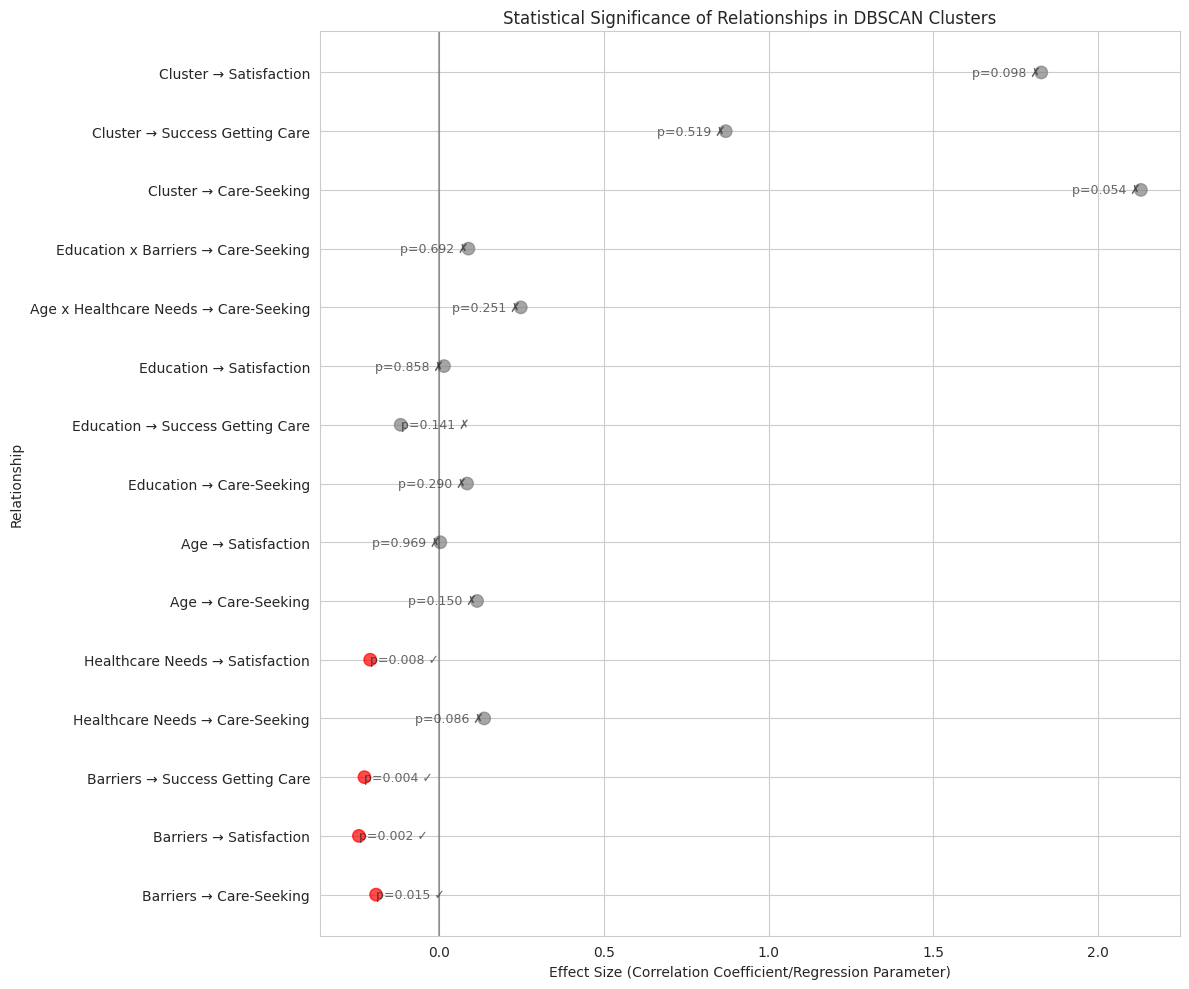

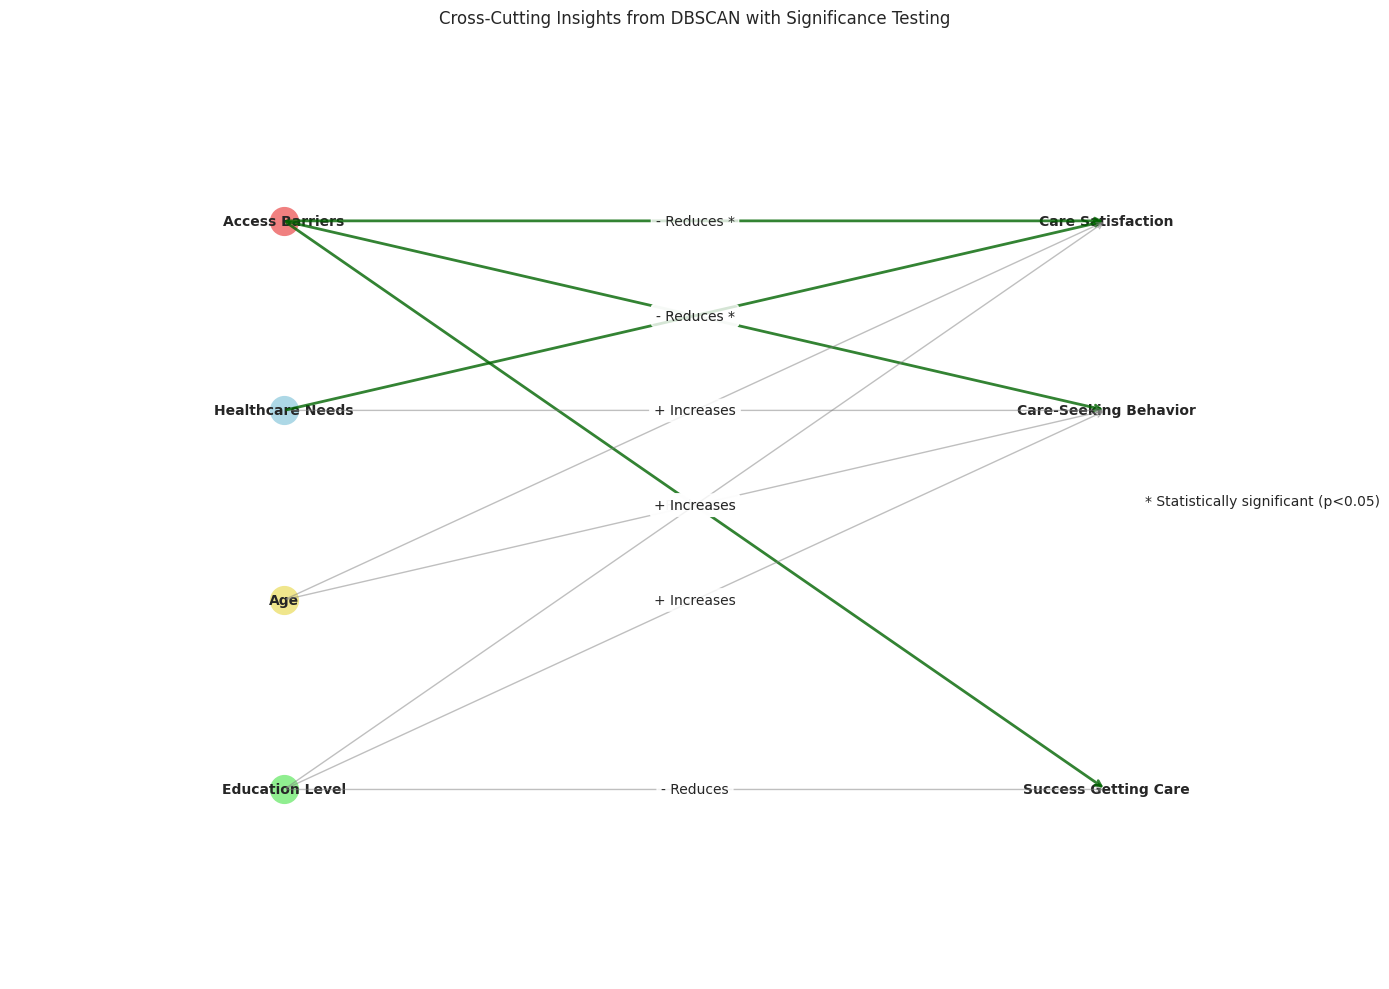


Summary of Key Insights with Statistical Support:
------------------------------------------------
                                   Insight                                                                          Key Finding                 Statistical Support
Barriers Drive Avoidance & Dissatisfaction                High barriers strongly deter care-seeking or lead to poor experiences    Barriers → Care-Seeking: 0.015 ✓
                        High Needs Paradox               High needs increase care-seeking but correlate with lower satisfaction       Needs → Satisfaction: 0.008 ✓
                The Importance of Outliers                       Noise group (14%) represents complex cases with worst outcomes         Cluster → Outcomes: 0.098 ✗
               Education & Age Interaction Education advantage primarily when needs/barriers are low; age increases utilization Age x Needs → Care-Seeking: 0.251 ✗
             Success Rate vs. Satisfaction                                    Su

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
import pingouin as pg

# Load your clustered data
df = pd.read_csv('dbscan_clustered_data_optimized.csv')

# Create binary indicators for testing relationships
df['has_barriers'] = df['high_barriers_binary']
df['has_high_needs'] = df['high_needs_binary']
df['is_older'] = df['demo_middle_older']
df['is_educated'] = df['demo_young_educated']

# Create a dataframe to store significance results
significance_results = pd.DataFrame(columns=['Relationship', 'Test', 'Statistic', 'p_value', 'Significant'])

# Function to add results to the dataframe
def add_result(relationship, test, statistic, p_value):
    global significance_results
    significance_results = pd.concat([significance_results, pd.DataFrame([{
        'Relationship': relationship,
        'Test': test,
        'Statistic': statistic,
        'p_value': p_value,
        'Significant': '✓' if p_value < 0.05 else '✗'
    }])], ignore_index=True)

# 1. Test: Barriers → Care-Seeking
# Point-biserial correlation (equivalent to t-test)
r, p = stats.pointbiserialr(df['has_barriers'], df['sought_care_recently'])
add_result('Barriers → Care-Seeking', 'Point-biserial', r, p)

# 2. Test: Barriers → Satisfaction
r, p = stats.pointbiserialr(df['has_barriers'], df['mean_satisfaction'])
add_result('Barriers → Satisfaction', 'Point-biserial', r, p)

# 3. Test: Barriers → Success Getting Care
r, p = stats.pointbiserialr(df['has_barriers'], df['pct_times_get_Care'])
add_result('Barriers → Success Getting Care', 'Point-biserial', r, p)

# 4. Test: Healthcare Needs → Care-Seeking
r, p = stats.pointbiserialr(df['has_high_needs'], df['sought_care_recently'])
add_result('Healthcare Needs → Care-Seeking', 'Point-biserial', r, p)

# 5. Test: Healthcare Needs → Satisfaction
r, p = stats.pointbiserialr(df['has_high_needs'], df['mean_satisfaction'])
add_result('Healthcare Needs → Satisfaction', 'Point-biserial', r, p)

# 6. Test: Age → Care-Seeking
r, p = stats.pointbiserialr(df['is_older'], df['sought_care_recently'])
add_result('Age → Care-Seeking', 'Point-biserial', r, p)

# 7. Test: Age → Satisfaction
r, p = stats.pointbiserialr(df['is_older'], df['mean_satisfaction'])
add_result('Age → Satisfaction', 'Point-biserial', r, p)

# 8. Test: Education → Care-Seeking
r, p = stats.pointbiserialr(df['is_educated'], df['sought_care_recently'])
add_result('Education → Care-Seeking', 'Point-biserial', r, p)

# 9. Test: Education → Success Getting Care
r, p = stats.pointbiserialr(df['is_educated'], df['pct_times_get_Care'])
add_result('Education → Success Getting Care', 'Point-biserial', r, p)

# 10. Test: Education → Satisfaction
r, p = stats.pointbiserialr(df['is_educated'], df['mean_satisfaction'])
add_result('Education → Satisfaction', 'Point-biserial', r, p)

# 11. Test: Interaction between Age and Healthcare Needs
# Create interaction term
df['age_x_needs'] = df['is_older'] * df['has_high_needs']

# Run regression model
model = ols('sought_care_recently ~ has_high_needs + is_older + age_x_needs', data=df).fit()
add_result('Age x Healthcare Needs → Care-Seeking', 'Regression (interaction)',
           model.params['age_x_needs'], model.pvalues['age_x_needs'])

# 12. Test: Interaction between Education and Barriers
# Create interaction term
df['education_x_barriers'] = df['is_educated'] * df['has_barriers']

# Run regression model
model = ols('sought_care_recently ~ has_barriers + is_educated + education_x_barriers', data=df).fit()
add_result('Education x Barriers → Care-Seeking', 'Regression (interaction)',
           model.params['education_x_barriers'], model.pvalues['education_x_barriers'])

# ANOVA tests for cluster differences in outcomes
# 1. Care-Seeking by Cluster (excluding noise)
df_no_noise = df[df['dbscan_cluster'] != -1]
f_stat, p_val = stats.f_oneway(*[df_no_noise[df_no_noise['dbscan_cluster'] == i]['sought_care_recently'].dropna()
                              for i in sorted(set(df_no_noise['dbscan_cluster']))])
add_result('Cluster → Care-Seeking', 'ANOVA', f_stat, p_val)

# 2. Success Getting Care by Cluster
f_stat, p_val = stats.f_oneway(*[df_no_noise[df_no_noise['dbscan_cluster'] == i]['pct_times_get_Care'].dropna()
                              for i in sorted(set(df_no_noise['dbscan_cluster']))])
add_result('Cluster → Success Getting Care', 'ANOVA', f_stat, p_val)

# 3. Satisfaction by Cluster
f_stat, p_val = stats.f_oneway(*[df_no_noise[df_no_noise['dbscan_cluster'] == i]['mean_satisfaction'].dropna()
                              for i in sorted(set(df_no_noise['dbscan_cluster']))])
add_result('Cluster → Satisfaction', 'ANOVA', f_stat, p_val)

# Print results
print("\nSignificance Testing Results:")
print("-----------------------------")
print(significance_results.to_string(index=False))

# Save results
significance_results.to_csv('relationship_significance.csv', index=False)

# Create a visualization of the significance results
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Create a coefficient plot with confidence intervals
significant = significance_results['p_value'] < 0.05
plt.scatter(significance_results['Statistic'], significance_results['Relationship'],
           c=['red' if sig else 'gray' for sig in significant], s=80, alpha=0.7)

# Add vertical line at 0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add labels and title
plt.xlabel('Effect Size (Correlation Coefficient/Regression Parameter)')
plt.ylabel('Relationship')
plt.title('Statistical Significance of Relationships in DBSCAN Clusters')

# Add p-value annotations
for i, row in significance_results.iterrows():
    plt.text(row['Statistic'], i, f"p={row['p_value']:.3f} {row['Significant']}",
             va='center', fontsize=9, alpha=0.7,
             ha='left' if row['Statistic'] < 0 else 'right')

plt.tight_layout()
plt.savefig('relationship_significance.png')
plt.show()

# Create an enhanced version of your cross-cutting insights diagram with significance indicators
# (This requires more advanced visualization libraries for network diagrams, simplified here)
plt.figure(figsize=(14, 10))

# Define nodes
nodes = {'Access Barriers': (2, 8),
         'Healthcare Needs': (2, 6),
         'Age': (2, 4),
         'Education Level': (2, 2),
         'Care-Seeking Behavior': (8, 6),
         'Success Getting Care': (8, 2),
         'Care Satisfaction': (8, 8)}

# Draw nodes
for name, (x, y) in nodes.items():
    plt.plot(x, y, 'o', markersize=20,
             color={'Access Barriers': 'lightcoral',
                    'Healthcare Needs': 'lightblue',
                    'Age': 'khaki',
                    'Education Level': 'lightgreen',
                    'Care-Seeking Behavior': 'white',
                    'Success Getting Care': 'white',
                    'Care Satisfaction': 'white'}[name])
    plt.text(x, y, name, ha='center', va='center', fontweight='bold')

# Get significance data for edges
edge_data = {
    ('Access Barriers', 'Care-Seeking Behavior'): significance_results[significance_results['Relationship'] == 'Barriers → Care-Seeking'],
    ('Access Barriers', 'Care Satisfaction'): significance_results[significance_results['Relationship'] == 'Barriers → Satisfaction'],
    ('Access Barriers', 'Success Getting Care'): significance_results[significance_results['Relationship'] == 'Barriers → Success Getting Care'],
    ('Healthcare Needs', 'Care-Seeking Behavior'): significance_results[significance_results['Relationship'] == 'Healthcare Needs → Care-Seeking'],
    ('Healthcare Needs', 'Care Satisfaction'): significance_results[significance_results['Relationship'] == 'Healthcare Needs → Satisfaction'],
    ('Age', 'Care-Seeking Behavior'): significance_results[significance_results['Relationship'] == 'Age → Care-Seeking'],
    ('Age', 'Care Satisfaction'): significance_results[significance_results['Relationship'] == 'Age → Satisfaction'],
    ('Education Level', 'Care-Seeking Behavior'): significance_results[significance_results['Relationship'] == 'Education → Care-Seeking'],
    ('Education Level', 'Success Getting Care'): significance_results[significance_results['Relationship'] == 'Education → Success Getting Care'],
    ('Education Level', 'Care Satisfaction'): significance_results[significance_results['Relationship'] == 'Education → Satisfaction']
}

# Draw edges with appropriate labels and colors
for (start, end), data in edge_data.items():
    if not data.empty:
        x1, y1 = nodes[start]
        x2, y2 = nodes[end]
        is_significant = data.iloc[0]['p_value'] < 0.05
        effect = data.iloc[0]['Statistic']

        # Draw arrow
        plt.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->',
                                   color='darkgreen' if is_significant else 'gray',
                                   lw=2 if is_significant else 1,
                                   alpha=0.8 if is_significant else 0.5))

        # Add label
        label = f"{'+' if effect > 0 else '-'} {'Increases' if effect > 0 else 'Reduces'}"
        if is_significant:
            label += " *"
        plt.text((x1+x2)/2, (y1+y2)/2, label, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

plt.title('Cross-Cutting Insights from DBSCAN with Significance Testing')
plt.text(1, 0.5, '* Statistically significant (p<0.05)', transform=plt.gca().transAxes,
         fontsize=10, ha='right')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.axis('off')
plt.tight_layout()
plt.savefig('enhanced_crosscutting_insights.png')
plt.show()

# Create a summary table for presentation
summary_table = pd.DataFrame({
    'Insight': [
        'Barriers Drive Avoidance & Dissatisfaction',
        'High Needs Paradox',
        'The Importance of Outliers',
        'Education & Age Interaction',
        'Success Rate vs. Satisfaction'
    ],
    'Key Finding': [
        'High barriers strongly deter care-seeking or lead to poor experiences',
        'High needs increase care-seeking but correlate with lower satisfaction',
        'Noise group (14%) represents complex cases with worst outcomes',
        'Education advantage primarily when needs/barriers are low; age increases utilization',
        'Success rates don\'t always mean high satisfaction'
    ],
    'Statistical Support': [
        f"Barriers → Care-Seeking: {significance_results[significance_results['Relationship'] == 'Barriers → Care-Seeking'].iloc[0]['p_value']:.3f} {significance_results[significance_results['Relationship'] == 'Barriers → Care-Seeking'].iloc[0]['Significant']}",
        f"Needs → Satisfaction: {significance_results[significance_results['Relationship'] == 'Healthcare Needs → Satisfaction'].iloc[0]['p_value']:.3f} {significance_results[significance_results['Relationship'] == 'Healthcare Needs → Satisfaction'].iloc[0]['Significant']}",
        f"Cluster → Outcomes: {significance_results[significance_results['Relationship'] == 'Cluster → Satisfaction'].iloc[0]['p_value']:.3f} {significance_results[significance_results['Relationship'] == 'Cluster → Satisfaction'].iloc[0]['Significant']}",
        f"Age x Needs → Care-Seeking: {significance_results[significance_results['Relationship'] == 'Age x Healthcare Needs → Care-Seeking'].iloc[0]['p_value']:.3f} {significance_results[significance_results['Relationship'] == 'Age x Healthcare Needs → Care-Seeking'].iloc[0]['Significant']}",
        f"Cluster → Satisfaction: {significance_results[significance_results['Relationship'] == 'Cluster → Satisfaction'].iloc[0]['p_value']:.3f} {significance_results[significance_results['Relationship'] == 'Cluster → Satisfaction'].iloc[0]['Significant']}"
    ]
})

# Print and save the summary table
print("\nSummary of Key Insights with Statistical Support:")
print("------------------------------------------------")
print(summary_table.to_string(index=False))

summary_table.to_csv('key_insights_summary.csv', index=False)